## Applying classifiers to make drug predictions

Here we apply embeddings generated in the NB:
`Graph embedding using SkipGram 20201012 homogeneous graph training.ipynb`
md5 hash: 261f9f7b0137263728c292a1a878d7baf3f875f3

that were used to generate link classifiers in this NB:
`Link prediction 20201012 homogeneous graph.ipynb`
md5 hash 3a13cb16b3db2a53917f7d25e16313b0fb3d411d

kg-covid-19:
version 20201012

ensmallen-graph
Version: 0.4.4 # upgraded from 0.4.3 for an update vers that has get_edge_id() and a few other methods. Otherwise 0.4.3 and 0.4.4 should be the same

embiggen
Version: 0.6.0

In [1]:
import os

w2v = "SkipGram"
exp_name = "80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001"
s3_path = "s3://kg-hub-public-data/embeddings/20201012/"  # keep trailing slash

base_dl_dir = "downloaded_data"
graph_data_dir = os.path.join(base_dl_dir, "kg-covid-19-20201012")
embedding_data_dir = os.path.join(base_dl_dir, "embeddings-20201012")
classifier_data_dir = os.path.join(base_dl_dir, "classifiers-20201012")

# graph stuff
graph_out_file = os.path.join(graph_data_dir + "/kg-covid-19.tar.gz")
nodes_file = os.path.join(graph_data_dir, "merged-kg_nodes.tsv")
edges_file = os.path.join(graph_data_dir, "merged-kg_edges.tsv")
sorted_edges_file = os.path.join(graph_data_dir, "merged-kg_edges_SORTED.tsv")
graph_tar_url = "https://kg-hub.berkeleybop.io/kg-covid-19/20201012/kg-covid-19.tar.gz"

# embeddings URLs
base_kghub_url = "http://kg-hub.berkeleybop.io/"
embeddings_url = os.path.join(base_kghub_url, "embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_embedding.npy")
embedding_file = os.path.join(embedding_data_dir, "SkipGram_embedding.npy")

# classifier URLs
classifier_base_url = "http://kg-hub.berkeleybop.io/embeddings/20201012/SkipGram_80_20_kg_covid_19_20201012_training_test_epoch_500_delta_0.0001_"
classifier_edge_models_to_use = 'average'
classifier_edge_models = ['average', 'hadamard', 'weightedL1', 'weightedL2']
classifier_suffix = '_finalized_model.h5'
classifier_urls = [f"{classifier_base_url}{m}{classifier_suffix}" for m in classifier_edge_models]
classifier_files = [f"{classifier_data_dir}/{w2v}_{exp_name}{m}{classifier_suffix}" for m in classifier_edge_models]

# params
seed = 42
train_percentage = 0.8
patience = 5

In [2]:
from pkg_resources import get_distribution
assert(get_distribution("ensmallen-graph").version == '0.4.4')  # upgraded from 0.4.3 for an update vers that has get_edge_id() and other methods
assert(get_distribution("embiggen").version == '0.6.0')
assert(get_distribution("tensorflow").version == '2.3.0')

In [3]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Retrieve and load graph

In [4]:
# get the graphs, if necessary

import urllib
import os
os.makedirs(graph_data_dir, exist_ok=True)

if not os.path.exists(nodes_file) or not os.path.exists(edges_file):
    with urllib.request.urlopen(graph_tar_url) as response, \
        open(graph_out_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)
    os.system("tar -xvzf " + graph_out_file + " -C " + graph_data_dir)

In [5]:
%%time
from ensmallen_graph import EnsmallenGraph

if not os.path.exists(sorted_edges_file):
    graph = EnsmallenGraph.from_unsorted_csv(
        edge_path = edges_file,
        sources_column="subject",
        destinations_column="object",
        directed=False,
        node_path = nodes_file,
        nodes_column = 'id',
        node_types_column = 'category',
        default_node_type = 'biolink:NamedThing'
    )

    graph.dump_edges(sorted_edges_file,
        sources_column="subject",
        destinations_column="object")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 192 ms


In [6]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_sorted_csv(
    edge_path = sorted_edges_file,
    sources_column="subject",
    destinations_column="object",
    directed=False,
    nodes_number=500000,  # should be = or > than actual number
    edges_number=42949369,   # same ^
    node_path = nodes_file,
    nodes_column = 'id',
    node_types_column = 'category',
    default_node_type = 'biolink:NamedThing'
)

graph.report()

{'density': '0.010673045865565448',
 'directed': 'false',
 'singletons': '8355',
 'nodes_number': '447766',
 'unique_node_types_number': '42',
 'has_node_types': 'true',
 'name': 'Graph',
 'undirected_edges_number': '15611957',
 'self_loops_number': '480',
 'self_loops_rate': '0.000015373068830289457',
 'degree_mean': '69.73158748096104',
 'edges_number': '31223434',
 'has_edge_types': 'false',
 'unique_edge_types_number': '0',
 'has_weights': 'false'}

## Make same holdouts as before

In [7]:
%%time
pos_training, pos_validation = graph.connected_holdout(train_size=train_percentage, random_state=seed)

CPU times: user 3min 13s, sys: 532 ms, total: 3min 13s
Wall time: 3min 12s


The followings are check that are not necessary, but are offered as sanity checks:

In [8]:
%%time
coherence_check=True
if coherence_check:
    assert graph.contains(pos_training)
    assert graph.contains(pos_validation)
    assert (pos_training | pos_validation).contains(graph)
    assert graph.contains(pos_training | pos_validation)
    assert not pos_training.overlaps(pos_validation)
    assert not pos_validation.overlaps(pos_training)

CPU times: user 27min 10s, sys: 2.04 s, total: 27min 12s
Wall time: 4min 18s


## Loading the embeddings

In [9]:
os.makedirs(embedding_data_dir, exist_ok=True)

if not os.path.exists(embedding_file):
    with urllib.request.urlopen(embeddings_url) as response, \
        open(embedding_file, 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [10]:
import numpy as np
embeddings = np.load(embedding_file)

#### More coherence checks

In [11]:
assert len(pos_training.get_nodes_reverse_mapping()) == len(embeddings)
assert len(pos_training.get_node_types()) == len(embeddings)

In [12]:
node_curies = list(np.array(pos_training.get_nodes_reverse_mapping()))

In [13]:
sars_cov_2_curie = 'NCBITaxon:2697049'
sars_cov_2_idx = node_curies.index(sars_cov_2_curie)

In [14]:
drug_idx = list(np.where(pos_training.get_node_types() == pos_training.get_node_types_reverse_mapping().index('biolink:Drug'))[0])
drug_names = [node_curies[i] for i in drug_idx]

In [15]:
chem_substance_idx = list(np.where(pos_training.get_node_types() == pos_training.get_node_types_reverse_mapping().index('biolink:ChemicalSubstance'))[0])
chem_substance_names = [node_curies[i] for i in chem_substance_idx]

In [16]:
import re
chembl_prefix = 'CHEMBL.COMPOUND'
chembl_names = [x for x in node_curies if (re.compile(chembl_prefix).search(x))]
chembl_idx = [index for index, x in enumerate(node_curies) if (re.compile(chembl_prefix).search(x))]

## Loading trained MLP models

In [17]:
os.makedirs(classifier_data_dir, exist_ok=True)

for i, url in enumerate(classifier_urls):
    with urllib.request.urlopen(url) as response, \
        open(os.path.join(classifier_files[i]), 'wb') as out_file:
            data = response.read()  # a `bytes` object
            out_file.write(data)

In [18]:
import tensorflow as tf
mlp_model = (classifier_edge_models_to_use,
             tf.keras.models.load_model(
                 classifier_files[classifier_edge_models.index(classifier_edge_models_to_use)]
             ))

In [19]:
sars_cov_2_emb = embeddings[sars_cov_2_idx]

In [20]:
print(f"using %s model for edge embeddings" % mlp_model[0])

using average model for edge embeddings


In [22]:
from embiggen import GraphTransformer, EdgeTransformer

assert(mlp_model[0] in EdgeTransformer.methods)

transformer = GraphTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
transformer.fit(embeddings)
train_edges = transformer.transform(pos_training)
assert(pos_training.get_edges_number() == len(train_edges))

In [23]:
# let's try to predict a link that should exist in training graph
# example SARS-CoV-2 -> ChEMBL compound edge (which should bge positive)
example_chembl_edge = train_edges[pos_training.get_edge_id(sars_cov_2_idx, chembl_idx[0])]
example_chembl_edge.shape
example_chembl_edge.__class__
mlp_model[1].predict(example_chembl_edge.reshape(1, -1))

ValueError: in user code:

    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1445 run_step  **
        outputs = model.predict_step(data)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1418 predict_step
        return self(x, training=False)
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/jtr4v/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape [None, 2497874800]


In [32]:
# prepare source (drugs) and destination (SARS-CoV-2) numpy arrays
import logging
import numpy as np

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

drug_idx_wo_exist_links = []
for drug_id in drug_idx:
    if not pos_training.has_edge(drug_id, sars_cov_2_idx) and not pos_training.has_edge(sars_cov_2_idx, drug_id):
        drug_idx_wo_exist_links.append(drug_id)
    else:
        print("Not using edge %s %s which was present in training graph" % (drug_id, sars_cov_2_idx))
        logging.warning("Not using edge %s %s which was present in training graph" % (drug_id, sars_cov_2_idx))
drug_idx_wo_exist_links = np.asarray(drug_idx_wo_exist_links)
sars_cov_2_dest = np.repeat(sars_cov_2_idx, len(drug_idx_wo_exist_links))

In [25]:
# Make an edge transformer for drug -> SARS-CoV-2 edge for every member of drug_idx

from embiggen import GraphTransformer, EdgeTransformer
assert(mlp_model[0] in EdgeTransformer.methods)

edge_transformer = EdgeTransformer(mlp_model[0]) # pass edge embedding method, which is mlp_model[0]
assert(drug_idx_wo_exist_links.shape == sars_cov_2_dest.shape)
edge_transformer.fit(embeddings)
drug_edges = edge_transformer.transform(sources=drug_idx_wo_exist_links, destinations=sars_cov_2_dest)
assert(len(drug_idx_wo_exist_links) == len(drug_edges))

drug_prediction_pval = mlp_model[1].predict(drug_edges)

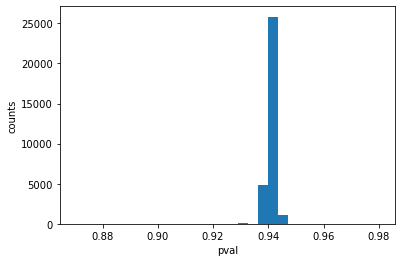

In [26]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(drug_prediction_pval, density=False, bins=30)  # `density=False` would make counts
plt.ylabel('counts')
plt.xlabel('pval');

In [29]:
sort_idx = np.argsort(drug_prediction_pval, axis=0)[::-1]

with open("drug_sars_cov2_link_prediction.tsv", "w") as out:
    out.write("graph_id\tCURIE\tprobability\n")
    for idx in np.nditer(sort_idx, order='F'):
        line = f"%i\t%s\t%f\n" % (drug_idx_wo_exist_links[idx],
                        pos_training.get_nodes_reverse_mapping()[drug_idx_wo_exist_links[idx]],
                        drug_prediction_pval[idx])
        print(line)
        out.write(line)

37303	DrugCentral:732	0.980335

39236	DRUGBANK:DB14724	0.979980

40011	DRUGBANK:DB01367	0.973461

39285	CHEBI:40279	0.973230

37441	DrugCentral:945	0.972850

38824	DrugCentral:4642	0.971171

39228	PHARMGKB:PA164712331	0.967701

39341	DRUGBANK:DB00072	0.967164

60093	ttd.drug:D00HVA	0.966564

51626	ttd.drug:D02BHW	0.964383

66535	ttd.drug:D0I6ZS	0.964161

56000	ttd.drug:D08OXU	0.964005

65786	ttd.drug:D0F4FK	0.963830

37662	DrugCentral:1356	0.963781

41522	ttd.drug:D06CIJ	0.963523

55226	ttd.drug:D0J0OY	0.962260

63857	ttd.drug:D0O5XF	0.962181

38011	DrugCentral:1999	0.961859

41431	ttd.drug:D0M9YZ	0.961487

63072	ttd.drug:D0Z7FU	0.961431

60054	ttd.drug:D0AM2B	0.960966

44903	ttd.drug:D0DF1R	0.960712

45115	ttd.drug:D0D9ON	0.959232

58886	ttd.drug:D0PW7B	0.958818

64624	ttd.drug:D02EFX	0.958729

68827	ttd.drug:D02DUM	0.958620

57107	ttd.drug:D0PJ8O	0.958154

66537	ttd.drug:D0M9VY	0.958026

66096	ttd.drug:D0ZL3Z	0.957623

37360	DrugCentral:814	0.957519

53557	ttd.drug:D0AJ0O	0.956932

4

69448	ttd.drug:D0H2TZ	0.944583

55646	ttd.drug:D0D4LF	0.944576

68891	ttd.drug:D0KK6A	0.944576

55958	ttd.drug:D01JFT	0.944569

68068	ttd.drug:D0YQ8V	0.944569

61481	ttd.drug:D09TPW	0.944567

60213	ttd.drug:D0X5ZH	0.944566

66138	ttd.drug:D0S7LN	0.944566

63550	ttd.drug:D0GN5K	0.944560

48441	ttd.drug:D05GOM	0.944557

45703	ttd.drug:D0O9RV	0.944552

41148	ttd.drug:D0E4JU	0.944549

50558	ttd.drug:D08FWK	0.944549

42187	ttd.drug:D0GT6I	0.944547

53357	ttd.drug:D0U0VH	0.944546

53186	ttd.drug:D0O6NS	0.944544

45289	ttd.drug:D09ZJQ	0.944541

56827	ttd.drug:D01AUS	0.944541

56508	ttd.drug:D06GKN	0.944539

59551	ttd.drug:D0O9II	0.944530

68033	ttd.drug:D0V6GX	0.944529

37289	DrugCentral:701	0.944529

57227	ttd.drug:D0WJ8R	0.944529

60803	ttd.drug:D07JHG	0.944527

45507	ttd.drug:D04TSL	0.944527

67004	ttd.drug:D0G7KY	0.944522

41042	ttd.drug:D09SCI	0.944507

54873	ttd.drug:D05COQ	0.944507

57487	ttd.drug:D01PYM	0.944505

50119	ttd.drug:D03IAB	0.944502

42323	ttd.drug:D0E0LL	0.944499

43906	tt

67669	ttd.drug:D0M1QJ	0.944119

55442	ttd.drug:D02OPG	0.944119

41906	ttd.drug:D0A5XB	0.944116

62575	ttd.drug:D0X3PN	0.944112

54737	ttd.drug:D0Z6UC	0.944109

42086	ttd.drug:D0MZ9A	0.944109

52759	ttd.drug:D06CHV	0.944108

43832	ttd.drug:D0P7PK	0.944108

50378	ttd.drug:D09RUJ	0.944107

64178	ttd.drug:D0G5SU	0.944107

67479	ttd.drug:D04NCC	0.944106

63366	ttd.drug:D0R2OX	0.944104

56858	ttd.drug:D0DY5Y	0.944102

55563	ttd.drug:D0R8FM	0.944101

50544	ttd.drug:D08ZRP	0.944099

57070	ttd.drug:D01SZA	0.944099

61755	ttd.drug:D05MAT	0.944098

55963	ttd.drug:D00IUG	0.944097

40248	DRUGBANK:DB00480	0.944097

56933	ttd.drug:D0J0MD	0.944093

62608	ttd.drug:D09OAQ	0.944093

38679	DrugCentral:4172	0.944092

40744	ttd.drug:D0FJ1W	0.944091

46103	ttd.drug:D0C0HN	0.944090

63878	ttd.drug:D05GIO	0.944088

62510	ttd.drug:D05GXK	0.944086

55865	ttd.drug:D05CFH	0.944085

46479	ttd.drug:D0R8UO	0.944084

59982	ttd.drug:D0U0KR	0.944083

60679	ttd.drug:D04YHW	0.944083

56105	ttd.drug:D0U7BI	0.944083

60271	

53526	ttd.drug:D0P5AE	0.943876

55040	ttd.drug:D02PPQ	0.943875

41217	ttd.drug:D0N0DU	0.943875

38394	DrugCentral:2759	0.943875

52186	ttd.drug:D0BA6T	0.943873

41328	ttd.drug:D0A4YR	0.943872

44857	ttd.drug:D0EG1I	0.943871

43717	ttd.drug:D0A2RG	0.943868

62576	ttd.drug:D0V4XG	0.943868

64974	ttd.drug:D04SUV	0.943866

63823	ttd.drug:D0U2GX	0.943865

65910	ttd.drug:D08UNC	0.943864

38589	DrugCentral:3616	0.943864

37757	DrugCentral:1551	0.943863

68884	ttd.drug:D0EJ7Q	0.943863

37987	DrugCentral:1959	0.943862

43910	ttd.drug:D0P6FN	0.943861

48743	ttd.drug:D0G5ML	0.943861

67555	ttd.drug:D00CRQ	0.943859

65839	ttd.drug:D0RI6Q	0.943859

53179	ttd.drug:D0YR1V	0.943859

58469	ttd.drug:D02GSX	0.943858

44841	ttd.drug:D07WDQ	0.943858

50910	ttd.drug:D0UV1C	0.943858

42909	ttd.drug:D00SQN	0.943856

47263	ttd.drug:D0S2LV	0.943856

48541	ttd.drug:D0Y6SN	0.943856

42475	ttd.drug:D01OIV	0.943855

39801	PHARMGKB:PA164924567	0.943855

57858	ttd.drug:D0C3AR	0.943854

65322	ttd.drug:D0XN5L	0.943854


63391	ttd.drug:D02QTE	0.943688

47165	ttd.drug:D0S0ES	0.943688

49881	ttd.drug:D0JN3M	0.943688

55428	ttd.drug:D0W6XL	0.943687

66727	ttd.drug:D07ZMG	0.943687

44904	ttd.drug:D04TEF	0.943685

48686	ttd.drug:D09APB	0.943685

50027	ttd.drug:D0N7HY	0.943684

37772	DrugCentral:1575	0.943684

67458	ttd.drug:D0V0OD	0.943682

66262	ttd.drug:D0C2NT	0.943682

60561	ttd.drug:D09QNH	0.943682

47175	ttd.drug:D00ERV	0.943681

43302	ttd.drug:D0E9DI	0.943679

57523	ttd.drug:D00ZMS	0.943677

50822	ttd.drug:D00WLO	0.943676

46696	ttd.drug:D06RTP	0.943675

53324	ttd.drug:D0K6XD	0.943675

59668	ttd.drug:D0Y0BZ	0.943674

53418	ttd.drug:D0TV9B	0.943673

62934	ttd.drug:D00XKH	0.943673

60385	ttd.drug:D0U2TQ	0.943673

62710	ttd.drug:D07ZAJ	0.943672

55194	ttd.drug:D05REP	0.943672

62740	ttd.drug:D04DQF	0.943672

67732	ttd.drug:D09MTV	0.943671

66281	ttd.drug:D0Y3XA	0.943671

44402	ttd.drug:D0N7DQ	0.943670

63749	ttd.drug:D09KTP	0.943670

40550	CHEBI:1391	0.943670

57811	ttd.drug:D0I8QS	0.943669

38100	DrugCe

45119	ttd.drug:D07ALM	0.943558

67027	ttd.drug:D0IF0T	0.943557

57662	ttd.drug:D0R2YM	0.943556

52792	ttd.drug:D01LPX	0.943556

65460	ttd.drug:D0B0AX	0.943556

63939	ttd.drug:D0I7FI	0.943555

63771	ttd.drug:D0R8LN	0.943554

38328	DrugCentral:2630	0.943553

60098	ttd.drug:D0E8KF	0.943552

54104	ttd.drug:D0GG9P	0.943552

68347	ttd.drug:D06AOQ	0.943552

67109	ttd.drug:D0O9BK	0.943552

62056	ttd.drug:D01CFO	0.943552

40357	DRUGBANK:DB00078	0.943551

46102	ttd.drug:D0I7IF	0.943551

46423	ttd.drug:D00EIL	0.943550

58596	ttd.drug:D0O7NV	0.943550

59826	ttd.drug:D08HLL	0.943549

56007	ttd.drug:D03GNR	0.943549

63046	ttd.drug:D0S6CW	0.943548

65052	ttd.drug:D04AIV	0.943548

42598	ttd.drug:D08JGS	0.943547

51349	ttd.drug:D0F2QP	0.943547

49884	ttd.drug:D0IE4H	0.943547

37694	DrugCentral:1413	0.943547

63286	ttd.drug:D01AMV	0.943545

41309	ttd.drug:D04KQB	0.943545

57389	ttd.drug:D0CU9Y	0.943545

46767	ttd.drug:D0T6WV	0.943545

62131	ttd.drug:D05STL	0.943545

41540	ttd.drug:D0N6ES	0.943545

45139

47686	ttd.drug:D09JII	0.943457

62234	ttd.drug:D0NE0W	0.943457

61523	ttd.drug:D0GT7A	0.943454

55808	ttd.drug:D0FZ1H	0.943454

53725	ttd.drug:D01QLM	0.943453

51541	ttd.drug:D0P0TR	0.943453

61136	ttd.drug:D09NAJ	0.943452

47272	ttd.drug:D0C2EW	0.943452

54461	ttd.drug:D0AQ3K	0.943451

41359	ttd.drug:D0NJ3V	0.943450

55135	ttd.drug:D04TJP	0.943450

64007	ttd.drug:D09OTM	0.943449

48201	ttd.drug:D0B7OW	0.943449

41981	ttd.drug:D0O2ET	0.943449

50096	ttd.drug:D02JGD	0.943448

44826	ttd.drug:D0V9MT	0.943448

43219	ttd.drug:D07TVO	0.943448

62725	ttd.drug:D0A0GD	0.943448

47719	ttd.drug:D08XKO	0.943447

56096	ttd.drug:D0R6PX	0.943447

53884	ttd.drug:D0IY1Z	0.943445

60788	ttd.drug:D04AGE	0.943445

42054	ttd.drug:D01KKU	0.943445

37795	DrugCentral:1612	0.943445

45212	ttd.drug:D02QCC	0.943445

47281	ttd.drug:D0DL1O	0.943445

58129	ttd.drug:D0N3SP	0.943443

61783	ttd.drug:D0RK4K	0.943443

48486	ttd.drug:D0W1WQ	0.943442

51098	ttd.drug:D03CKF	0.943442

66731	ttd.drug:D0VE7T	0.943442

53072	t

53916	ttd.drug:D0K8EV	0.943368

43525	ttd.drug:D0D1PE	0.943367

59789	ttd.drug:D0Q4YY	0.943367

41959	ttd.drug:D0D4AQ	0.943367

44013	ttd.drug:D0VS1V	0.943367

38736	DrugCentral:4308	0.943367

57171	ttd.drug:D09ZWU	0.943367

39130	DrugCentral:5272	0.943367

46343	ttd.drug:D09TFB	0.943366

39857	CHEBI:10100	0.943366

43924	ttd.drug:D09DEK	0.943366

38367	DrugCentral:2714	0.943366

43482	ttd.drug:D0A1RE	0.943365

58776	ttd.drug:D05EMG	0.943365

44603	ttd.drug:D0D8GU	0.943364

38078	DrugCentral:2138	0.943364

68536	ttd.drug:D0R0ZC	0.943362

66566	ttd.drug:D0X0IT	0.943362

56542	ttd.drug:D09JBP	0.943362

61526	ttd.drug:D0Z0QS	0.943362

60582	ttd.drug:D0EU9F	0.943361

61114	ttd.drug:D01HDP	0.943361

60150	ttd.drug:D0T5GT	0.943361

66385	ttd.drug:D0X5YM	0.943361

50703	ttd.drug:D05UKK	0.943360

66680	ttd.drug:D07XBA	0.943359

46197	ttd.drug:D0F0JU	0.943359

67006	ttd.drug:D0N3AF	0.943359

55436	ttd.drug:D0Q9XI	0.943359

59054	ttd.drug:D0CZ1Q	0.943358

52904	ttd.drug:D0I1XE	0.943357

48041	tt

49790	ttd.drug:D0B8BC	0.943278

43189	ttd.drug:D0ES1Q	0.943278

37712	DrugCentral:1443	0.943277

51423	ttd.drug:D0A4JK	0.943277

62310	ttd.drug:D0A8VU	0.943277

59985	ttd.drug:D00HVX	0.943276

65889	ttd.drug:D0E4DT	0.943276

52437	ttd.drug:D09WWY	0.943276

63018	ttd.drug:D0X0OP	0.943276

50854	ttd.drug:D0RN5A	0.943275

61274	ttd.drug:D0Q2BB	0.943275

49679	ttd.drug:D0NY4W	0.943274

63498	ttd.drug:D06DWW	0.943274

60454	ttd.drug:D0XL7C	0.943274

44277	ttd.drug:D05ZTI	0.943274

44962	ttd.drug:D0C7YS	0.943274

39410	PHARMGKB:PA452229	0.943274

42540	ttd.drug:D0AG7N	0.943273

52001	ttd.drug:D07TQN	0.943273

64891	ttd.drug:D0M7AU	0.943272

41930	ttd.drug:D08SGE	0.943271

39269	PHARMGKB:PA166163416	0.943271

42118	ttd.drug:D0ZX8C	0.943270

48236	ttd.drug:D0Q3WN	0.943269

62024	ttd.drug:D0A9VZ	0.943269

52197	ttd.drug:D01JUF	0.943269

64224	ttd.drug:D0EN4B	0.943269

45015	ttd.drug:D0UV3I	0.943268

40657	CHEBI:4798	0.943268

51399	ttd.drug:D0KB4T	0.943267

52563	ttd.drug:D04BNP	0.943266

65043

67824	ttd.drug:D01TMC	0.943194

38926	DrugCentral:4906	0.943194

63765	ttd.drug:D0C6QI	0.943193

43256	ttd.drug:D05SOW	0.943193

47246	ttd.drug:D0N3SU	0.943192

62647	ttd.drug:D00ONN	0.943192

49794	ttd.drug:D07RQT	0.943192

56388	ttd.drug:D08VDV	0.943192

59499	ttd.drug:D07WOT	0.943192

50129	ttd.drug:D0B1GX	0.943191

51961	ttd.drug:D0HV7T	0.943191

63354	ttd.drug:D0M0LC	0.943191

46684	ttd.drug:D02JVA	0.943191

60154	ttd.drug:D0X7WK	0.943191

55811	ttd.drug:D0TZ1Y	0.943191

37395	DrugCentral:865	0.943191

56121	ttd.drug:D02EWR	0.943190

44215	ttd.drug:D09ZIM	0.943190

57452	ttd.drug:D0J4PE	0.943190

42543	ttd.drug:D0UO2P	0.943189

59347	ttd.drug:D0V0FY	0.943189

50606	ttd.drug:D01FGM	0.943189

53848	ttd.drug:D05AJZ	0.943189

39687	PHARMGKB:PA165111696	0.943188

54235	ttd.drug:D07PNX	0.943188

43380	ttd.drug:D0I9CK	0.943187

44113	ttd.drug:D0U1EV	0.943187

53310	ttd.drug:D0E2FY	0.943187

62407	ttd.drug:D07PSG	0.943186

61619	ttd.drug:D00XJR	0.943186

61316	ttd.drug:D0S4XR	0.943186

42

67970	ttd.drug:D0Y8PM	0.943126

56878	ttd.drug:D0B0VD	0.943125

67221	ttd.drug:D09RIC	0.943125

61678	ttd.drug:D0F7XM	0.943125

60939	ttd.drug:D04JPQ	0.943125

63399	ttd.drug:D0T4QX	0.943125

59218	ttd.drug:D0T5DP	0.943125

53231	ttd.drug:D07CEU	0.943124

37391	DrugCentral:862	0.943124

55632	ttd.drug:D04LJH	0.943124

60640	ttd.drug:D0A4ZR	0.943124

45220	ttd.drug:D0UK4O	0.943124

58833	ttd.drug:D0S3UM	0.943123

56840	ttd.drug:D0U0HX	0.943123

55907	ttd.drug:D0D6FQ	0.943123

64127	ttd.drug:D03RXS	0.943123

45891	ttd.drug:D0U3SY	0.943122

57504	ttd.drug:D09GTJ	0.943122

67875	ttd.drug:D04HZX	0.943122

42903	ttd.drug:D0U7CD	0.943121

64468	ttd.drug:D04CFM	0.943121

41774	ttd.drug:D0G4AJ	0.943121

44302	ttd.drug:D04UPQ	0.943121

68955	ttd.drug:D0CO9Z	0.943120

64439	ttd.drug:D03SUB	0.943120

42626	ttd.drug:D06WTZ	0.943120

44493	ttd.drug:D02SIT	0.943120

52821	ttd.drug:D0X5MA	0.943119

56391	ttd.drug:D04QQG	0.943119

57856	ttd.drug:D07DLW	0.943119

46810	ttd.drug:D0PG0S	0.943119

39952	CH

51118	ttd.drug:D0D6KZ	0.943058

57324	ttd.drug:D0C0SK	0.943058

68776	ttd.drug:D0S4YV	0.943058

43340	ttd.drug:D0Q4EQ	0.943058

50964	ttd.drug:D07QUY	0.943058

67008	ttd.drug:D07AXK	0.943058

59901	ttd.drug:D0Y0OA	0.943058

64757	ttd.drug:D0T2QP	0.943057

38780	DrugCentral:4477	0.943056

58843	ttd.drug:D00UZO	0.943056

62028	ttd.drug:D06ZTU	0.943055

67898	ttd.drug:D0M0TS	0.943054

63116	ttd.drug:D0K1NP	0.943054

43519	ttd.drug:D0Q3VI	0.943054

58682	ttd.drug:D02NCY	0.943054

41189	ttd.drug:D07PUS	0.943054

42200	ttd.drug:D0Z6WU	0.943053

60767	ttd.drug:D0JI8S	0.943053

51547	ttd.drug:D04MOF	0.943052

60567	ttd.drug:D0U2YE	0.943052

52848	ttd.drug:D0HF0A	0.943052

52705	ttd.drug:D04LWL	0.943052

37086	DrugCentral:296	0.943052

65949	ttd.drug:D0F5GF	0.943052

37039	DrugCentral:213	0.943051

47104	ttd.drug:D0UP1Z	0.943051

42757	ttd.drug:D0F0ZY	0.943051

49760	ttd.drug:D04IZU	0.943051

63653	ttd.drug:D03WMK	0.943051

68076	ttd.drug:D05RJQ	0.943051

45141	ttd.drug:D09NBM	0.943051

60663	t

55037	ttd.drug:D0A9LX	0.943001

49065	ttd.drug:D0W7JA	0.943001

42399	ttd.drug:D0X4HG	0.943000

64223	ttd.drug:D0SQ0F	0.943000

42560	ttd.drug:D01FWD	0.943000

68527	ttd.drug:D0YL4X	0.943000

66794	ttd.drug:D0NG8Q	0.942999

54023	ttd.drug:D05LYX	0.942999

40976	ttd.drug:D09JUG	0.942999

65972	ttd.drug:D0H3ST	0.942999

51564	ttd.drug:D0K4RK	0.942998

46788	ttd.drug:D0OC5T	0.942998

54343	ttd.drug:D0Z1XR	0.942998

65870	ttd.drug:D02FEV	0.942998

41381	ttd.drug:D09WUP	0.942998

48954	ttd.drug:D0BW2N	0.942998

51251	ttd.drug:D04MYP	0.942997

49975	ttd.drug:D00YGY	0.942996

40621	PHARMGKB:PA166163427	0.942996

52098	ttd.drug:D00HET	0.942995

61921	ttd.drug:D02UHP	0.942995

63151	ttd.drug:D0J4QE	0.942994

56666	ttd.drug:D0P4QS	0.942994

56599	ttd.drug:D09BHB	0.942994

42716	ttd.drug:D00UOI	0.942994

41613	ttd.drug:D04RCR	0.942994

58565	ttd.drug:D0S5IR	0.942994

46890	ttd.drug:D0E5CF	0.942993

41184	ttd.drug:D0S8YD	0.942993

49727	ttd.drug:D04RUF	0.942992

65471	ttd.drug:D0T2IQ	0.942992

486

41306	ttd.drug:D0D6UF	0.942936

66465	ttd.drug:D0G3QD	0.942936

51924	ttd.drug:D0W8EP	0.942936

54237	ttd.drug:D0EH4P	0.942935

57089	ttd.drug:D0PT0U	0.942935

40892	ttd.drug:D02GCE	0.942935

38181	DrugCentral:2352	0.942935

67073	ttd.drug:D08VAT	0.942935

49755	ttd.drug:D02PKR	0.942935

55677	ttd.drug:D0XF6C	0.942934

48786	ttd.drug:D0V5HV	0.942934

52670	ttd.drug:D0TQ8V	0.942934

47173	ttd.drug:D02DSZ	0.942933

61468	ttd.drug:D01HCL	0.942933

68693	ttd.drug:D07AUV	0.942933

56959	ttd.drug:D05UGL	0.942933

48703	ttd.drug:D01ZGH	0.942932

52072	ttd.drug:D07SKJ	0.942932

47262	ttd.drug:D0UL2R	0.942932

50405	ttd.drug:D0E2CS	0.942932

52049	ttd.drug:D05COL	0.942932

62639	ttd.drug:D0J6KS	0.942932

38872	DrugCentral:4808	0.942932

49745	ttd.drug:D09JRN	0.942931

61776	ttd.drug:D0C5GW	0.942931

57334	ttd.drug:D07DPC	0.942931

44706	ttd.drug:D0Q0JI	0.942930

56408	ttd.drug:D09CAI	0.942930

41395	ttd.drug:D0YZ0L	0.942930

67111	ttd.drug:D0X9PI	0.942930

43305	ttd.drug:D0M9OF	0.942930

56263	

54562	ttd.drug:D0O2WX	0.942887

60677	ttd.drug:D03JFK	0.942887

53329	ttd.drug:D0D2PL	0.942887

44267	ttd.drug:D08OUR	0.942886

38382	DrugCentral:2738	0.942886

52783	ttd.drug:D0YP0C	0.942886

41281	ttd.drug:D0I2OO	0.942886

50633	ttd.drug:D05IIN	0.942886

53593	ttd.drug:D07DQO	0.942886

68667	ttd.drug:D05JJL	0.942886

59555	ttd.drug:D0N3HU	0.942885

39681	CHEBI:4511	0.942885

65806	ttd.drug:D0D6MO	0.942885

39044	DrugCentral:5077	0.942885

69120	ttd.drug:D0J1JB	0.942884

45962	ttd.drug:D06FMY	0.942884

58690	ttd.drug:D0MG5N	0.942884

52706	ttd.drug:D0T5NO	0.942884

63537	ttd.drug:D03JJW	0.942883

52163	ttd.drug:D0B0CP	0.942883

45826	ttd.drug:D0NS6S	0.942883

48383	ttd.drug:D0M8PM	0.942883

47379	ttd.drug:D0X3SE	0.942883

67166	ttd.drug:D0AJ3H	0.942883

50220	ttd.drug:D0K8DY	0.942883

54317	ttd.drug:D0B9IX	0.942882

46675	ttd.drug:D0M2QK	0.942882

43577	ttd.drug:D07WFU	0.942882

40427	PHARMGKB:PA166129559	0.942882

49006	ttd.drug:D00QTU	0.942882

37714	DrugCentral:1457	0.942882

50512

55306	ttd.drug:D08INZ	0.942834

56855	ttd.drug:D0O8SB	0.942834

64737	ttd.drug:D02LQA	0.942833

63963	ttd.drug:D02ZUW	0.942833

46363	ttd.drug:D0F7TV	0.942833

38809	DrugCentral:4609	0.942833

45699	ttd.drug:D0K3LX	0.942833

42921	ttd.drug:D0S7NE	0.942833

64753	ttd.drug:D08GXR	0.942832

65148	ttd.drug:D0MH6P	0.942832

44073	ttd.drug:D09BWE	0.942832

45257	ttd.drug:D06YDQ	0.942832

60921	ttd.drug:D01CGV	0.942832

60436	ttd.drug:D0AN7U	0.942832

47829	ttd.drug:D0Q8AT	0.942831

65055	ttd.drug:D05DFV	0.942831

49497	ttd.drug:D0D6HI	0.942831

66767	ttd.drug:D0V4TY	0.942831

53402	ttd.drug:D09JHY	0.942831

53977	ttd.drug:D0G8IH	0.942830

52472	ttd.drug:D0GP8N	0.942830

64483	ttd.drug:D05AON	0.942830

53424	ttd.drug:D0BU3L	0.942829

50083	ttd.drug:D08GJH	0.942829

45630	ttd.drug:D03ZBT	0.942829

46319	ttd.drug:D0KH9Z	0.942829

52863	ttd.drug:D0W3GL	0.942828

63706	ttd.drug:D01SPJ	0.942828

42876	ttd.drug:D05WTZ	0.942828

51849	ttd.drug:D0H8ID	0.942828

42986	ttd.drug:D0OU0J	0.942828

49786	t

53235	ttd.drug:D0K0VO	0.942782

63609	ttd.drug:D0AU6T	0.942782

65314	ttd.drug:D0O0RG	0.942781

68260	ttd.drug:D00NQN	0.942781

58953	ttd.drug:D0PM9P	0.942781

42344	ttd.drug:D01RUH	0.942781

46610	ttd.drug:D0RU0O	0.942781

38803	DrugCentral:4573	0.942781

55862	ttd.drug:D05EHM	0.942781

55121	ttd.drug:D0YH8F	0.942781

58654	ttd.drug:D05MFA	0.942780

44239	ttd.drug:D0E9JI	0.942780

50133	ttd.drug:D0V7MA	0.942780

50696	ttd.drug:D05KFA	0.942780

39841	CHEBI:73275	0.942780

43781	ttd.drug:D04BIG	0.942780

55769	ttd.drug:D04MGW	0.942778

45123	ttd.drug:D08NMS	0.942778

53758	ttd.drug:D0OT9U	0.942778

63133	ttd.drug:D0MB0V	0.942778

63605	ttd.drug:D01OZL	0.942777

38054	DrugCentral:2096	0.942777

58777	ttd.drug:D06QDR	0.942777

51085	ttd.drug:D0F4YC	0.942777

59371	ttd.drug:D0F8HX	0.942777

37983	DrugCentral:1952	0.942776

62926	ttd.drug:D09ENZ	0.942776

38219	DrugCentral:2407	0.942775

57321	ttd.drug:D00CKQ	0.942775

40789	ttd.drug:D0N3PC	0.942775

51102	ttd.drug:D05KIS	0.942775

58744	tt

43375	ttd.drug:D08HOV	0.942736

56440	ttd.drug:D07KAQ	0.942736

59996	ttd.drug:D05TMJ	0.942736

37731	DrugCentral:1506	0.942736

55799	ttd.drug:D0FY8B	0.942736

38892	DrugCentral:4848	0.942736

38316	DrugCentral:2605	0.942735

67923	ttd.drug:D07WCX	0.942735

47717	ttd.drug:D0E3ID	0.942735

67739	ttd.drug:D0EK3T	0.942735

45885	ttd.drug:D0YM6B	0.942734

58542	ttd.drug:D0B0SD	0.942734

37609	DrugCentral:1238	0.942734

68063	ttd.drug:D0Y3JR	0.942734

54261	ttd.drug:D0D2JW	0.942734

42922	ttd.drug:D0KA3X	0.942734

42633	ttd.drug:D0G7IV	0.942734

39435	CHEBI:9926	0.942734

51674	ttd.drug:D01HAT	0.942734

59430	ttd.drug:D07PTD	0.942734

46958	ttd.drug:D0NO7V	0.942734

48649	ttd.drug:D0D2OM	0.942734

58347	ttd.drug:D0O9XN	0.942734

65758	ttd.drug:D0DV8Z	0.942734

63522	ttd.drug:D03BFX	0.942733

54017	ttd.drug:D05LFV	0.942733

52886	ttd.drug:D0LX2Y	0.942733

56366	ttd.drug:D00NEL	0.942733

56607	ttd.drug:D0C0JT	0.942733

42291	ttd.drug:D04KWA	0.942732

44827	ttd.drug:D00OCB	0.942732

65218	ttd

46881	ttd.drug:D02TLP	0.942693

43098	ttd.drug:D01ZMJ	0.942692

55362	ttd.drug:D0L6RY	0.942692

49354	ttd.drug:D0I0AQ	0.942692

68212	ttd.drug:D05TSP	0.942692

41417	ttd.drug:D00MYW	0.942692

60258	ttd.drug:D0B6SF	0.942691

47167	ttd.drug:D00HDU	0.942691

66686	ttd.drug:D08EGT	0.942691

55378	ttd.drug:D07IOX	0.942690

55003	ttd.drug:D0J0CU	0.942690

45804	ttd.drug:D0U0KW	0.942690

40590	DRUGBANK:DB06655	0.942690

38953	DrugCentral:4941	0.942690

51613	ttd.drug:D0QF0L	0.942690

51148	ttd.drug:D07DFD	0.942690

50819	ttd.drug:D00HBR	0.942689

37491	DrugCentral:1022	0.942689

62752	ttd.drug:D03FTE	0.942689

44940	ttd.drug:D04QPD	0.942689

63558	ttd.drug:D0V8FC	0.942689

37916	DrugCentral:1827	0.942689

49826	ttd.drug:D06EMC	0.942689

52554	ttd.drug:D06FWC	0.942689

67210	ttd.drug:D0QN7I	0.942689

62809	ttd.drug:D0O9OB	0.942688

59623	ttd.drug:D0H4DU	0.942688

56004	ttd.drug:D09DSO	0.942688

65820	ttd.drug:D0H6QD	0.942688

49977	ttd.drug:D02FEA	0.942687

57903	ttd.drug:D0L8OP	0.942687

5688

67785	ttd.drug:D06LYZ	0.942642

52766	ttd.drug:D0O5OF	0.942642

49194	ttd.drug:D0S9AY	0.942642

55565	ttd.drug:D09YTY	0.942642

69010	ttd.drug:D0MN3X	0.942642

40285	DRUGBANK:DB06702	0.942641

36973	DrugCentral:88	0.942641

51889	ttd.drug:D0M9RI	0.942641

37476	DrugCentral:996	0.942641

67622	ttd.drug:D02MAG	0.942641

66061	ttd.drug:D0C8ES	0.942641

47392	ttd.drug:D01UFM	0.942641

39421	CHEBI:6061	0.942641

51583	ttd.drug:D00NXT	0.942641

43649	ttd.drug:D08AWZ	0.942641

50436	ttd.drug:D0U0EM	0.942641

52300	ttd.drug:D05XNR	0.942640

60673	ttd.drug:D0K0JQ	0.942640

67346	ttd.drug:D08OXD	0.942640

51791	ttd.drug:D00XOQ	0.942640

39497	PHARMGKB:PA166114925	0.942640

51310	ttd.drug:D0P7KL	0.942640

43416	ttd.drug:D0HU4J	0.942640

68811	ttd.drug:D0DO9W	0.942640

50303	ttd.drug:D07XCA	0.942640

45779	ttd.drug:D04AXH	0.942640

58996	ttd.drug:D0EF5T	0.942640

54011	ttd.drug:D03JAE	0.942639

45045	ttd.drug:D07JJT	0.942639

67117	ttd.drug:D07ISP	0.942639

48566	ttd.drug:D03GES	0.942639

65991	tt

65160	ttd.drug:D0N1XQ	0.942602

48343	ttd.drug:D0T5IN	0.942602

63360	ttd.drug:D0U2GG	0.942602

54611	ttd.drug:D06HHJ	0.942602

48904	ttd.drug:D0P0TI	0.942602

68479	ttd.drug:D0NH1Y	0.942601

44397	ttd.drug:D0C9EN	0.942601

60170	ttd.drug:D0H8EO	0.942601

55044	ttd.drug:D00NNP	0.942601

66621	ttd.drug:D05GVL	0.942601

39708	DRUGBANK:DB00745	0.942601

52418	ttd.drug:D0OH2H	0.942601

69292	ttd.drug:D02UKY	0.942601

46499	ttd.drug:D0PG1G	0.942601

47014	ttd.drug:D08SEI	0.942600

55399	ttd.drug:D05UHB	0.942600

57093	ttd.drug:D05SMP	0.942600

40925	ttd.drug:D0Q5FV	0.942600

46846	ttd.drug:D0ZT5C	0.942600

48947	ttd.drug:D07PMG	0.942600

57682	ttd.drug:D0H3CW	0.942599

66063	ttd.drug:D09KNG	0.942599

43740	ttd.drug:D0V2JK	0.942599

52605	ttd.drug:D00EBN	0.942599

62500	ttd.drug:D0I5BY	0.942599

66673	ttd.drug:D0YR5W	0.942598

62862	ttd.drug:D01OMG	0.942598

63358	ttd.drug:D0ON2A	0.942598

67250	ttd.drug:D02WWT	0.942598

44056	ttd.drug:D0RA5Q	0.942598

47561	ttd.drug:D0L4PM	0.942598

40616	D

45843	ttd.drug:D0S9MD	0.942563

55569	ttd.drug:D0L9PY	0.942562

63555	ttd.drug:D0KJ9U	0.942562

47680	ttd.drug:D0M8VN	0.942562

51430	ttd.drug:D0GA5T	0.942562

61829	ttd.drug:D0V6DE	0.942562

44046	ttd.drug:D09XIE	0.942562

40769	ttd.drug:D0S8BG	0.942562

38063	DrugCentral:2114	0.942562

57439	ttd.drug:D0D7FX	0.942562

42457	ttd.drug:D03BZW	0.942561

60945	ttd.drug:D04YQF	0.942561

52708	ttd.drug:D0C8KC	0.942561

50789	ttd.drug:D0H2JP	0.942561

41142	ttd.drug:D0L3BQ	0.942561

45526	ttd.drug:D0J3XJ	0.942561

41854	ttd.drug:D0KK4F	0.942561

61956	ttd.drug:D0U9IR	0.942561

61312	ttd.drug:D0KD8D	0.942561

44184	ttd.drug:D00UPU	0.942560

62167	ttd.drug:D0U5PC	0.942560

60133	ttd.drug:D0A6AJ	0.942560

57059	ttd.drug:D0U5CE	0.942560

45317	ttd.drug:D0X3DK	0.942559

42147	ttd.drug:D0C1UA	0.942559

59139	ttd.drug:D03CPB	0.942559

62772	ttd.drug:D0F5BD	0.942559

50877	ttd.drug:D0JH5D	0.942559

47378	ttd.drug:D0Z2NN	0.942559

50013	ttd.drug:D0O5KK	0.942559

68339	ttd.drug:D02UHI	0.942559

45352	t

40845	ttd.drug:D0H3UI	0.942518

50777	ttd.drug:D0J8SU	0.942518

64327	ttd.drug:D09DCJ	0.942518

68683	ttd.drug:D0F5YL	0.942518

38453	DrugCentral:2863	0.942518

42984	ttd.drug:D0BP8I	0.942517

46794	ttd.drug:D0YB4D	0.942517

57159	ttd.drug:D06VYF	0.942517

48502	ttd.drug:D08AMH	0.942517

37114	DrugCentral:354	0.942517

63964	ttd.drug:D0J6TA	0.942517

68082	ttd.drug:D09FFE	0.942517

61586	ttd.drug:D0UH9E	0.942516

50566	ttd.drug:D02VYR	0.942516

51972	ttd.drug:D0O0DJ	0.942516

54248	ttd.drug:D04HEW	0.942516

43849	ttd.drug:D01UAO	0.942516

65345	ttd.drug:D0P9YQ	0.942516

61992	ttd.drug:D0R7FI	0.942516

53873	ttd.drug:D05TIP	0.942516

46430	ttd.drug:D04LGK	0.942516

62577	ttd.drug:D0U4TA	0.942516

40218	CHEBI:2704	0.942516

51587	ttd.drug:D0K8YX	0.942515

65585	ttd.drug:D0H6WG	0.942515

53634	ttd.drug:D0C7LF	0.942515

46081	ttd.drug:D0CW1Q	0.942515

51208	ttd.drug:D08NJB	0.942515

40356	DRUGBANK:DB14185	0.942515

68591	ttd.drug:D0NH5A	0.942514

58226	ttd.drug:D04QZI	0.942514

48452	ttd.d

54366	ttd.drug:D02UKE	0.942481

60951	ttd.drug:D0OR5S	0.942481

57520	ttd.drug:D0B0LU	0.942481

50210	ttd.drug:D0Y9TL	0.942481

60156	ttd.drug:D0WY9H	0.942481

40947	ttd.drug:D05KJX	0.942481

61633	ttd.drug:D07FSW	0.942481

60919	ttd.drug:D0O8BS	0.942480

68692	ttd.drug:D06EPV	0.942480

55489	ttd.drug:D0J4GG	0.942480

61704	ttd.drug:D0Z7YK	0.942480

45871	ttd.drug:D0YX9D	0.942480

41448	ttd.drug:D08WPB	0.942479

58549	ttd.drug:D0ZM8B	0.942479

38738	DrugCentral:4314	0.942479

40877	ttd.drug:D08RXW	0.942479

46367	ttd.drug:D00JBC	0.942479

67035	ttd.drug:D09FGW	0.942479

40249	DRUGBANK:DB00243	0.942478

66643	ttd.drug:D08SNT	0.942478

43292	ttd.drug:D06HEO	0.942478

59323	ttd.drug:D08YFC	0.942477

37581	DrugCentral:1200	0.942477

61590	ttd.drug:D02JAY	0.942477

67227	ttd.drug:D00KXJ	0.942477

64632	ttd.drug:D02TNK	0.942476

44264	ttd.drug:D0S8HZ	0.942476

57522	ttd.drug:D02CYZ	0.942476

66795	ttd.drug:D04TUG	0.942476

57461	ttd.drug:D0W1DK	0.942476

40968	ttd.drug:D07XLJ	0.942476

52159

63107	ttd.drug:D0O3QJ	0.942446

58599	ttd.drug:D01VNL	0.942446

48972	ttd.drug:D0T6VU	0.942446

69090	ttd.drug:D00XRH	0.942446

43543	ttd.drug:D02PSR	0.942445

41439	ttd.drug:D0M2OK	0.942445

55512	ttd.drug:D0XH8X	0.942445

50207	ttd.drug:D0V7YD	0.942445

63628	ttd.drug:D07EPU	0.942445

64485	ttd.drug:D04OMR	0.942445

43588	ttd.drug:D0L6JE	0.942445

55624	ttd.drug:D07FPR	0.942445

38173	DrugCentral:2338	0.942444

57908	ttd.drug:D03PVM	0.942444

66377	ttd.drug:D0Q5MC	0.942444

65017	ttd.drug:D0AJ2T	0.942444

42001	ttd.drug:D04YIV	0.942443

39115	DrugCentral:5248	0.942443

58128	ttd.drug:D0AA2D	0.942443

42849	ttd.drug:D04GFO	0.942443

54211	ttd.drug:D0F3HA	0.942443

37474	DrugCentral:992	0.942442

52592	ttd.drug:D0M9PB	0.942442

56266	ttd.drug:D07PAT	0.942442

68103	ttd.drug:D0U3ML	0.942442

37342	DrugCentral:788	0.942442

62735	ttd.drug:D05SBJ	0.942442

44037	ttd.drug:D0J7CE	0.942442

52363	ttd.drug:D06FUV	0.942442

62469	ttd.drug:D01VNN	0.942442

43871	ttd.drug:D0S8EB	0.942442

41882	

62878	ttd.drug:D07UDT	0.942410

67356	ttd.drug:D0MZ8J	0.942410

48708	ttd.drug:D00QTA	0.942410

64761	ttd.drug:D0FG2H	0.942410

46391	ttd.drug:D0V1IM	0.942410

59127	ttd.drug:D0QX0O	0.942410

43790	ttd.drug:D06YGP	0.942409

65206	ttd.drug:D0Q9WN	0.942409

60860	ttd.drug:D05UPB	0.942409

58174	ttd.drug:D0S7ZU	0.942409

50995	ttd.drug:D0IC5F	0.942409

68947	ttd.drug:D0KO1E	0.942409

61396	ttd.drug:D0KR0I	0.942409

58095	ttd.drug:D0C7LS	0.942408

65234	ttd.drug:D07FFA	0.942408

65100	ttd.drug:D0C2PH	0.942408

46042	ttd.drug:D0LB4T	0.942408

62391	ttd.drug:D0V8MJ	0.942408

44929	ttd.drug:D0RQ2T	0.942408

64185	ttd.drug:D0N3WN	0.942408

59503	ttd.drug:D0F8KE	0.942408

68107	ttd.drug:D08ORM	0.942408

62190	ttd.drug:D0O6QC	0.942407

42335	ttd.drug:D01QRR	0.942407

47502	ttd.drug:D06CWR	0.942407

57005	ttd.drug:D0N1XD	0.942407

37590	DrugCentral:1211	0.942407

56190	ttd.drug:D0B4KG	0.942407

64824	ttd.drug:D0KP3K	0.942407

58401	ttd.drug:D0G9YH	0.942406

57984	ttd.drug:D0E2YL	0.942406

37160	D

67700	ttd.drug:D0ZT0F	0.942378

61563	ttd.drug:D0M4LK	0.942378

67426	ttd.drug:D0FC5J	0.942378

46324	ttd.drug:D06JQM	0.942378

55832	ttd.drug:D0J0EP	0.942377

43014	ttd.drug:D09ZNU	0.942377

68695	ttd.drug:D0C3AG	0.942377

61406	ttd.drug:D0KZ5T	0.942377

41011	ttd.drug:D0G5GJ	0.942377

57907	ttd.drug:D0R9BG	0.942377

68867	ttd.drug:D0V7UG	0.942377

42099	ttd.drug:D0G4YS	0.942377

53678	ttd.drug:D02QUS	0.942377

41926	ttd.drug:D0WP9A	0.942377

65582	ttd.drug:D05XQD	0.942376

66133	ttd.drug:D09BBW	0.942376

65884	ttd.drug:D0EH6G	0.942376

44802	ttd.drug:D01LCS	0.942375

46778	ttd.drug:D01YPD	0.942375

37333	DrugCentral:784	0.942375

62697	ttd.drug:D05DON	0.942375

66002	ttd.drug:D0X9PA	0.942375

64203	ttd.drug:D09QSH	0.942375

38030	DrugCentral:2042	0.942375

56766	ttd.drug:D0B6EU	0.942375

66290	ttd.drug:D03MTX	0.942375

67816	ttd.drug:D06GNR	0.942375

45955	ttd.drug:D0PB4P	0.942374

66033	ttd.drug:D01QQC	0.942374

260832	CHEBI:45453	0.942374

59608	ttd.drug:D0Y0FS	0.942373

56860	ttd.

65451	ttd.drug:D0GP0H	0.942336

67018	ttd.drug:D0CM5P	0.942336

52267	ttd.drug:D09WHM	0.942335

65644	ttd.drug:D06PCE	0.942335

66583	ttd.drug:D01OOO	0.942335

40212	CHEBI:3380	0.942335

42177	ttd.drug:D03DFY	0.942335

45634	ttd.drug:D0ZI1F	0.942334

65106	ttd.drug:D03SXI	0.942334

59080	ttd.drug:D0S0EQ	0.942334

55787	ttd.drug:D0G5AG	0.942334

67205	ttd.drug:D0S1AT	0.942334

55169	ttd.drug:D05PKR	0.942334

61085	ttd.drug:D0WS4U	0.942334

65600	ttd.drug:D0B0NO	0.942334

39179	DrugCentral:5333	0.942333

63488	ttd.drug:D0O9WQ	0.942333

69061	ttd.drug:D0W0RT	0.942333

68522	ttd.drug:D03BZY	0.942333

42444	ttd.drug:D03VGW	0.942333

62942	ttd.drug:D03OXL	0.942333

53824	ttd.drug:D0WT6A	0.942333

52075	ttd.drug:D0R0RW	0.942333

62641	ttd.drug:D0XJ4J	0.942333

37762	DrugCentral:1561	0.942332

45728	ttd.drug:D0G4GT	0.942332

60437	ttd.drug:D0VB8K	0.942332

43804	ttd.drug:D0DK9S	0.942332

61670	ttd.drug:D0O4NR	0.942332

68015	ttd.drug:D0JV0I	0.942332

67158	ttd.drug:D0JO2A	0.942332

46726	ttd.d

63718	ttd.drug:D08DTD	0.942300

42815	ttd.drug:D0FU0I	0.942300

42561	ttd.drug:D07JDY	0.942299

66804	ttd.drug:D0F7NL	0.942299

46060	ttd.drug:D01POG	0.942299

59600	ttd.drug:D05LPK	0.942299

61706	ttd.drug:D0V4RZ	0.942299

46649	ttd.drug:D00XMP	0.942299

50383	ttd.drug:D08ELM	0.942299

41494	ttd.drug:D03PBI	0.942299

38533	DrugCentral:3317	0.942299

56021	ttd.drug:D09VBE	0.942298

63297	ttd.drug:D0L6PL	0.942298

58972	ttd.drug:D07UWD	0.942298

51464	ttd.drug:D0O4MK	0.942298

61067	ttd.drug:D0H3FH	0.942298

68879	ttd.drug:D0Z7QU	0.942298

52884	ttd.drug:D03UIS	0.942298

39208	DrugCentral:5372	0.942298

51398	ttd.drug:D0Y3NZ	0.942298

68333	ttd.drug:D08VBE	0.942297

55180	ttd.drug:D0U0MZ	0.942297

52865	ttd.drug:D0VH3H	0.942297

44549	ttd.drug:D03FBI	0.942297

66531	ttd.drug:D0F1VR	0.942297

61942	ttd.drug:D06WNK	0.942297

37175	DrugCentral:455	0.942296

62052	ttd.drug:D0T0GL	0.942296

63996	ttd.drug:D0EU1R	0.942296

67268	ttd.drug:D0R1SQ	0.942296

50787	ttd.drug:D05ZTJ	0.942296

64122	

49271	ttd.drug:D08YWY	0.942267

50714	ttd.drug:D0T6MU	0.942267

68653	ttd.drug:D0NH6Q	0.942267

52194	ttd.drug:D07JWT	0.942267

66144	ttd.drug:D0QR2K	0.942267

50810	ttd.drug:D01ASJ	0.942267

50338	ttd.drug:D0FY4L	0.942267

68929	ttd.drug:D0A4MW	0.942266

63258	ttd.drug:D0A2LP	0.942266

58267	ttd.drug:D01WLC	0.942266

37704	DrugCentral:1431	0.942266

57929	ttd.drug:D0L7GN	0.942266

61924	ttd.drug:D0DV6D	0.942266

61376	ttd.drug:D0H0IZ	0.942266

65477	ttd.drug:D0Q8WN	0.942266

69483	ttd.drug:D0H0EC	0.942266

53113	ttd.drug:D01PZU	0.942265

39117	DrugCentral:5251	0.942265

48882	ttd.drug:D07QGN	0.942265

57677	ttd.drug:D0R4MH	0.942265

52933	ttd.drug:D07GJH	0.942265

40786	ttd.drug:D0U3XL	0.942265

52144	ttd.drug:D0C7KB	0.942265

50924	ttd.drug:D0G7DF	0.942265

64775	ttd.drug:D0M6PI	0.942265

38920	DrugCentral:4900	0.942265

50458	ttd.drug:D05EPM	0.942265

43385	ttd.drug:D0G3TH	0.942265

60790	ttd.drug:D0I6AE	0.942264

53962	ttd.drug:D0SZ9F	0.942264

54383	ttd.drug:D07RGP	0.942264

63748

38235	DrugCentral:2436	0.942231

50179	ttd.drug:D08HOJ	0.942231

64295	ttd.drug:D03JLK	0.942231

50812	ttd.drug:D0W1OA	0.942231

38426	DrugCentral:2820	0.942231

41823	ttd.drug:D06MZK	0.942231

58659	ttd.drug:D00LHF	0.942231

38015	DrugCentral:2008	0.942231

37251	DrugCentral:622	0.942230

43076	ttd.drug:D0Z6MI	0.942230

43123	ttd.drug:D02UTC	0.942230

50222	ttd.drug:D01CGM	0.942230

50297	ttd.drug:D0OK5R	0.942230

48755	ttd.drug:D03XAE	0.942230

45381	ttd.drug:D0R7QF	0.942230

39270	PHARMGKB:PA164713366	0.942230

60254	ttd.drug:D0R5WV	0.942230

60851	ttd.drug:D0Y5UO	0.942230

60161	ttd.drug:D07DOW	0.942230

65144	ttd.drug:D02TMO	0.942230

53707	ttd.drug:D0E8HA	0.942229

40904	ttd.drug:D0ZH1U	0.942229

68719	ttd.drug:D05PDW	0.942229

52915	ttd.drug:D0BI0F	0.942229

55159	ttd.drug:D0I9ME	0.942229

41101	ttd.drug:D04IFV	0.942229

50302	ttd.drug:D03RYN	0.942228

54977	ttd.drug:D0PJ9J	0.942228

51983	ttd.drug:D09MOD	0.942228

37268	DrugCentral:654	0.942228

49049	ttd.drug:D0N1QH	0.942228



37814	DrugCentral:1646	0.942199

46632	ttd.drug:D08MVV	0.942199

66487	ttd.drug:D0DK4I	0.942199

37158	DrugCentral:420	0.942198

38668	DrugCentral:4157	0.942198

41755	ttd.drug:D04SLF	0.942198

69208	ttd.drug:D0O6XT	0.942198

58244	ttd.drug:D0F9QJ	0.942198

62269	ttd.drug:D07YGH	0.942198

67489	ttd.drug:D0HL6X	0.942197

38951	DrugCentral:4939	0.942197

55075	ttd.drug:D00JWR	0.942197

53337	ttd.drug:D06DSX	0.942197

46510	ttd.drug:D0J9JS	0.942197

48519	ttd.drug:D0FH3X	0.942197

42582	ttd.drug:D0H4JB	0.942197

38748	DrugCentral:4344	0.942197

59881	ttd.drug:D0LL3D	0.942196

43660	ttd.drug:D0P2QG	0.942196

48841	ttd.drug:D03YLX	0.942196

66540	ttd.drug:D0F9FG	0.942196

48723	ttd.drug:D0K3BO	0.942195

59785	ttd.drug:D00NVC	0.942195

57674	ttd.drug:D00MCY	0.942195

45897	ttd.drug:D04DYC	0.942195

69193	ttd.drug:D02KLU	0.942195

63571	ttd.drug:D0I6YT	0.942195

54508	ttd.drug:D04PKD	0.942195

55397	ttd.drug:D00AWA	0.942195

56865	ttd.drug:D0V1SA	0.942195

54245	ttd.drug:D0A2RI	0.942194

6537

57687	ttd.drug:D08IXA	0.942167

41576	ttd.drug:D0L2GD	0.942167

68651	ttd.drug:D08FOV	0.942167

51129	ttd.drug:D0V0PY	0.942167

61138	ttd.drug:D0PB5Q	0.942167

66736	ttd.drug:D0O9WX	0.942166

53095	ttd.drug:D00QUN	0.942166

66611	ttd.drug:D00RDL	0.942166

45808	ttd.drug:D01LAU	0.942166

37756	DrugCentral:1550	0.942166

39568	CHEBI:9948	0.942166

44544	ttd.drug:D0NB8V	0.942166

63958	ttd.drug:D05DBG	0.942165

44823	ttd.drug:D03IKZ	0.942165

45262	ttd.drug:D01ACT	0.942165

53452	ttd.drug:D0HI2N	0.942165

65340	ttd.drug:D00MCA	0.942165

53147	ttd.drug:D00OAU	0.942165

55118	ttd.drug:D07WEN	0.942165

47329	ttd.drug:D0UF1R	0.942165

40822	ttd.drug:D0K2YY	0.942164

40021	PHARMGKB:PA165981154	0.942164

37569	DrugCentral:1176	0.942164

40758	ttd.drug:D0C3LL	0.942164

56093	ttd.drug:D00JMZ	0.942164

47531	ttd.drug:D0P3SY	0.942164

49903	ttd.drug:D0E7IM	0.942164

61508	ttd.drug:D02TFB	0.942163

49396	ttd.drug:D01XWL	0.942163

69412	ttd.drug:D0I3LQ	0.942163

59377	ttd.drug:D0BS5E	0.942163

45625	

69216	ttd.drug:D06LVG	0.942135

47260	ttd.drug:D01PCI	0.942135

53666	ttd.drug:D07DAK	0.942135

51381	ttd.drug:D04QBY	0.942135

45397	ttd.drug:D04XGX	0.942135

40040	DRUGBANK:DB05039	0.942135

37093	DrugCentral:314	0.942135

67420	ttd.drug:D0NF2E	0.942135

57198	ttd.drug:D0F5NQ	0.942134

49314	ttd.drug:D02YCY	0.942133

40697	ttd.drug:D0EE8V	0.942133

56871	ttd.drug:D0F0ZK	0.942133

48117	ttd.drug:D0Y2RM	0.942133

37929	DrugCentral:1859	0.942133

66334	ttd.drug:D0G7ZT	0.942133

62504	ttd.drug:D0G8JI	0.942133

55959	ttd.drug:D0J7RK	0.942133

68791	ttd.drug:D05JZS	0.942133

54938	ttd.drug:D05SFD	0.942133

57114	ttd.drug:D08UEC	0.942132

68009	ttd.drug:D00JXJ	0.942132

62679	ttd.drug:D0OC1S	0.942132

65563	ttd.drug:D0LK5P	0.942132

43808	ttd.drug:D0AD3U	0.942132

53936	ttd.drug:D09HVV	0.942132

41789	ttd.drug:D0UL7L	0.942132

44118	ttd.drug:D0A2YG	0.942132

46729	ttd.drug:D0B9AO	0.942131

68491	ttd.drug:D05TNI	0.942131

38964	DrugCentral:4956	0.942131

41172	ttd.drug:D0R1GF	0.942131

60303

63127	ttd.drug:D04QKU	0.942103

48066	ttd.drug:D0AI8F	0.942103

61229	ttd.drug:D0B0UN	0.942103

68365	ttd.drug:D0K6QS	0.942103

44307	ttd.drug:D02JHW	0.942103

40666	DRUGBANK:DB01226	0.942103

37320	DrugCentral:766	0.942102

38127	DrugCentral:2247	0.942102

49208	ttd.drug:D07GBV	0.942102

44561	ttd.drug:D08AZK	0.942102

67896	ttd.drug:D0G2NF	0.942102

57731	ttd.drug:D05YLP	0.942102

54789	ttd.drug:D0D3ZP	0.942102

66099	ttd.drug:D04FMY	0.942102

40715	ttd.drug:D03NPX	0.942102

66270	ttd.drug:D0Z1UB	0.942102

41166	ttd.drug:D07QFP	0.942101

61638	ttd.drug:D0W9SL	0.942101

49236	ttd.drug:D07SGS	0.942101

66402	ttd.drug:D05WSU	0.942101

62315	ttd.drug:D0P9LO	0.942101

47643	ttd.drug:D04WFN	0.942101

51554	ttd.drug:D04JGC	0.942101

40953	ttd.drug:D03POU	0.942100

41090	ttd.drug:D08NDV	0.942100

68351	ttd.drug:D0N9AT	0.942100

44571	ttd.drug:D00VUO	0.942100

64005	ttd.drug:D0Y4QP	0.942100

56445	ttd.drug:D07XYT	0.942100

67698	ttd.drug:D06MMN	0.942100

64407	ttd.drug:D0AY8A	0.942100

45914	

58738	ttd.drug:D06LYY	0.942072

66229	ttd.drug:D01CUC	0.942072

38717	DrugCentral:4242	0.942071

59938	ttd.drug:D0R3OR	0.942071

69563	ttd.drug:D0O9UH	0.942071

51528	ttd.drug:D0Q5AT	0.942071

54056	ttd.drug:D0D0ZD	0.942071

46460	ttd.drug:D04IFL	0.942071

42461	ttd.drug:D0M6FP	0.942071

61478	ttd.drug:D0I0UI	0.942071

47668	ttd.drug:D0U2FN	0.942071

42613	ttd.drug:D0I3XZ	0.942070

54106	ttd.drug:D0FV8P	0.942070

63553	ttd.drug:D0TZ6J	0.942070

61195	ttd.drug:D0NB3L	0.942070

37557	DrugCentral:1145	0.942070

51374	ttd.drug:D03IMJ	0.942070

64378	ttd.drug:D0Q4JF	0.942070

54522	ttd.drug:D00XHC	0.942070

62956	ttd.drug:D0E7OA	0.942069

66645	ttd.drug:D00LMA	0.942069

42547	ttd.drug:D0NB1V	0.942069

51939	ttd.drug:D0YP5U	0.942069

55110	ttd.drug:D0P8ME	0.942069

39003	DrugCentral:5002	0.942069

65429	ttd.drug:D07LPT	0.942069

37178	DrugCentral:461	0.942069

48719	ttd.drug:D07IWD	0.942068

57483	ttd.drug:D0K2GG	0.942068

47827	ttd.drug:D00VNC	0.942068

51171	ttd.drug:D0Y5ZP	0.942068

41791

45062	ttd.drug:D00FYF	0.942040

44958	ttd.drug:D0ST5A	0.942040

59026	ttd.drug:D0IA4G	0.942040

58676	ttd.drug:D0TL0V	0.942040

55290	ttd.drug:D0O8RZ	0.942040

51667	ttd.drug:D0KZ0V	0.942039

46493	ttd.drug:D03QAU	0.942039

61117	ttd.drug:D02HUY	0.942039

67019	ttd.drug:D08ZEM	0.942039

62631	ttd.drug:D0MT5K	0.942039

68310	ttd.drug:D0Y1NM	0.942039

68141	ttd.drug:D0F8LL	0.942039

46824	ttd.drug:D07EDG	0.942039

52090	ttd.drug:D0V5IZ	0.942039

64993	ttd.drug:D0VW9H	0.942038

62474	ttd.drug:D07HKV	0.942038

55544	ttd.drug:D04FMU	0.942038

46980	ttd.drug:D06EQP	0.942038

42388	ttd.drug:D01MVX	0.942038

37932	DrugCentral:1863	0.942038

53619	ttd.drug:D0W6AF	0.942038

39292	DRUGBANK:DB00060	0.942038

53334	ttd.drug:D07SMD	0.942037

61278	ttd.drug:D05XZF	0.942037

50137	ttd.drug:D0OQ3L	0.942037

39874	CHEBI:9212	0.942037

40720	ttd.drug:D0E7VO	0.942037

63001	ttd.drug:D0U2QT	0.942037

65708	ttd.drug:D0Z2FF	0.942037

55557	ttd.drug:D0B5IL	0.942037

51475	ttd.drug:D0S6GS	0.942036

38223	DrugC

66649	ttd.drug:D0WT9J	0.942007

55846	ttd.drug:D0EW6C	0.942007

62290	ttd.drug:D0W3RA	0.942007

44372	ttd.drug:D0O7DP	0.942007

56090	ttd.drug:D04ZCZ	0.942006

42694	ttd.drug:D03CYY	0.942006

56894	ttd.drug:D05VOG	0.942006

63866	ttd.drug:D05TBQ	0.942006

43990	ttd.drug:D06SCS	0.942006

66776	ttd.drug:D0L1TT	0.942006

43949	ttd.drug:D0J7XZ	0.942006

61531	ttd.drug:D0SQ1R	0.942006

37483	DrugCentral:1008	0.942006

43470	ttd.drug:D09NNZ	0.942006

45851	ttd.drug:D00BNE	0.942006

37380	DrugCentral:841	0.942005

43752	ttd.drug:D0IC7A	0.942005

38483	DrugCentral:3021	0.942005

50705	ttd.drug:D0UT3F	0.942005

56029	ttd.drug:D04DGN	0.942005

63960	ttd.drug:D0L6XG	0.942004

53092	ttd.drug:D09QLR	0.942004

55021	ttd.drug:D0P0CX	0.942004

52278	ttd.drug:D0R9PL	0.942004

56808	ttd.drug:D00JDL	0.942004

49865	ttd.drug:D0RO8H	0.942004

63362	ttd.drug:D03NIO	0.942004

64031	ttd.drug:D0UK9D	0.942004

66306	ttd.drug:D0T3QU	0.942004

63154	ttd.drug:D07EFT	0.942004

43888	ttd.drug:D03CBX	0.942004

37863	

42552	ttd.drug:D06GBK	0.941972

58213	ttd.drug:D0I8TW	0.941972

59670	ttd.drug:D0B3UN	0.941972

47524	ttd.drug:D0E0ZS	0.941971

57049	ttd.drug:D09FBD	0.941971

54132	ttd.drug:D04BVW	0.941971

46742	ttd.drug:D0J2NB	0.941971

39036	DrugCentral:5062	0.941971

65953	ttd.drug:D0RD1I	0.941971

57016	ttd.drug:D0Y0CA	0.941971

46821	ttd.drug:D0F0JI	0.941971

57270	ttd.drug:D00XZZ	0.941971

56534	ttd.drug:D00PCE	0.941971

68135	ttd.drug:D08DCT	0.941971

37427	DrugCentral:922	0.941971

60697	ttd.drug:D00PPB	0.941971

59823	ttd.drug:D0TA8W	0.941970

66640	ttd.drug:D0I5KI	0.941970

55619	ttd.drug:D0U5JP	0.941970

50621	ttd.drug:D0C4KT	0.941970

59346	ttd.drug:D03LHJ	0.941970

58813	ttd.drug:D04VNS	0.941970

58094	ttd.drug:D0X9RY	0.941970

55337	ttd.drug:D0M2MC	0.941970

41290	ttd.drug:D0P1OS	0.941969

65168	ttd.drug:D0S3XL	0.941969

55386	ttd.drug:D0X5AA	0.941969

37035	DrugCentral:201	0.941969

64174	ttd.drug:D05FBZ	0.941969

52582	ttd.drug:D0GY0E	0.941969

45426	ttd.drug:D09FMK	0.941969

43872	t

62533	ttd.drug:D0LC8D	0.941942

47387	ttd.drug:D0K0SA	0.941941

38018	DrugCentral:2014	0.941941

44231	ttd.drug:D0AN7Z	0.941941

68332	ttd.drug:D07ZTG	0.941941

48736	ttd.drug:D0NG7O	0.941941

53944	ttd.drug:D0Z5PM	0.941941

43023	ttd.drug:D0D2KE	0.941941

62116	ttd.drug:D0L9AX	0.941941

57910	ttd.drug:D0RL0F	0.941941

56762	ttd.drug:D09RON	0.941941

49746	ttd.drug:D0T8BU	0.941941

68987	ttd.drug:D07DRJ	0.941941

51719	ttd.drug:D0SN7I	0.941940

66013	ttd.drug:D0AE6Q	0.941940

55295	ttd.drug:D03VXQ	0.941940

55859	ttd.drug:D0K1SG	0.941940

65763	ttd.drug:D0AY2N	0.941940

68999	ttd.drug:D0C3YJ	0.941939

59492	ttd.drug:D0N2DJ	0.941939

63215	ttd.drug:D03FOM	0.941939

57248	ttd.drug:D0E4FJ	0.941939

46751	ttd.drug:D0GS7N	0.941938

39156	DrugCentral:5308	0.941938

45459	ttd.drug:D0X1EC	0.941938

40958	ttd.drug:D0DT4R	0.941938

38283	DrugCentral:2543	0.941938

39744	CHEBI:6367	0.941938

53802	ttd.drug:D02IIW	0.941938

49269	ttd.drug:D0B5UH	0.941937

59073	ttd.drug:D0MR1K	0.941937

40456	PHAR

65951	ttd.drug:D0F3ZG	0.941909

68410	ttd.drug:D0V3TE	0.941909

45545	ttd.drug:D04ECZ	0.941909

49585	ttd.drug:D0M5JI	0.941909

64260	ttd.drug:D03OCG	0.941909

43209	ttd.drug:D0R9VX	0.941909

63350	ttd.drug:D0QE0D	0.941909

47885	ttd.drug:D0V0LU	0.941908

67472	ttd.drug:D00WZH	0.941908

50407	ttd.drug:D0P0NS	0.941908

55867	ttd.drug:D05KVC	0.941908

52668	ttd.drug:D0L5EG	0.941908

48942	ttd.drug:D0K0IS	0.941908

67969	ttd.drug:D03VCF	0.941908

39438	CHEBI:6030	0.941908

43040	ttd.drug:D01RJY	0.941908

55423	ttd.drug:D0J2IH	0.941908

59621	ttd.drug:D0I7VD	0.941908

58763	ttd.drug:D08NQZ	0.941908

61459	ttd.drug:D0HJ5H	0.941908

45288	ttd.drug:D0U8CR	0.941908

59634	ttd.drug:D0GL9I	0.941907

61723	ttd.drug:D02UJV	0.941907

46484	ttd.drug:D05MIG	0.941907

57045	ttd.drug:D0LH9A	0.941907

37031	DrugCentral:193	0.941907

49923	ttd.drug:D0EW9W	0.941907

40161	DRUGBANK:DB00393	0.941907

51591	ttd.drug:D0XG0L	0.941907

48976	ttd.drug:D07ILP	0.941907

38545	DrugCentral:3407	0.941907

64621	ttd.d

53140	ttd.drug:D08FHZ	0.941881

55676	ttd.drug:D06UHZ	0.941881

52893	ttd.drug:D00TMQ	0.941881

47330	ttd.drug:D0J0MX	0.941880

51909	ttd.drug:D01EAG	0.941880

50361	ttd.drug:D08HSQ	0.941880

44036	ttd.drug:D0E6AH	0.941880

65086	ttd.drug:D0V4FT	0.941880

60601	ttd.drug:D01MYN	0.941880

51670	ttd.drug:D0B1CU	0.941880

44760	ttd.drug:D07CYN	0.941880

64117	ttd.drug:D03WBD	0.941880

60192	ttd.drug:D0C1NP	0.941880

61651	ttd.drug:D05BYO	0.941879

68526	ttd.drug:D04QEO	0.941879

65209	ttd.drug:D03YBQ	0.941879

53659	ttd.drug:D07TQF	0.941879

60034	ttd.drug:D0O2AV	0.941879

53302	ttd.drug:D0E1PL	0.941879

64646	ttd.drug:D08FXD	0.941879

54166	ttd.drug:D0J7MQ	0.941879

46244	ttd.drug:D0CW3A	0.941878

57004	ttd.drug:D0W7ZN	0.941878

53851	ttd.drug:D0A0UW	0.941878

38296	DrugCentral:2558	0.941878

54860	ttd.drug:D0H0DC	0.941878

51081	ttd.drug:D0V2PM	0.941878

54621	ttd.drug:D0P3HP	0.941878

48803	ttd.drug:D06GAI	0.941878

56995	ttd.drug:D09VXA	0.941878

53607	ttd.drug:D0Q7SF	0.941877

41942	t

54831	ttd.drug:D07NBK	0.941854

56993	ttd.drug:D02CEY	0.941853

41652	ttd.drug:D0A8HW	0.941853

37456	DrugCentral:966	0.941853

40966	ttd.drug:D0LH5P	0.941853

54980	ttd.drug:D0B8FZ	0.941853

67052	ttd.drug:D0X5US	0.941853

42103	ttd.drug:D01RZG	0.941853

38202	DrugCentral:2381	0.941852

47849	ttd.drug:D0JB4G	0.941852

38631	DrugCentral:3977	0.941852

41749	ttd.drug:D03LWY	0.941852

60283	ttd.drug:D0BF3Y	0.941852

39168	DrugCentral:5322	0.941852

69166	ttd.drug:D00KVH	0.941852

50846	ttd.drug:D0XH1H	0.941852

46981	ttd.drug:D0O4EU	0.941852

37165	DrugCentral:433	0.941852

61417	ttd.drug:D03MPD	0.941852

67128	ttd.drug:D0E9AY	0.941852

52851	ttd.drug:D04GDI	0.941851

52293	ttd.drug:D05AIN	0.941851

69439	ttd.drug:D06ATM	0.941851

39684	CHEBI:5098	0.941851

62912	ttd.drug:D0N2QW	0.941851

53881	ttd.drug:D0M8KB	0.941851

65876	ttd.drug:D0A0ZW	0.941851

42045	ttd.drug:D06YEV	0.941851

41938	ttd.drug:D0QW4H	0.941851

50838	ttd.drug:D0T9MQ	0.941850

53527	ttd.drug:D08LEY	0.941850

40688	ttd.

48624	ttd.drug:D0OX9W	0.941823

46266	ttd.drug:D0V5AQ	0.941822

67137	ttd.drug:D05CGQ	0.941822

60187	ttd.drug:D01NJE	0.941822

49460	ttd.drug:D05EMX	0.941822

60747	ttd.drug:D0UT7Y	0.941822

65137	ttd.drug:D0Q4CX	0.941822

52492	ttd.drug:D0SV5T	0.941822

48850	ttd.drug:D0I4HT	0.941822

51425	ttd.drug:D0O3AB	0.941822

52650	ttd.drug:D06RNU	0.941822

47750	ttd.drug:D0Q9KR	0.941822

52171	ttd.drug:D0V7XF	0.941822

63614	ttd.drug:D03SEC	0.941821

63999	ttd.drug:D0O7UT	0.941821

54542	ttd.drug:D0U7BQ	0.941821

50767	ttd.drug:D01NPA	0.941821

55817	ttd.drug:D00GFC	0.941821

69447	ttd.drug:D0Q5XD	0.941821

64905	ttd.drug:D0G6QW	0.941821

47081	ttd.drug:D0PB6B	0.941821

68835	ttd.drug:D0H0YU	0.941821

66034	ttd.drug:D0V4VQ	0.941821

59799	ttd.drug:D0A7YE	0.941821

62033	ttd.drug:D0C1US	0.941820

37956	DrugCentral:1897	0.941820

60578	ttd.drug:D04TGG	0.941820

60136	ttd.drug:D0M3NR	0.941820

63531	ttd.drug:D0O5ZB	0.941820

46347	ttd.drug:D0O8JW	0.941820

66360	ttd.drug:D0V6OA	0.941820

52546	t

50234	ttd.drug:D0F1CP	0.941796

53897	ttd.drug:D0DA8D	0.941796

60238	ttd.drug:D0B9HX	0.941795

52850	ttd.drug:D07UPJ	0.941795

68231	ttd.drug:D00ZEY	0.941795

47435	ttd.drug:D08HHA	0.941795

61148	ttd.drug:D0A8HN	0.941795

53705	ttd.drug:D00GPQ	0.941795

55123	ttd.drug:D0W1DI	0.941795

65065	ttd.drug:D01MBR	0.941795

260890	CHEBI:150866	0.941795

46066	ttd.drug:D08PAV	0.941794

51351	ttd.drug:D0Q8ZP	0.941794

57157	ttd.drug:D05SWL	0.941794

44031	ttd.drug:D0Z2FD	0.941794

67581	ttd.drug:D0FM9V	0.941794

63790	ttd.drug:D06HNO	0.941793

37738	DrugCentral:1524	0.941793

63202	ttd.drug:D0H3DT	0.941793

50543	ttd.drug:D01ZLI	0.941793

60808	ttd.drug:D0Y6DX	0.941792

43245	ttd.drug:D02ELN	0.941792

59079	ttd.drug:D02CPP	0.941792

45573	ttd.drug:D03QMS	0.941792

65080	ttd.drug:D07DGI	0.941792

68078	ttd.drug:D0H5MZ	0.941792

44645	ttd.drug:D0V0DB	0.941792

51775	ttd.drug:D0SE3C	0.941791

45617	ttd.drug:D05RXW	0.941791

46309	ttd.drug:D00FHV	0.941791

69199	ttd.drug:D05FIN	0.941791

57742	ttd

47968	ttd.drug:D06RCT	0.941767

56800	ttd.drug:D0R5NU	0.941767

64382	ttd.drug:D0D2WX	0.941767

69177	ttd.drug:D05UWW	0.941767

47078	ttd.drug:D08SLS	0.941767

68305	ttd.drug:D0G9JB	0.941767

42071	ttd.drug:D0S5LH	0.941767

62169	ttd.drug:D0HK3U	0.941767

52123	ttd.drug:D00GJY	0.941767

68644	ttd.drug:D0WG9Y	0.941766

51713	ttd.drug:D09IAN	0.941766

48401	ttd.drug:D02CYQ	0.941766

55549	ttd.drug:D0O5TA	0.941766

41182	ttd.drug:D07NYQ	0.941766

66755	ttd.drug:D03LZO	0.941766

56219	ttd.drug:D0W6WD	0.941766

68127	ttd.drug:D0GE3O	0.941766

62767	ttd.drug:D00HXZ	0.941765

260820	CHEBI:77543	0.941765

50091	ttd.drug:D00TLM	0.941765

63611	ttd.drug:D0I7FK	0.941765

43639	ttd.drug:D02VDD	0.941765

48635	ttd.drug:D09MKQ	0.941765

64859	ttd.drug:D0M3XE	0.941765

64087	ttd.drug:D02MLO	0.941765

59379	ttd.drug:D0F7DS	0.941765

67639	ttd.drug:D09BGI	0.941765

47900	ttd.drug:D09HAX	0.941764

47628	ttd.drug:D08KKC	0.941764

52559	ttd.drug:D0U6LM	0.941764

67678	ttd.drug:D09ATQ	0.941764

62586	ttd.d

54299	ttd.drug:D0HH4L	0.941740

42144	ttd.drug:D0CB1C	0.941739

55950	ttd.drug:D06VFO	0.941739

67247	ttd.drug:D0R1GD	0.941739

47989	ttd.drug:D01NHH	0.941739

63524	ttd.drug:D02YPU	0.941739

50256	ttd.drug:D0FK5Z	0.941739

68179	ttd.drug:D02JIL	0.941739

49062	ttd.drug:D0X2DH	0.941739

61500	ttd.drug:D04GZS	0.941739

48988	ttd.drug:D0A6NP	0.941739

64367	ttd.drug:D0U4WP	0.941738

66961	ttd.drug:D0O8MJ	0.941738

46787	ttd.drug:D0BK4X	0.941738

63352	ttd.drug:D0N6FJ	0.941738

69110	ttd.drug:D0QR1L	0.941738

56697	ttd.drug:D0C1GO	0.941737

57818	ttd.drug:D0SU1G	0.941737

64293	ttd.drug:D03NCB	0.941737

39673	PHARMGKB:PA150481189	0.941737

60072	ttd.drug:D0RQ8Q	0.941737

58562	ttd.drug:D0L5KU	0.941737

60329	ttd.drug:D0QS2B	0.941737

58161	ttd.drug:D0O0AI	0.941737

69138	ttd.drug:D06DPJ	0.941736

46089	ttd.drug:D04OWX	0.941736

63885	ttd.drug:D0P9PZ	0.941736

62827	ttd.drug:D05USL	0.941736

45000	ttd.drug:D05VXF	0.941736

44382	ttd.drug:D0R7JT	0.941736

46461	ttd.drug:D05NRG	0.941735

374

39680	CHEBI:3478	0.941710

59172	ttd.drug:D01DOV	0.941710

56282	ttd.drug:D0DH9G	0.941710

49540	ttd.drug:D03VPS	0.941710

67591	ttd.drug:D0V8SL	0.941710

50225	ttd.drug:D00WEQ	0.941710

41829	ttd.drug:D09PUF	0.941710

60035	ttd.drug:D01DPF	0.941709

39219	DrugCentral:5387	0.941709

57438	ttd.drug:D0D1EU	0.941709

59692	ttd.drug:D00TDJ	0.941709

39358	CHEBI:2910	0.941709

46419	ttd.drug:D0F6VS	0.941709

49349	ttd.drug:D0LH4L	0.941709

49714	ttd.drug:D02JVG	0.941709

65964	ttd.drug:D0W6WC	0.941709

53559	ttd.drug:D00YRD	0.941709

52771	ttd.drug:D06IBV	0.941709

46893	ttd.drug:D0Z1WQ	0.941709

43301	ttd.drug:D03HQK	0.941708

64673	ttd.drug:D01DVS	0.941708

48233	ttd.drug:D0JQ7Y	0.941708

52919	ttd.drug:D00TBI	0.941708

58456	ttd.drug:D03WPI	0.941708

55077	ttd.drug:D0BT5E	0.941708

69185	ttd.drug:D0K9KZ	0.941707

68132	ttd.drug:D06DMT	0.941707

68954	ttd.drug:D03DYT	0.941707

37601	DrugCentral:1225	0.941707

47796	ttd.drug:D04SHY	0.941707

56751	ttd.drug:D04TPU	0.941707

53928	ttd.drug:D

38450	DrugCentral:2859	0.941682

62930	ttd.drug:D0V3PG	0.941682

60371	ttd.drug:D05LKZ	0.941682

69124	ttd.drug:D04NBZ	0.941682

52181	ttd.drug:D0U5OE	0.941682

66628	ttd.drug:D03LOG	0.941681

42489	ttd.drug:D05VNG	0.941681

43529	ttd.drug:D05HJT	0.941681

68306	ttd.drug:D0T3FE	0.941681

40332	PHARMGKB:PA166122627	0.941681

61446	ttd.drug:D07LKA	0.941681

64928	ttd.drug:D0L1OC	0.941681

53215	ttd.drug:D0H6PX	0.941681

48099	ttd.drug:D0HE1P	0.941680

40460	CHEBI:2567	0.941680

42131	ttd.drug:D0V2JR	0.941680

68960	ttd.drug:D01DVV	0.941680

66825	ttd.drug:D0B7JY	0.941680

51315	ttd.drug:D0T1ZM	0.941680

38903	DrugCentral:4875	0.941680

55283	ttd.drug:D05WTW	0.941679

55556	ttd.drug:D06LSC	0.941679

41534	ttd.drug:D0TO6S	0.941679

67493	ttd.drug:D0EY9S	0.941679

50022	ttd.drug:D0W7GQ	0.941679

41629	ttd.drug:D09TKG	0.941678

63197	ttd.drug:D0BS0K	0.941678

58512	ttd.drug:D0CZ5Z	0.941678

51742	ttd.drug:D02ZMH	0.941678

47454	ttd.drug:D0M9VK	0.941678

47088	ttd.drug:D0G3OY	0.941678

64645	

63035	ttd.drug:D02RYR	0.941654

47362	ttd.drug:D0I9AA	0.941654

47467	ttd.drug:D0D7YL	0.941654

60438	ttd.drug:D0L3VV	0.941654

60140	ttd.drug:D02UCA	0.941653

65422	ttd.drug:D0BI3K	0.941653

48364	ttd.drug:D08FTP	0.941653

64372	ttd.drug:D02OHL	0.941653

37311	DrugCentral:751	0.941653

49780	ttd.drug:D09NVT	0.941653

65011	ttd.drug:D09FZF	0.941653

53197	ttd.drug:D0Y5TL	0.941653

59589	ttd.drug:D06JZQ	0.941652

62189	ttd.drug:D0B6DN	0.941652

51789	ttd.drug:D08DSJ	0.941652

65005	ttd.drug:D0G8CF	0.941652

51415	ttd.drug:D0HH9N	0.941652

50733	ttd.drug:D0UG6N	0.941652

42434	ttd.drug:D01SWK	0.941652

57986	ttd.drug:D00CTS	0.941652

40506	DRUGBANK:DB02424	0.941652

67238	ttd.drug:D07RQA	0.941652

58264	ttd.drug:D00TBJ	0.941651

65264	ttd.drug:D06CJN	0.941651

46034	ttd.drug:D0W5BY	0.941651

40247	PHARMGKB:PA151958355	0.941650

49215	ttd.drug:D0L9YP	0.941650

43190	ttd.drug:D0V7WS	0.941650

58087	ttd.drug:D06HZY	0.941650

51313	ttd.drug:D04STF	0.941650

48376	ttd.drug:D0H4IU	0.941650

43

47135	ttd.drug:D01IRO	0.941625

41464	ttd.drug:D04OCD	0.941625

40971	ttd.drug:D0T1XE	0.941625

46253	ttd.drug:D0Y7XJ	0.941625

42525	ttd.drug:D07TAJ	0.941625

59870	ttd.drug:D0W9UV	0.941625

49704	ttd.drug:D09QZM	0.941625

55499	ttd.drug:D0O1KD	0.941625

58458	ttd.drug:D00PIE	0.941625

44972	ttd.drug:D0D7FB	0.941625

48608	ttd.drug:D0V4NW	0.941625

64584	ttd.drug:D0OQ1A	0.941625

68973	ttd.drug:D0C4DE	0.941625

46214	ttd.drug:D02VLR	0.941625

40955	ttd.drug:D0H2VY	0.941625

58216	ttd.drug:D00KMQ	0.941625

59354	ttd.drug:D07SYZ	0.941624

37166	DrugCentral:434	0.941624

68789	ttd.drug:D0Z3MT	0.941624

41536	ttd.drug:D0A7FQ	0.941624

49810	ttd.drug:D0Y8UC	0.941624

47951	ttd.drug:D08MRB	0.941624

38910	DrugCentral:4886	0.941624

40633	DRUGBANK:DB04876	0.941624

37488	DrugCentral:1016	0.941624

42943	ttd.drug:D0CX1Y	0.941624

44525	ttd.drug:D0Z1OI	0.941624

48054	ttd.drug:D05SYY	0.941623

69202	ttd.drug:D0Y4AS	0.941623

45222	ttd.drug:D0U8AU	0.941623

60151	ttd.drug:D0P4IK	0.941623

53741

61183	ttd.drug:D0JA5B	0.941599

67310	ttd.drug:D0BR9C	0.941599

69527	ttd.drug:D0XL8C	0.941599

48367	ttd.drug:D02EEK	0.941599

54163	ttd.drug:D0H6TP	0.941598

51759	ttd.drug:D01JXM	0.941598

42407	ttd.drug:D03NOS	0.941598

63710	ttd.drug:D03TAB	0.941598

51448	ttd.drug:D06BNI	0.941598

64026	ttd.drug:D0P5LH	0.941598

54339	ttd.drug:D0BH2T	0.941598

41402	ttd.drug:D0LZ5R	0.941598

63320	ttd.drug:D0E8IJ	0.941598

44666	ttd.drug:D0U8JC	0.941598

49636	ttd.drug:D0G8UA	0.941597

63931	ttd.drug:D02RXA	0.941597

59070	ttd.drug:D00PLV	0.941597

45021	ttd.drug:D04XXF	0.941597

62329	ttd.drug:D0MX0Z	0.941597

54547	ttd.drug:D0N4QQ	0.941597

48792	ttd.drug:D05EVI	0.941597

45137	ttd.drug:D03RNX	0.941597

59972	ttd.drug:D0KE8R	0.941597

38268	DrugCentral:2521	0.941597

50395	ttd.drug:D0J7VH	0.941597

41420	ttd.drug:D01UAU	0.941597

69462	ttd.drug:D0W1AW	0.941597

51221	ttd.drug:D07LXZ	0.941597

66587	ttd.drug:D0NE8M	0.941596

47787	ttd.drug:D00YHD	0.941596

67903	ttd.drug:D00DDH	0.941596

261059	

49766	ttd.drug:D0R3TA	0.941574

44144	ttd.drug:D00COB	0.941573

60147	ttd.drug:D02IXA	0.941573

47543	ttd.drug:D0UK1L	0.941573

48025	ttd.drug:D0J4SW	0.941573

62274	ttd.drug:D04LSD	0.941573

66870	ttd.drug:D0D4FR	0.941573

39048	DrugCentral:5088	0.941572

38894	DrugCentral:4855	0.941572

59646	ttd.drug:D0F470	0.941572

55458	ttd.drug:D00RGL	0.941572

54908	ttd.drug:D06ZWL	0.941572

58168	ttd.drug:D08VUM	0.941572

58041	ttd.drug:D0T4WA	0.941571

46022	ttd.drug:D0O5IN	0.941571

42028	ttd.drug:D03NEF	0.941571

49568	ttd.drug:D0D9RF	0.941571

49665	ttd.drug:D0J8DC	0.941571

66151	ttd.drug:D07YPW	0.941571

53350	ttd.drug:D03FKF	0.941571

54034	ttd.drug:D07RDG	0.941571

41597	ttd.drug:D05WQF	0.941570

49670	ttd.drug:D00HCC	0.941570

43303	ttd.drug:D0J3OZ	0.941570

52083	ttd.drug:D0B4DP	0.941570

42958	ttd.drug:D08GQL	0.941570

49926	ttd.drug:D02CJU	0.941570

60251	ttd.drug:D0G1DN	0.941570

40559	PHARMGKB:PA166190721	0.941569

45286	ttd.drug:D01UFN	0.941569

40533	CHEBI:5296	0.941569

48731	

55916	ttd.drug:D06NMP	0.941545

44455	ttd.drug:D09HIM	0.941545

47150	ttd.drug:D0H4RV	0.941545

66983	ttd.drug:D0ZN5X	0.941544

66120	ttd.drug:D08KYN	0.941544

53477	ttd.drug:D03QUQ	0.941544

67524	ttd.drug:D0S0WJ	0.941544

42018	ttd.drug:D0P3AU	0.941544

41828	ttd.drug:D04GDW	0.941544

41174	ttd.drug:D00YPH	0.941544

68070	ttd.drug:D0G8AG	0.941544

56052	ttd.drug:D0IX1I	0.941544

39060	DrugCentral:5141	0.941544

64639	ttd.drug:D09DGA	0.941543

49930	ttd.drug:D0TU0X	0.941543

67950	ttd.drug:D05VJH	0.941543

63413	ttd.drug:D0R6ZS	0.941543

65954	ttd.drug:D0Q3IS	0.941543

38457	DrugCentral:2869	0.941543

47131	ttd.drug:D0V3OR	0.941543

40173	CHEBI:51137	0.941543

53726	ttd.drug:D09OUT	0.941543

42432	ttd.drug:D02ZEM	0.941543

67185	ttd.drug:D0OP3S	0.941543

68024	ttd.drug:D0C3LW	0.941543

64020	ttd.drug:D0VS9E	0.941542

42996	ttd.drug:D0Q1QY	0.941542

54968	ttd.drug:D0JI1S	0.941542

58165	ttd.drug:D09YJV	0.941542

48044	ttd.drug:D0W0QF	0.941542

52802	ttd.drug:D07JSK	0.941542

41877	ttd.

57585	ttd.drug:D0W9NO	0.941519

36938	DrugCentral:24	0.941519

58362	ttd.drug:D0K0LA	0.941519

66461	ttd.drug:D06YBF	0.941519

68571	ttd.drug:D0QP0H	0.941519

53993	ttd.drug:D01HST	0.941519

63316	ttd.drug:D0C7TX	0.941518

62558	ttd.drug:D05MDE	0.941518

53059	ttd.drug:D0M7LQ	0.941518

46984	ttd.drug:D0N7AD	0.941518

54732	ttd.drug:D04VOZ	0.941518

48615	ttd.drug:D07GQP	0.941518

49231	ttd.drug:D00AWM	0.941517

63128	ttd.drug:D09YDQ	0.941517

58645	ttd.drug:D0D9CO	0.941517

42211	ttd.drug:D0L3IS	0.941517

39724	CHEBI:9342	0.941517

47343	ttd.drug:D05LMT	0.941517

66463	ttd.drug:D0W5ND	0.941517

55615	ttd.drug:D08XOY	0.941517

56739	ttd.drug:D04DCO	0.941517

66519	ttd.drug:D09AXR	0.941517

44643	ttd.drug:D05ZPO	0.941517

53308	ttd.drug:D03NWV	0.941516

41162	ttd.drug:D01SQY	0.941516

68120	ttd.drug:D0J7EZ	0.941516

51706	ttd.drug:D06TKR	0.941516

54797	ttd.drug:D0K8AP	0.941516

53004	ttd.drug:D0D7AJ	0.941516

65890	ttd.drug:D0J1MS	0.941516

41769	ttd.drug:D0B1TL	0.941516

42172	ttd.drug

47833	ttd.drug:D0Q3KF	0.941493

55503	ttd.drug:D0S2TZ	0.941492

38819	DrugCentral:4631	0.941492

40314	PHARMGKB:PA165820585	0.941492

60428	ttd.drug:D0H1BY	0.941492

58147	ttd.drug:D0Y2HA	0.941492

55366	ttd.drug:D0R5AD	0.941491

55429	ttd.drug:D02QQB	0.941491

66576	ttd.drug:D0O7MX	0.941491

68597	ttd.drug:D0R3CV	0.941491

39272	DRUGBANK:DB01041	0.941491

50879	ttd.drug:D09LRO	0.941490

43879	ttd.drug:D0Q6MS	0.941490

39095	DrugCentral:5220	0.941490

50873	ttd.drug:D0W0CO	0.941490

43753	ttd.drug:D09NST	0.941490

38791	DrugCentral:4505	0.941489

63899	ttd.drug:D02UOD	0.941489

58411	ttd.drug:D02KOF	0.941489

44998	ttd.drug:D0H2IO	0.941489

50135	ttd.drug:D0B4JL	0.941489

63266	ttd.drug:D0G0OV	0.941489

44074	ttd.drug:D07TVA	0.941489

64167	ttd.drug:D0A8ZM	0.941489

46924	ttd.drug:D05ZCX	0.941489

39616	PHARMGKB:PA452604	0.941489

38991	DrugCentral:4984	0.941488

40225	DRUGBANK:DB08820	0.941488

39138	DrugCentral:5282	0.941488

51609	ttd.drug:D07NHZ	0.941488

58959	ttd.drug:D0Q8YO	0.94

49741	ttd.drug:D0CG2Y	0.941461

63886	ttd.drug:D0PF7S	0.941461

44441	ttd.drug:D0MM9P	0.941460

57647	ttd.drug:D0N7LZ	0.941460

60107	ttd.drug:D01OGV	0.941460

64716	ttd.drug:D01XEY	0.941460

48141	ttd.drug:D0XC9U	0.941460

40847	ttd.drug:D0NH7M	0.941460

53115	ttd.drug:D0X8FV	0.941460

40884	ttd.drug:D05ARF	0.941460

44855	ttd.drug:D0AF3A	0.941460

55932	ttd.drug:D0Q7ZG	0.941460

61676	ttd.drug:D06IGT	0.941460

49582	ttd.drug:D0TR5X	0.941460

41584	ttd.drug:D06NDR	0.941460

40760	ttd.drug:D0BZ7V	0.941460

69101	ttd.drug:D02VKU	0.941459

51802	ttd.drug:D0N1RG	0.941459

45618	ttd.drug:D0E2WF	0.941459

38503	DrugCentral:3142	0.941459

59419	ttd.drug:D0IL0G	0.941459

57345	ttd.drug:D0T1YY	0.941459

62014	ttd.drug:D05GXA	0.941459

56836	ttd.drug:D0U0NS	0.941459

54222	ttd.drug:D02TIY	0.941458

59407	ttd.drug:D02OPH	0.941458

58988	ttd.drug:D04BXX	0.941458

67565	ttd.drug:D0FJ1N	0.941458

57752	ttd.drug:D0P9YV	0.941458

67144	ttd.drug:D0FB1Q	0.941458

41818	ttd.drug:D0U0QW	0.941458

65929	t

68192	ttd.drug:D06NGR	0.941435

63683	ttd.drug:D08RYE	0.941435

61329	ttd.drug:D09RXU	0.941434

52033	ttd.drug:D01EKO	0.941434

42336	ttd.drug:D0T5MD	0.941434

62964	ttd.drug:D0RT6C	0.941434

52444	ttd.drug:D0G9FP	0.941434

47425	ttd.drug:D0Q4XG	0.941434

61283	ttd.drug:D0M9FC	0.941434

44146	ttd.drug:D05HYL	0.941434

44518	ttd.drug:D0MA9G	0.941434

59104	ttd.drug:D0O9UZ	0.941434

46848	ttd.drug:D00PLH	0.941434

37588	DrugCentral:1209	0.941433

69236	ttd.drug:D01NIJ	0.941433

44625	ttd.drug:D06HFV	0.941433

46456	ttd.drug:D0TP0S	0.941433

41703	ttd.drug:D05EPY	0.941433

53042	ttd.drug:D0CX1F	0.941433

66847	ttd.drug:D0W1NH	0.941432

37189	DrugCentral:486	0.941432

53327	ttd.drug:D0L5YC	0.941432

58597	ttd.drug:D0SD3Q	0.941432

46894	ttd.drug:D0BB2U	0.941432

57998	ttd.drug:D02PYB	0.941432

64411	ttd.drug:D0G3NC	0.941432

62214	ttd.drug:D0YZ7D	0.941432

54529	ttd.drug:D08ZLS	0.941432

63476	ttd.drug:D0OT9G	0.941432

38377	DrugCentral:2728	0.941432

38884	DrugCentral:4829	0.941432

60740

68615	ttd.drug:D0D2GL	0.941408

40815	ttd.drug:D0O9UR	0.941408

46029	ttd.drug:D0TF0T	0.941407

48129	ttd.drug:D06TSQ	0.941407

49857	ttd.drug:D0H0UB	0.941407

54210	ttd.drug:D0J2HH	0.941407

61286	ttd.drug:D0Y7PY	0.941407

69041	ttd.drug:D01UNE	0.941407

42861	ttd.drug:D08OBF	0.941407

43535	ttd.drug:D08QZP	0.941407

51282	ttd.drug:D0D0OX	0.941407

40028	DRUGBANK:DB01269	0.941406

64938	ttd.drug:D0D0GH	0.941406

42428	ttd.drug:D0Y0GG	0.941406

49967	ttd.drug:D02BRJ	0.941406

58357	ttd.drug:D0R5QF	0.941406

69525	ttd.drug:D0Z6SY	0.941406

41668	ttd.drug:D0D2JA	0.941406

64651	ttd.drug:D09MSF	0.941406

43240	ttd.drug:D08SAZ	0.941406

58723	ttd.drug:D0AB4Q	0.941406

48206	ttd.drug:D0Z7BC	0.941406

68823	ttd.drug:D0N1RP	0.941406

45954	ttd.drug:D09CAC	0.941406

45484	ttd.drug:D0PC1Z	0.941405

67643	ttd.drug:D02FXU	0.941405

61837	ttd.drug:D07USR	0.941405

60695	ttd.drug:D0DK2X	0.941405

69406	ttd.drug:D0Q7IU	0.941405

69003	ttd.drug:D0C2PD	0.941405

46297	ttd.drug:D0M7HO	0.941405

46151	t

63455	ttd.drug:D02QEP	0.941379

67318	ttd.drug:D0L2QZ	0.941379

37387	DrugCentral:852	0.941379

62429	ttd.drug:D09NSH	0.941379

44876	ttd.drug:D0JU1R	0.941379

48923	ttd.drug:D0Z4XW	0.941379

65554	ttd.drug:D0A1FE	0.941379

38627	DrugCentral:3952	0.941379

42888	ttd.drug:D0Q9LC	0.941379

37900	DrugCentral:1808	0.941379

54072	ttd.drug:D0O6OI	0.941378

66340	ttd.drug:D0XI3E	0.941378

39238	PHARMGKB:PA162356187	0.941378

61570	ttd.drug:D02CIT	0.941378

51389	ttd.drug:D0Z0FP	0.941378

44252	ttd.drug:D0GA0Y	0.941378

57883	ttd.drug:D0A9YA	0.941377

61069	ttd.drug:D0C3JX	0.941377

37280	DrugCentral:673	0.941377

50896	ttd.drug:D08DVV	0.941377

48749	ttd.drug:D02ZSO	0.941377

53874	ttd.drug:D0E8XV	0.941377

51882	ttd.drug:D02ORS	0.941377

46638	ttd.drug:D04QUX	0.941377

41631	ttd.drug:D01OTW	0.941377

68241	ttd.drug:D00UDX	0.941377

38190	DrugCentral:2362	0.941377

61318	ttd.drug:D02LFU	0.941376

39215	DrugCentral:5383	0.941376

68733	ttd.drug:D0N7RW	0.941376

50087	ttd.drug:D0SQ6A	0.941376


53927	ttd.drug:D09FPV	0.941354

61627	ttd.drug:D0ET2T	0.941353

55616	ttd.drug:D0H1AY	0.941353

62716	ttd.drug:D0O2MO	0.941353

51881	ttd.drug:D04GMY	0.941353

54502	ttd.drug:D0W4WB	0.941353

39329	DRUGBANK:DB04845	0.941353

43390	ttd.drug:D0E4AI	0.941353

47054	ttd.drug:D0VZ8S	0.941353

67010	ttd.drug:D0D2PU	0.941353

54617	ttd.drug:D03YLQ	0.941353

69301	ttd.drug:D0N0MY	0.941353

69495	ttd.drug:D00ZYK	0.941353

63663	ttd.drug:D02WBY	0.941353

43610	ttd.drug:D08XFJ	0.941353

48143	ttd.drug:D09TBE	0.941352

67186	ttd.drug:D04PHQ	0.941352

42507	ttd.drug:D0L7AY	0.941352

58648	ttd.drug:D04AAW	0.941352

38193	DrugCentral:2366	0.941352

66952	ttd.drug:D0N9WZ	0.941352

66296	ttd.drug:D08ZXQ	0.941352

63409	ttd.drug:D07XZP	0.941352

65546	ttd.drug:D0RF6M	0.941352

40145	CHEBI:156095	0.941352

54987	ttd.drug:D0JZ8P	0.941352

56051	ttd.drug:D09NAF	0.941351

69427	ttd.drug:D0VX9R	0.941351

62822	ttd.drug:D0U9ZW	0.941351

46584	ttd.drug:D0X2JU	0.941351

69306	ttd.drug:D06AVE	0.941351

37873	Dru

46897	ttd.drug:D0EK7H	0.941325

37872	DrugCentral:1763	0.941325

48831	ttd.drug:D09AYK	0.941325

47919	ttd.drug:D0L5VS	0.941325

37454	DrugCentral:962	0.941325

55291	ttd.drug:D01DJZ	0.941325

43374	ttd.drug:D0I5DV	0.941325

43534	ttd.drug:D0I4ME	0.941325

51804	ttd.drug:D0Y0ZB	0.941325

56642	ttd.drug:D0LB6L	0.941325

47219	ttd.drug:D0W7LO	0.941324

41106	ttd.drug:D09CXQ	0.941324

38694	DrugCentral:4189	0.941324

48283	ttd.drug:D0N0YX	0.941324

69183	ttd.drug:D00QIJ	0.941323

63854	ttd.drug:D03VFV	0.941323

56173	ttd.drug:D0U0QC	0.941323

55270	ttd.drug:D0Y2IV	0.941323

37677	DrugCentral:1385	0.941323

61373	ttd.drug:D0D6FC	0.941323

64556	ttd.drug:D0ZY9U	0.941323

66505	ttd.drug:D0IE9E	0.941323

48060	ttd.drug:D0W6FC	0.941323

43994	ttd.drug:D00HPK	0.941323

59896	ttd.drug:D0O6SI	0.941323

41340	ttd.drug:D0EC4Z	0.941322

54682	ttd.drug:D0L8PH	0.941322

55454	ttd.drug:D0W1HZ	0.941322

57705	ttd.drug:D09HTB	0.941322

54060	ttd.drug:D0S5LT	0.941322

42852	ttd.drug:D0D8OY	0.941322

50597

44936	ttd.drug:D03ZUM	0.941299

61608	ttd.drug:D02SQF	0.941299

69267	ttd.drug:D02WWM	0.941299

67690	ttd.drug:D0K7GL	0.941299

37148	DrugCentral:401	0.941299

49899	ttd.drug:D02MRN	0.941298

65506	ttd.drug:D0G7CG	0.941298

46615	ttd.drug:D03FOP	0.941298

60240	ttd.drug:D0G4KT	0.941298

60557	ttd.drug:D01ADE	0.941298

44976	ttd.drug:D0ZH0I	0.941298

48569	ttd.drug:D0I4VT	0.941298

50208	ttd.drug:D05ULV	0.941297

55165	ttd.drug:D0A1XX	0.941297

63268	ttd.drug:D0N5LF	0.941297

37262	DrugCentral:641	0.941297

46156	ttd.drug:D08BPE	0.941297

47133	ttd.drug:D02XVV	0.941297

67370	ttd.drug:D0FS9V	0.941297

47952	ttd.drug:D0BA7Q	0.941297

51397	ttd.drug:D02RCY	0.941297

54360	ttd.drug:D0ZR4M	0.941297

68196	ttd.drug:D08SPM	0.941297

37040	DrugCentral:214	0.941297

37363	DrugCentral:818	0.941297

42931	ttd.drug:D0EU5A	0.941297

60315	ttd.drug:D0S5RC	0.941297

59767	ttd.drug:D01YNC	0.941297

56651	ttd.drug:D00LWQ	0.941297

55620	ttd.drug:D0G4GA	0.941296

53425	ttd.drug:D07WNO	0.941296

61782	tt

53407	ttd.drug:D0F4NS	0.941274

62732	ttd.drug:D04PFD	0.941274

47755	ttd.drug:D00IUN	0.941274

57658	ttd.drug:D0Q2SI	0.941274

68802	ttd.drug:D0A2JV	0.941274

61016	ttd.drug:D05WQT	0.941274

55848	ttd.drug:D0Z7SK	0.941274

41322	ttd.drug:D0JJ0T	0.941274

52457	ttd.drug:D0B4ML	0.941274

45971	ttd.drug:D0G6HC	0.941274

38216	DrugCentral:2403	0.941274

65626	ttd.drug:D00WMV	0.941274

49862	ttd.drug:D0R1YL	0.941273

66681	ttd.drug:D0Y0RG	0.941273

37663	DrugCentral:1358	0.941273

49103	ttd.drug:D03VGO	0.941273

61657	ttd.drug:D05RSX	0.941273

39385	DRUGBANK:DB00566	0.941273

38146	DrugCentral:2279	0.941273

55124	ttd.drug:D00PEH	0.941273

59227	ttd.drug:D09VMS	0.941273

59021	ttd.drug:D0KT5W	0.941273

37678	DrugCentral:1386	0.941273

50947	ttd.drug:D02VUL	0.941273

63841	ttd.drug:D0F9PM	0.941272

40340	PHARMGKB:PA166177476	0.941272

66808	ttd.drug:D00LWY	0.941272

42542	ttd.drug:D00NSD	0.941272

67416	ttd.drug:D02YCN	0.941272

54286	ttd.drug:D0ZJ4M	0.941272

37085	DrugCentral:294	0.941272

52378	ttd.drug:D0N6FZ	0.941248

57075	ttd.drug:D0C1MZ	0.941248

53994	ttd.drug:D0DB2N	0.941248

45376	ttd.drug:D0A4XN	0.941248

59871	ttd.drug:D07PYV	0.941248

55261	ttd.drug:D0V3HP	0.941248

58441	ttd.drug:D05BIN	0.941248

56140	ttd.drug:D0K5RX	0.941248

37193	DrugCentral:492	0.941247

43856	ttd.drug:D0F8LS	0.941247

59969	ttd.drug:D0F1VP	0.941247

37610	DrugCentral:1239	0.941247

41733	ttd.drug:D0EJ9B	0.941247

54746	ttd.drug:D0G1RT	0.941247

47017	ttd.drug:D08JZS	0.941247

46045	ttd.drug:D0V0TT	0.941247

55358	ttd.drug:D0V4FW	0.941247

50072	ttd.drug:D0S6IW	0.941247

67510	ttd.drug:D06PRB	0.941247

44593	ttd.drug:D03EXD	0.941247

59135	ttd.drug:D02WRE	0.941247

59807	ttd.drug:D04SPQ	0.941247

41205	ttd.drug:D08TRA	0.941247

49240	ttd.drug:D06EGM	0.941247

69284	ttd.drug:D04BDL	0.941246

46399	ttd.drug:D0P2HX	0.941246

42622	ttd.drug:D01QIN	0.941246

52018	ttd.drug:D02PIN	0.941246

42348	ttd.drug:D00FEH	0.941246

55346	ttd.drug:D0E2EY	0.941245

62275	ttd.drug:D0N1GB	0.941245

55920	t

47995	ttd.drug:D0F4XB	0.941222

62057	ttd.drug:D05YMD	0.941222

53421	ttd.drug:D01GCI	0.941222

44152	ttd.drug:D0CE9U	0.941222

62792	ttd.drug:D0I3IO	0.941222

66666	ttd.drug:D07HOA	0.941222

43048	ttd.drug:D05ZGM	0.941222

64385	ttd.drug:D00HFT	0.941222

43941	ttd.drug:D0W5HT	0.941221

61756	ttd.drug:D0V8EQ	0.941221

51523	ttd.drug:D0M8RC	0.941221

68819	ttd.drug:D0FC4Y	0.941221

62952	ttd.drug:D0Y2ZN	0.941221

55635	ttd.drug:D0F2XI	0.941221

39137	DrugCentral:5281	0.941221

65855	ttd.drug:D0NU8J	0.941221

40069	DRUGBANK:DB00055	0.941221

49197	ttd.drug:D03PIP	0.941220

66444	ttd.drug:D0J9ZA	0.941220

45921	ttd.drug:D06KJQ	0.941220

45558	ttd.drug:D0H2JD	0.941220

48921	ttd.drug:D07HOB	0.941219

49257	ttd.drug:D0V0WB	0.941219

66247	ttd.drug:D0B2WU	0.941219

57374	ttd.drug:D0V8DH	0.941219

64356	ttd.drug:D02NMG	0.941219

59974	ttd.drug:D0X6BK	0.941219

50893	ttd.drug:D08TFY	0.941219

54231	ttd.drug:D06LMS	0.941219

53111	ttd.drug:D0I1OJ	0.941219

47712	ttd.drug:D0TZ8C	0.941219

49511	

41621	ttd.drug:D09LWR	0.941191

54092	ttd.drug:D0L1HK	0.941191

59142	ttd.drug:D0J2GG	0.941191

59889	ttd.drug:D09BPC	0.941191

48362	ttd.drug:D08RBS	0.941191

47830	ttd.drug:D0U2WU	0.941191

49073	ttd.drug:D0B1SO	0.941191

68434	ttd.drug:D00XEU	0.941191

57859	ttd.drug:D0X6MT	0.941191

49657	ttd.drug:D0EO5P	0.941191

56769	ttd.drug:D07GTB	0.941190

46032	ttd.drug:D0S6KX	0.941190

48583	ttd.drug:D0H3KU	0.941190

68163	ttd.drug:D07TMI	0.941190

55367	ttd.drug:D0G0CJ	0.941190

53152	ttd.drug:D0J2UW	0.941190

55735	ttd.drug:D06ZEI	0.941189

40651	PHARMGKB:PA152432599	0.941189

41411	ttd.drug:D05AJT	0.941189

54003	ttd.drug:D0P2ET	0.941189

40727	ttd.drug:D08TPS	0.941189

44971	ttd.drug:D01VKE	0.941189

39822	DRUGBANK:DB06209	0.941189

47080	ttd.drug:D02YSX	0.941189

65276	ttd.drug:D0V9QT	0.941189

55756	ttd.drug:D0J9PG	0.941189

50962	ttd.drug:D09BWX	0.941189

60606	ttd.drug:D01CAC	0.941189

68889	ttd.drug:D02RRY	0.941189

50593	ttd.drug:D0EZ5O	0.941189

67090	ttd.drug:D0CC7E	0.941189

62

60938	ttd.drug:D04QGH	0.941166

52265	ttd.drug:D0N8NC	0.941166

52016	ttd.drug:D06FEF	0.941166

47289	ttd.drug:D0T3ZS	0.941165

68702	ttd.drug:D0LC5O	0.941165

39112	DrugCentral:5245	0.941165

48158	ttd.drug:D08HBH	0.941165

38151	DrugCentral:2291	0.941165

67712	ttd.drug:D0M0HE	0.941165

67526	ttd.drug:D04TLQ	0.941165

45198	ttd.drug:D0I6EH	0.941165

41474	ttd.drug:D0HS2J	0.941165

51809	ttd.drug:D06DDA	0.941165

47662	ttd.drug:D08LZI	0.941164

47140	ttd.drug:D02RQP	0.941164

60367	ttd.drug:D09KRU	0.941164

46659	ttd.drug:D0ZD3M	0.941164

65557	ttd.drug:D03CDB	0.941164

53744	ttd.drug:D09RAM	0.941164

56581	ttd.drug:D0KU5D	0.941164

45565	ttd.drug:D01NLB	0.941164

45987	ttd.drug:D0H1NL	0.941164

41922	ttd.drug:D0YI4F	0.941163

53614	ttd.drug:D02MKW	0.941163

44017	ttd.drug:D0J1QQ	0.941163

37711	DrugCentral:1440	0.941163

63186	ttd.drug:D01AFN	0.941163

42665	ttd.drug:D02GSA	0.941163

59015	ttd.drug:D0K3BR	0.941163

38984	DrugCentral:4977	0.941163

63629	ttd.drug:D0K5XL	0.941163

5799

47526	ttd.drug:D0I0NP	0.941137

48313	ttd.drug:D01WDB	0.941137

69335	ttd.drug:D0K7CV	0.941137

55426	ttd.drug:D07YHT	0.941137

53107	ttd.drug:D0V2NQ	0.941137

47772	ttd.drug:D09TTR	0.941137

55691	ttd.drug:D0IN7A	0.941137

44094	ttd.drug:D0SZ9E	0.941137

56921	ttd.drug:D0K0GN	0.941137

55197	ttd.drug:D0U5NY	0.941136

59690	ttd.drug:D0H3GK	0.941136

55973	ttd.drug:D04JEE	0.941136

62988	ttd.drug:D0W9OW	0.941136

41705	ttd.drug:D0KB6T	0.941136

69303	ttd.drug:D0WM8R	0.941136

44266	ttd.drug:D0IX3I	0.941136

37188	DrugCentral:484	0.941136

62672	ttd.drug:D07YWQ	0.941136

61167	ttd.drug:D0I5DP	0.941135

68354	ttd.drug:D00NPN	0.941135

59989	ttd.drug:D0H4RE	0.941135

47648	ttd.drug:D00WCX	0.941135

64276	ttd.drug:D0LM3T	0.941135

58876	ttd.drug:D0W6EP	0.941135

46773	ttd.drug:D00DIJ	0.941135

66051	ttd.drug:D07KON	0.941135

57505	ttd.drug:D09KLR	0.941135

64460	ttd.drug:D02IEW	0.941134

57279	ttd.drug:D0D4SO	0.941134

49960	ttd.drug:D03ARS	0.941134

65125	ttd.drug:D03BYM	0.941134

38157	Dr

58967	ttd.drug:D03NTD	0.941111

65900	ttd.drug:D0WN2Y	0.941111

51429	ttd.drug:D00ETS	0.941111

39429	PHARMGKB:PA166115366	0.941111

67380	ttd.drug:D04NXG	0.941111

46879	ttd.drug:D01HRG	0.941111

50473	ttd.drug:D08LDS	0.941111

46889	ttd.drug:D0Y0FN	0.941110

44863	ttd.drug:D07PTU	0.941110

45101	ttd.drug:D06NRU	0.941110

59775	ttd.drug:D05WZF	0.941110

42755	ttd.drug:D0W7VX	0.941110

56232	ttd.drug:D0R9ZS	0.941110

61595	ttd.drug:D0HX0D	0.941110

55320	ttd.drug:D0MA6I	0.941110

62091	ttd.drug:D0H9SX	0.941110

59491	ttd.drug:D02DXA	0.941109

41224	ttd.drug:D0HF1A	0.941109

53270	ttd.drug:D0G5TU	0.941109

58249	ttd.drug:D0H0MK	0.941109

41589	ttd.drug:D0S6CO	0.941109

37385	DrugCentral:849	0.941109

40342	PHARMGKB:PA166131626	0.941108

41543	ttd.drug:D0BI9W	0.941108

63705	ttd.drug:D0FM5M	0.941108

69197	ttd.drug:D00LEN	0.941108

61098	ttd.drug:D03GAN	0.941108

50559	ttd.drug:D07GTW	0.941108

42695	ttd.drug:D0C1RY	0.941107

50898	ttd.drug:D0Q9TQ	0.941107

53910	ttd.drug:D0GV6B	0.941107

66426	ttd.drug:D0T8JM	0.941080

53300	ttd.drug:D0V6IG	0.941080

58348	ttd.drug:D00WDY	0.941080

40637	DRUGBANK:DB01380	0.941080

37897	DrugCentral:1805	0.941080

47505	ttd.drug:D09VPA	0.941080

58943	ttd.drug:D03ESW	0.941080

49099	ttd.drug:D07WAF	0.941080

58346	ttd.drug:D05RTM	0.941080

58906	ttd.drug:D01LAP	0.941080

46756	ttd.drug:D0N7HN	0.941079

45461	ttd.drug:D0D4HH	0.941079

52880	ttd.drug:D02OBW	0.941079

56271	ttd.drug:D00KIK	0.941079

67719	ttd.drug:D07HBI	0.941079

65601	ttd.drug:D02BJB	0.941079

43322	ttd.drug:D0C6OD	0.941079

57815	ttd.drug:D0Q3QS	0.941079

52235	ttd.drug:D0K2PS	0.941079

55542	ttd.drug:D0UL6C	0.941079

37227	DrugCentral:577	0.941079

56578	ttd.drug:D08JNK	0.941079

55791	ttd.drug:D05QIS	0.941078

43118	ttd.drug:D06VBN	0.941078

58269	ttd.drug:D0N4HB	0.941078

58570	ttd.drug:D04ZWQ	0.941078

44399	ttd.drug:D0RV6F	0.941078

55729	ttd.drug:D0NQ6N	0.941078

58483	ttd.drug:D0K4QL	0.941078

54085	ttd.drug:D0K1UI	0.941078

51720	ttd.drug:D0Q0RK	0.941078

46900	

63212	ttd.drug:D0L5FW	0.941054

66345	ttd.drug:D0M6BD	0.941054

69143	ttd.drug:D06DRY	0.941054

66451	ttd.drug:D0HI6O	0.941054

38164	DrugCentral:2318	0.941054

39671	DRUGBANK:DB01361	0.941054

40694	ttd.drug:D0U2DO	0.941054

46832	ttd.drug:D04JVA	0.941053

69480	ttd.drug:D0B0WU	0.941053

37246	DrugCentral:616	0.941053

45928	ttd.drug:D0W9JM	0.941053

38437	DrugCentral:2835	0.941053

51701	ttd.drug:D0MD8S	0.941053

60798	ttd.drug:D0QI7H	0.941053

43412	ttd.drug:D08TFN	0.941053

68116	ttd.drug:D04EVL	0.941053

60002	ttd.drug:D04VYZ	0.941053

56757	ttd.drug:D05DVP	0.941053

65425	ttd.drug:D0S1WV	0.941052

44598	ttd.drug:D09HOE	0.941052

54936	ttd.drug:D0V4RH	0.941052

55694	ttd.drug:D0I6QE	0.941052

51813	ttd.drug:D0U7PT	0.941052

51139	ttd.drug:D06IXE	0.941052

57125	ttd.drug:D03VXP	0.941052

52975	ttd.drug:D01KJZ	0.941052

64720	ttd.drug:D04NWU	0.941052

53776	ttd.drug:D05GRI	0.941052

63096	ttd.drug:D0R7PE	0.941052

42003	ttd.drug:D04GYD	0.941052

41847	ttd.drug:D07QHM	0.941052

65494

49596	ttd.drug:D04PXS	0.941027

55801	ttd.drug:D0OI4X	0.941027

53050	ttd.drug:D0E0ZR	0.941027

52032	ttd.drug:D06TQU	0.941027

66787	ttd.drug:D0P8VL	0.941026

65501	ttd.drug:D01LWE	0.941026

55700	ttd.drug:D05BCF	0.941026

47174	ttd.drug:D0M5OC	0.941026

51989	ttd.drug:D0V9BB	0.941026

68878	ttd.drug:D0SV5D	0.941026

50504	ttd.drug:D0PT8O	0.941026

60282	ttd.drug:D08OKP	0.941026

53155	ttd.drug:D01RPD	0.941025

49487	ttd.drug:D0W5RL	0.941025

61729	ttd.drug:D08TWI	0.941025

37063	DrugCentral:255	0.941025

38678	DrugCentral:4171	0.941025

49962	ttd.drug:D0Y2PO	0.941025

43122	ttd.drug:D0Z7YS	0.941025

46960	ttd.drug:D03SNE	0.941025

66042	ttd.drug:D0YH5L	0.941025

42496	ttd.drug:D09XUQ	0.941025

49697	ttd.drug:D0F6GB	0.941025

44768	ttd.drug:D03ZJE	0.941025

45834	ttd.drug:D0M3MN	0.941025

42714	ttd.drug:D00RHH	0.941025

37257	DrugCentral:630	0.941024

63472	ttd.drug:D0N4RF	0.941024

45176	ttd.drug:D0Q3ZN	0.941024

62900	ttd.drug:D05SLY	0.941024

67077	ttd.drug:D0PM1B	0.941024

66438	t

65707	ttd.drug:D03QFD	0.941000

47203	ttd.drug:D02FMN	0.940999

57855	ttd.drug:D03XKU	0.940999

48724	ttd.drug:D0Q7OY	0.940999

60715	ttd.drug:D0W5NB	0.940999

45148	ttd.drug:D0T3CM	0.940999

40097	PHARMGKB:PA166153473	0.940998

41832	ttd.drug:D0C7WG	0.940998

63324	ttd.drug:D0LO8S	0.940998

63338	ttd.drug:D0W5JE	0.940998

52291	ttd.drug:D00JJO	0.940998

53903	ttd.drug:D0RH9K	0.940998

54187	ttd.drug:D08OJB	0.940998

53999	ttd.drug:D0MC4U	0.940998

52241	ttd.drug:D0BZ0N	0.940997

49688	ttd.drug:D01BPR	0.940997

56854	ttd.drug:D06LEA	0.940997

64065	ttd.drug:D0K5HI	0.940997

37410	DrugCentral:887	0.940997

46181	ttd.drug:D01JYF	0.940997

69398	ttd.drug:D0F5SO	0.940997

50170	ttd.drug:D02SAF	0.940997

48591	ttd.drug:D03ZOJ	0.940996

46837	ttd.drug:D0I7FF	0.940996

38924	DrugCentral:4904	0.940996

69414	ttd.drug:D0F8TV	0.940996

58263	ttd.drug:D07KWZ	0.940996

50772	ttd.drug:D07JAN	0.940996

57772	ttd.drug:D08HSS	0.940996

38514	DrugCentral:3201	0.940996

66495	ttd.drug:D08QGR	0.940996

5

53353	ttd.drug:D09WIL	0.940970

57415	ttd.drug:D0VA2O	0.940970

63622	ttd.drug:D0LJ4Q	0.940970

59549	ttd.drug:D0S7MJ	0.940970

54964	ttd.drug:D04AUA	0.940970

56880	ttd.drug:D00VIT	0.940970

41549	ttd.drug:D0IZ8M	0.940970

67369	ttd.drug:D0OW6O	0.940970

53055	ttd.drug:D0P8MG	0.940970

50856	ttd.drug:D05XPU	0.940969

62814	ttd.drug:D0V3XZ	0.940969

45485	ttd.drug:D0Z1XE	0.940969

50254	ttd.drug:D01GWH	0.940969

43834	ttd.drug:D02GLM	0.940969

57167	ttd.drug:D06JHW	0.940969

68088	ttd.drug:D0S7SN	0.940969

49305	ttd.drug:D04TTN	0.940969

38280	DrugCentral:2538	0.940968

58513	ttd.drug:D09UJD	0.940968

44491	ttd.drug:D07TIJ	0.940968

47812	ttd.drug:D0OJ1V	0.940968

63228	ttd.drug:D02OHW	0.940968

42175	ttd.drug:D06ZAM	0.940968

52778	ttd.drug:D0WH9U	0.940968

51496	ttd.drug:D0KL4J	0.940967

47779	ttd.drug:D0L6HY	0.940967

49322	ttd.drug:D0Z9JY	0.940967

57051	ttd.drug:D0X8OL	0.940967

56206	ttd.drug:D0R6YB	0.940967

56912	ttd.drug:D0F2GG	0.940967

62924	ttd.drug:D0C6GK	0.940967

49713	t

68574	ttd.drug:D0Y3OV	0.940940

37860	DrugCentral:1745	0.940940

47049	ttd.drug:D02YBP	0.940940

68318	ttd.drug:D0W3OQ	0.940940

37400	DrugCentral:871	0.940940

65440	ttd.drug:D05BSG	0.940940

63586	ttd.drug:D0X4MC	0.940940

46263	ttd.drug:D0MC5H	0.940940

43904	ttd.drug:D0CC6R	0.940940

65937	ttd.drug:D0R1CG	0.940939

50758	ttd.drug:D0P0RB	0.940939

52040	ttd.drug:D09JXT	0.940939

57160	ttd.drug:D0F4DI	0.940939

57750	ttd.drug:D0E0JN	0.940939

46827	ttd.drug:D0F3RN	0.940939

42446	ttd.drug:D0WS1V	0.940939

50446	ttd.drug:D05KKV	0.940938

39342	PHARMGKB:PA165291922	0.940938

46580	ttd.drug:D0C9VH	0.940938

44683	ttd.drug:D08ARY	0.940938

44247	ttd.drug:D0TH7S	0.940938

63529	ttd.drug:D06UWF	0.940937

58754	ttd.drug:D07JHH	0.940937

52153	ttd.drug:D0M0YO	0.940937

41252	ttd.drug:D03BAY	0.940936

39924	CHEBI:127342	0.940936

62690	ttd.drug:D0KG5D	0.940936

38670	DrugCentral:4162	0.940936

58144	ttd.drug:D0JG8O	0.940936

37301	DrugCentral:726	0.940935

63247	ttd.drug:D0U0UB	0.940935

5984

57957	ttd.drug:D0G8FU	0.940910

67756	ttd.drug:D03GCN	0.940910

62784	ttd.drug:D0J7BH	0.940910

50656	ttd.drug:D0A2OW	0.940910

44411	ttd.drug:D09IZX	0.940910

38932	DrugCentral:4916	0.940910

58383	ttd.drug:D0NL5K	0.940910

52855	ttd.drug:D0C4VG	0.940910

57961	ttd.drug:D0Q4GB	0.940910

40860	ttd.drug:D03BJB	0.940910

48082	ttd.drug:D0S5XP	0.940909

43225	ttd.drug:D00GQM	0.940909

69392	ttd.drug:D0KF3D	0.940909

69401	ttd.drug:D08MPL	0.940909

46387	ttd.drug:D0K9PS	0.940909

52703	ttd.drug:D0C6VV	0.940909

68444	ttd.drug:D0E6JS	0.940909

41717	ttd.drug:D0M7QA	0.940909

59949	ttd.drug:D03EHS	0.940908

43462	ttd.drug:D0H0GZ	0.940908

37356	DrugCentral:810	0.940908

63309	ttd.drug:D0F6YB	0.940908

50752	ttd.drug:D02BOG	0.940908

46759	ttd.drug:D0N2WA	0.940908

57341	ttd.drug:D04PKE	0.940908

64296	ttd.drug:D0YY3T	0.940908

50678	ttd.drug:D0CB2B	0.940908

61793	ttd.drug:D08RFH	0.940907

55856	ttd.drug:D0NN4P	0.940907

37853	DrugCentral:1732	0.940907

60284	ttd.drug:D0J8LU	0.940907

46608	

51059	ttd.drug:D0H1BU	0.940883

53502	ttd.drug:D0W8JK	0.940883

54721	ttd.drug:D03VIS	0.940883

53556	ttd.drug:D0BD3M	0.940883

45874	ttd.drug:D01FCH	0.940883

67428	ttd.drug:D0UY1A	0.940883

61964	ttd.drug:D0F5JY	0.940883

46896	ttd.drug:D04EXR	0.940883

64551	ttd.drug:D0U9HM	0.940882

63595	ttd.drug:D0AT5N	0.940882

41259	ttd.drug:D05NBR	0.940882

52499	ttd.drug:D0A0UU	0.940882

53906	ttd.drug:D06HOA	0.940882

67577	ttd.drug:D0H0CH	0.940882

41726	ttd.drug:D05TLB	0.940881

48535	ttd.drug:D0N5UA	0.940881

55287	ttd.drug:D0HO5B	0.940881

54540	ttd.drug:D0DR7A	0.940881

61912	ttd.drug:D0V3HC	0.940881

63827	ttd.drug:D0W4VM	0.940880

41351	ttd.drug:D0LX8D	0.940880

57872	ttd.drug:D0A4YE	0.940880

63060	ttd.drug:D03VFP	0.940880

64209	ttd.drug:D05XXS	0.940880

57893	ttd.drug:D0O8SY	0.940880

43271	ttd.drug:D00YPR	0.940880

63457	ttd.drug:D09WPX	0.940880

54141	ttd.drug:D0M6RQ	0.940879

68887	ttd.drug:D02JRD	0.940879

58842	ttd.drug:D06NAM	0.940879

39278	PHARMGKB:PA164712720	0.940879

424

54755	ttd.drug:D0K0MW	0.940854

38973	DrugCentral:4967	0.940854

67001	ttd.drug:D0H4SE	0.940854

44835	ttd.drug:D08CZD	0.940854

64318	ttd.drug:D0C9PZ	0.940854

42356	ttd.drug:D0A8OX	0.940854

61133	ttd.drug:D0DY1C	0.940853

44029	ttd.drug:D0XL8W	0.940853

55390	ttd.drug:D0KS0I	0.940853

47693	ttd.drug:D04JOG	0.940853

54610	ttd.drug:D0A6GK	0.940853

62330	ttd.drug:D0D0FV	0.940852

55879	ttd.drug:D0B2RZ	0.940852

53472	ttd.drug:D02FXZ	0.940852

37545	DrugCentral:1118	0.940852

66413	ttd.drug:D0JB7I	0.940852

49674	ttd.drug:D0O9BL	0.940852

41630	ttd.drug:D0V5OW	0.940851

50073	ttd.drug:D00LHS	0.940851

55315	ttd.drug:D09KYB	0.940851

48278	ttd.drug:D01ARY	0.940851

54232	ttd.drug:D0SJ4S	0.940851

42277	ttd.drug:D02QMU	0.940851

65765	ttd.drug:D0M7WS	0.940851

52062	ttd.drug:D0E9HW	0.940851

37194	DrugCentral:493	0.940851

53136	ttd.drug:D03QWO	0.940850

46954	ttd.drug:D0P8RK	0.940850

68941	ttd.drug:D04FNI	0.940850

59076	ttd.drug:D01XNB	0.940850

62236	ttd.drug:D0EK6P	0.940850

57632	

62318	ttd.drug:D0N2CN	0.940823

42269	ttd.drug:D0X4EV	0.940823

48777	ttd.drug:D01HRV	0.940823

58810	ttd.drug:D0IJ2H	0.940822

57887	ttd.drug:D0S3XE	0.940822

40834	ttd.drug:D03WEN	0.940822

56225	ttd.drug:D02ZFN	0.940822

40053	PHARMGKB:PA166189802	0.940822

65913	ttd.drug:D06JBV	0.940822

61118	ttd.drug:D0WY3J	0.940822

61292	ttd.drug:D0O3QW	0.940822

61546	ttd.drug:D0W2KL	0.940822

48392	ttd.drug:D05VWZ	0.940822

52869	ttd.drug:D0FS0D	0.940821

52210	ttd.drug:D02LCR	0.940821

42051	ttd.drug:D0G3TK	0.940821

61974	ttd.drug:D0Q1HF	0.940821

44275	ttd.drug:D0UF0U	0.940821

65060	ttd.drug:D0V2GT	0.940821

50088	ttd.drug:D0L7TA	0.940821

64649	ttd.drug:D0N8FU	0.940821

64488	ttd.drug:D0B8MS	0.940821

63830	ttd.drug:D0P5UW	0.940821

66208	ttd.drug:D01JOJ	0.940821

63955	ttd.drug:D0C5SQ	0.940821

37864	DrugCentral:1752	0.940821

44573	ttd.drug:D0Y7RB	0.940821

59979	ttd.drug:D0J2JM	0.940821

58008	ttd.drug:D0N6PV	0.940821

47154	ttd.drug:D05PNP	0.940821

46073	ttd.drug:D0Y1CJ	0.940820

53

48461	ttd.drug:D07YFL	0.940794

42327	ttd.drug:D09RJH	0.940794

59831	ttd.drug:D02GCY	0.940794

64631	ttd.drug:D05DLI	0.940793

56877	ttd.drug:D02SYV	0.940793

63225	ttd.drug:D09JXO	0.940793

66887	ttd.drug:D0WC4Z	0.940793

56976	ttd.drug:D0F9GL	0.940793

63938	ttd.drug:D01OSN	0.940793

41270	ttd.drug:D0V5AG	0.940793

50131	ttd.drug:D01RCS	0.940793

41055	ttd.drug:D01VLQ	0.940792

64475	ttd.drug:D05XKW	0.940792

62346	ttd.drug:D0I4BC	0.940792

49475	ttd.drug:D07BSQ	0.940792

61871	ttd.drug:D06XTA	0.940792

51260	ttd.drug:D05AFV	0.940792

45759	ttd.drug:D09DRG	0.940792

64280	ttd.drug:D00DDR	0.940791

53196	ttd.drug:D0E2FV	0.940791

56948	ttd.drug:D06TZZ	0.940791

39123	DrugCentral:5260	0.940791

54102	ttd.drug:D07FOH	0.940791

61250	ttd.drug:D0KK4N	0.940791

45261	ttd.drug:D00OZS	0.940791

41255	ttd.drug:D0X4LA	0.940791

66609	ttd.drug:D03CJT	0.940791

52030	ttd.drug:D08HTW	0.940790

51945	ttd.drug:D06HMY	0.940790

60653	ttd.drug:D09KDS	0.940790

48222	ttd.drug:D09DFB	0.940790

39332	P

39289	CHEBI:53766	0.940765

53273	ttd.drug:D08JAP	0.940765

54752	ttd.drug:D0V7OO	0.940765

50616	ttd.drug:D0TD2G	0.940765

40739	ttd.drug:D0G6QF	0.940765

59360	ttd.drug:D06HYF	0.940765

45539	ttd.drug:D0Q8QH	0.940765

58964	ttd.drug:D0W5RQ	0.940764

47835	ttd.drug:D0N7YT	0.940764

37007	DrugCentral:143	0.940764

48741	ttd.drug:D03SFN	0.940764

48560	ttd.drug:D0R8UU	0.940764

65381	ttd.drug:D00GPY	0.940764

45402	ttd.drug:D01RWS	0.940764

50249	ttd.drug:D0AW4X	0.940764

39971	CHEBI:8212	0.940764

65456	ttd.drug:D0G3GF	0.940764

68998	ttd.drug:D0O1FU	0.940764

56853	ttd.drug:D08HXG	0.940763

37548	DrugCentral:1125	0.940763

67469	ttd.drug:D06FLB	0.940763

38326	DrugCentral:2624	0.940763

53444	ttd.drug:D0T3YS	0.940763

51454	ttd.drug:D00ASA	0.940763

55033	ttd.drug:D0Z8XJ	0.940763

65162	ttd.drug:D0W2EP	0.940763

49048	ttd.drug:D0V6WU	0.940763

58715	ttd.drug:D0LM4A	0.940763

54531	ttd.drug:D09GKY	0.940763

47472	ttd.drug:D0I9PA	0.940762

59390	ttd.drug:D0O2CB	0.940762

47949	ttd.drug:

44442	ttd.drug:D0A7YH	0.940736

51038	ttd.drug:D08SCK	0.940736

43574	ttd.drug:D04QRS	0.940736

53722	ttd.drug:D06BVT	0.940736

68569	ttd.drug:D0X2HK	0.940736

61867	ttd.drug:D0C9KY	0.940736

44921	ttd.drug:D0S4MQ	0.940736

66782	ttd.drug:D06OXO	0.940736

69459	ttd.drug:D0K2BZ	0.940736

57789	ttd.drug:D04JGA	0.940736

64797	ttd.drug:D0U1CN	0.940736

37070	DrugCentral:267	0.940735

46693	ttd.drug:D01HTX	0.940735

48718	ttd.drug:D02CAT	0.940735

56684	ttd.drug:D03KSL	0.940735

50761	ttd.drug:D03FQU	0.940735

57397	ttd.drug:D06NUU	0.940734

60486	ttd.drug:D0Q1AC	0.940734

37255	DrugCentral:626	0.940734

56520	ttd.drug:D0P2HR	0.940734

48053	ttd.drug:D0N0OE	0.940734

57978	ttd.drug:D0M5WS	0.940734

57409	ttd.drug:D0KZ7A	0.940734

58668	ttd.drug:D0T4HS	0.940734

46300	ttd.drug:D0V4EK	0.940734

57874	ttd.drug:D0K7FT	0.940734

56419	ttd.drug:D0F1JY	0.940734

52404	ttd.drug:D0A7HM	0.940734

65047	ttd.drug:D0D8KO	0.940734

42758	ttd.drug:D0H0EQ	0.940733

56645	ttd.drug:D0S7LD	0.940733

53234	tt

66539	ttd.drug:D03NLE	0.940706

40788	ttd.drug:D01NAP	0.940706

54422	ttd.drug:D00WSN	0.940706

60566	ttd.drug:D07DGB	0.940706

44597	ttd.drug:D03MKT	0.940706

62560	ttd.drug:D0QY3R	0.940706

41052	ttd.drug:D00ENR	0.940706

52642	ttd.drug:D06HIJ	0.940706

52750	ttd.drug:D08NCP	0.940706

47588	ttd.drug:D0FV9Y	0.940706

40184	DRUGBANK:DB01276	0.940706

37925	DrugCentral:1848	0.940705

59991	ttd.drug:D08FSF	0.940705

43550	ttd.drug:D0P3DV	0.940705

37119	DrugCentral:359	0.940705

49109	ttd.drug:D04LBC	0.940705

69117	ttd.drug:D0I2VG	0.940705

45825	ttd.drug:D05WKI	0.940705

68002	ttd.drug:D0M3KZ	0.940705

61822	ttd.drug:D0R1YP	0.940705

56820	ttd.drug:D0W6HB	0.940705

43030	ttd.drug:D09YBN	0.940705

57955	ttd.drug:D0J9CR	0.940705

65349	ttd.drug:D00KJO	0.940704

48467	ttd.drug:D07FDL	0.940704

57569	ttd.drug:D0C9LF	0.940704

69420	ttd.drug:D02FZM	0.940704

61405	ttd.drug:D0LR6D	0.940704

65415	ttd.drug:D0P8YJ	0.940703

37935	DrugCentral:1868	0.940703

62176	ttd.drug:D0WV5J	0.940703

65657

44970	ttd.drug:D0Y4MD	0.940677

64831	ttd.drug:D0JC8E	0.940677

64442	ttd.drug:D0N3KD	0.940677

43041	ttd.drug:D0Z5KX	0.940676

55905	ttd.drug:D06WWN	0.940676

43876	ttd.drug:D0K8QD	0.940676

56320	ttd.drug:D0UO4B	0.940676

46945	ttd.drug:D0YK9D	0.940676

55909	ttd.drug:D0J6PV	0.940676

65816	ttd.drug:D0G9ZJ	0.940676

48606	ttd.drug:D0M3PV	0.940676

60083	ttd.drug:D0W8BL	0.940676

56672	ttd.drug:D07HKJ	0.940676

69132	ttd.drug:D07RML	0.940675

38725	DrugCentral:4267	0.940675

65632	ttd.drug:D03MRO	0.940675

49876	ttd.drug:D09EEV	0.940675

48512	ttd.drug:D05NUL	0.940675

38001	DrugCentral:1982	0.940675

68222	ttd.drug:D0I2YV	0.940674

39518	CHEBI:2674	0.940674

44124	ttd.drug:D0H5WM	0.940674

69513	ttd.drug:D0L7PI	0.940674

49768	ttd.drug:D04NKQ	0.940674

43546	ttd.drug:D07LCU	0.940674

47695	ttd.drug:D0D1HW	0.940674

40804	ttd.drug:D0HO1S	0.940674

59895	ttd.drug:D0LB0X	0.940674

55939	ttd.drug:D08FZT	0.940674

56752	ttd.drug:D06TWA	0.940674

51256	ttd.drug:D0KQ8A	0.940674

66996	ttd.d

44955	ttd.drug:D0S4SQ	0.940647

67530	ttd.drug:D0SR2Y	0.940647

63426	ttd.drug:D0C4OV	0.940647

49432	ttd.drug:D0ZL5U	0.940647

67630	ttd.drug:D0C9RC	0.940647

64817	ttd.drug:D09LPV	0.940647

58768	ttd.drug:D04FXS	0.940647

55052	ttd.drug:D0O6JB	0.940646

68866	ttd.drug:D0TF7R	0.940646

39300	PHARMGKB:PA452610	0.940646

64642	ttd.drug:D09FZW	0.940646

39508	PHARMGKB:PA166182885	0.940646

40329	CHEBI:7823	0.940646

51781	ttd.drug:D0X4DE	0.940646

60071	ttd.drug:D00JGN	0.940646

39902	PHARMGKB:PA164712741	0.940646

39453	PHARMGKB:PA166163408	0.940645

39101	DrugCentral:5227	0.940645

50148	ttd.drug:D05RMW	0.940645

43329	ttd.drug:D05GMB	0.940645

64142	ttd.drug:D09RTV	0.940645

51507	ttd.drug:D07XYV	0.940645

62212	ttd.drug:D0I6LO	0.940645

60033	ttd.drug:D06ZLJ	0.940645

58123	ttd.drug:D07INL	0.940645

61199	ttd.drug:D00OCD	0.940645

45375	ttd.drug:D07XGT	0.940645

37818	DrugCentral:1658	0.940645

69112	ttd.drug:D0E8OO	0.940645

37062	DrugCentral:254	0.940645

53122	ttd.drug:D0M4UK	0.94

49184	ttd.drug:D0XF5P	0.940618

48355	ttd.drug:D0T3PW	0.940618

40404	PHARMGKB:PA451961	0.940618

58380	ttd.drug:D0HI5B	0.940617

67671	ttd.drug:D06PMR	0.940617

61686	ttd.drug:D0V3ZG	0.940617

65240	ttd.drug:D00FKF	0.940617

46797	ttd.drug:D0O1KX	0.940617

61521	ttd.drug:D0H8VN	0.940617

49374	ttd.drug:D03WYF	0.940616

60279	ttd.drug:D0D1KA	0.940616

40325	CHEBI:4305	0.940616

59556	ttd.drug:D07BLJ	0.940616

55022	ttd.drug:D0I5TQ	0.940616

63021	ttd.drug:D06YTN	0.940616

37281	DrugCentral:674	0.940616

59024	ttd.drug:D0BK6R	0.940616

57603	ttd.drug:D0Y8LD	0.940616

68904	ttd.drug:D05SSB	0.940616

61285	ttd.drug:D0E2AC	0.940616

40082	DRUGBANK:DB00649	0.940616

59507	ttd.drug:D0XM9M	0.940615

60269	ttd.drug:D02BEJ	0.940615

67246	ttd.drug:D0AM0A	0.940615

52728	ttd.drug:D00OTC	0.940615

66820	ttd.drug:D03WRN	0.940615

48802	ttd.drug:D0M4CP	0.940615

68764	ttd.drug:D0A5LZ	0.940615

64138	ttd.drug:D0M3NZ	0.940615

59822	ttd.drug:D07JPD	0.940615

54519	ttd.drug:D0L0SD	0.940615

54940	ttd.

51672	ttd.drug:D0BQ0C	0.940587

62361	ttd.drug:D0OB7B	0.940587

57926	ttd.drug:D00NJJ	0.940587

46599	ttd.drug:D00NRJ	0.940587

60760	ttd.drug:D0N8BA	0.940586

66251	ttd.drug:D05XNF	0.940586

53088	ttd.drug:D0EY1K	0.940586

44900	ttd.drug:D08IGF	0.940586

68531	ttd.drug:D0XU6H	0.940585

46019	ttd.drug:D0UH5B	0.940585

56826	ttd.drug:D05JGX	0.940585

67567	ttd.drug:D0W1RQ	0.940585

66875	ttd.drug:D00VLQ	0.940585

40647	CHEBI:36386	0.940585

59609	ttd.drug:D03CAJ	0.940585

55335	ttd.drug:D0H8QL	0.940585

63491	ttd.drug:D03XXT	0.940585

54445	ttd.drug:D01XKY	0.940585

45441	ttd.drug:D0F3CH	0.940585

56681	ttd.drug:D0Q4LI	0.940584

40275	CHEBI:6532	0.940584

61311	ttd.drug:D05JPG	0.940584

50598	ttd.drug:D0E4FM	0.940584

60670	ttd.drug:D0C8DD	0.940584

59763	ttd.drug:D02TNR	0.940584

48910	ttd.drug:D0K4WI	0.940584

45173	ttd.drug:D03ZKM	0.940583

51598	ttd.drug:D0J3DN	0.940583

64539	ttd.drug:D0C2GW	0.940583

41316	ttd.drug:D0RR8O	0.940583

67288	ttd.drug:D0XR1C	0.940583

67017	ttd.drug:D0

42823	ttd.drug:D0Y1UL	0.940553

39465	DRUGBANK:DB00112	0.940553

65155	ttd.drug:D07ZUI	0.940553

64536	ttd.drug:D0ZB8S	0.940553

52230	ttd.drug:D01GEB	0.940553

67423	ttd.drug:D0TO9J	0.940553

45302	ttd.drug:D03ZXP	0.940552

44692	ttd.drug:D0P5ZV	0.940552

52961	ttd.drug:D0D5MQ	0.940552

46257	ttd.drug:D0Q8RC	0.940552

57126	ttd.drug:D0N0QN	0.940552

62307	ttd.drug:D09STY	0.940552

37495	DrugCentral:1030	0.940552

46063	ttd.drug:D0T5QT	0.940552

55911	ttd.drug:D09QOE	0.940552

41517	ttd.drug:D0US9O	0.940552

69200	ttd.drug:D04FHQ	0.940552

55451	ttd.drug:D07QBJ	0.940552

44633	ttd.drug:D0G9WP	0.940551

62936	ttd.drug:D01UKL	0.940550

54685	ttd.drug:D04HJE	0.940550

51904	ttd.drug:D0R6UI	0.940550

44981	ttd.drug:D02EYG	0.940550

62151	ttd.drug:D00GUE	0.940550

67635	ttd.drug:D07XFL	0.940550

69551	ttd.drug:D0M9DD	0.940549

67156	ttd.drug:D09YQO	0.940549

49829	ttd.drug:D0WB6P	0.940549

49175	ttd.drug:D0T8WU	0.940549

41326	ttd.drug:D0J5OO	0.940549

66781	ttd.drug:D07SSU	0.940549

40817	

55299	ttd.drug:D0HX9S	0.940520

50126	ttd.drug:D09WFK	0.940520

39146	DrugCentral:5293	0.940520

55008	ttd.drug:D0Z2MJ	0.940520

67564	ttd.drug:D0HC9K	0.940520

42130	ttd.drug:D03WGA	0.940519

60836	ttd.drug:D03AVS	0.940519

65108	ttd.drug:D0ZO5K	0.940519

38655	DrugCentral:4123	0.940519

49047	ttd.drug:D06OES	0.940519

43206	ttd.drug:D05EXN	0.940519

62835	ttd.drug:D0VK7M	0.940519

52388	ttd.drug:D0R0FU	0.940519

43091	ttd.drug:D0B8RC	0.940519

53339	ttd.drug:D0MA8C	0.940519

42050	ttd.drug:D0J7VA	0.940518

62461	ttd.drug:D0W5SZ	0.940518

50828	ttd.drug:D09MTC	0.940518

58496	ttd.drug:D07DUU	0.940518

65167	ttd.drug:D08RQW	0.940518

60267	ttd.drug:D0IZ4Z	0.940517

55836	ttd.drug:D0J7BC	0.940517

60423	ttd.drug:D09FMZ	0.940517

44230	ttd.drug:D0B4FV	0.940517

65932	ttd.drug:D0B5VA	0.940517

43927	ttd.drug:D03GYS	0.940517

53225	ttd.drug:D06UIU	0.940517

58492	ttd.drug:D0UG3F	0.940517

55132	ttd.drug:D00CLM	0.940517

65680	ttd.drug:D01VFQ	0.940517

61401	ttd.drug:D07DIJ	0.940517

66219	

56557	ttd.drug:D06ORM	0.940484

60207	ttd.drug:D0WZ4J	0.940484

62295	ttd.drug:D0FJ3N	0.940484

60559	ttd.drug:D0DF2M	0.940484

56674	ttd.drug:D03GHR	0.940483

62443	ttd.drug:D0Y5MS	0.940483

49964	ttd.drug:D0W8SJ	0.940483

54881	ttd.drug:D03ZEL	0.940483

43232	ttd.drug:D0AH8Q	0.940483

65735	ttd.drug:D02DLW	0.940483

51214	ttd.drug:D06QLG	0.940483

67805	ttd.drug:D0H2GU	0.940483

43363	ttd.drug:D07NTA	0.940483

45551	ttd.drug:D0PC5A	0.940483

63481	ttd.drug:D09RSL	0.940482

54455	ttd.drug:D04CTO	0.940482

64183	ttd.drug:D0D2RR	0.940482

37700	DrugCentral:1423	0.940482

39668	CHEBI:51450	0.940482

56241	ttd.drug:D0V0NO	0.940482

40360	CHEBI:52717	0.940482

43917	ttd.drug:D07LUI	0.940482

42618	ttd.drug:D0W9BF	0.940481

59424	ttd.drug:D07IVD	0.940481

56244	ttd.drug:D0U5DH	0.940481

58135	ttd.drug:D0U4XJ	0.940481

52273	ttd.drug:D0A7PW	0.940481

45143	ttd.drug:D0H1JX	0.940481

58457	ttd.drug:D0T3CE	0.940480

58189	ttd.drug:D09WZV	0.940480

43813	ttd.drug:D0L6IQ	0.940480

47916	ttd.drug:

45588	ttd.drug:D0CW1P	0.940450

57035	ttd.drug:D0L2XO	0.940450

62326	ttd.drug:D0H9IH	0.940450

46467	ttd.drug:D0QA9Q	0.940450

47737	ttd.drug:D0PK7J	0.940450

54282	ttd.drug:D0IH6G	0.940449

64732	ttd.drug:D0R2KL	0.940449

44282	ttd.drug:D0T5TT	0.940449

46750	ttd.drug:D0Q6YP	0.940449

47108	ttd.drug:D0S6MV	0.940449

50507	ttd.drug:D09JCT	0.940449

60548	ttd.drug:D0X1MK	0.940449

64973	ttd.drug:D07XNO	0.940449

62798	ttd.drug:D06BDY	0.940448

42751	ttd.drug:D07VEB	0.940448

48735	ttd.drug:D03NTJ	0.940448

38334	DrugCentral:2646	0.940448

39050	DrugCentral:5091	0.940448

38515	DrugCentral:3217	0.940448

62722	ttd.drug:D0FI2E	0.940448

55343	ttd.drug:D01TMQ	0.940448

50661	ttd.drug:D07IZF	0.940448

49267	ttd.drug:D0A7NZ	0.940448

60903	ttd.drug:D0T6VA	0.940448

37823	DrugCentral:1667	0.940448

63735	ttd.drug:D0C2UY	0.940448

42296	ttd.drug:D0UF9K	0.940448

63392	ttd.drug:D0K0ZK	0.940447

58384	ttd.drug:D0R7HO	0.940447

37305	DrugCentral:736	0.940447

55610	ttd.drug:D08SYX	0.940447

5013

47129	ttd.drug:D0K0TR	0.940420

62686	ttd.drug:D0V9MI	0.940420

51938	ttd.drug:D0N0MO	0.940419

42899	ttd.drug:D00RNA	0.940419

37888	DrugCentral:1791	0.940419

45120	ttd.drug:D04ICH	0.940419

67963	ttd.drug:D0MH1R	0.940419

50949	ttd.drug:D09FVG	0.940419

47418	ttd.drug:D0Y4KJ	0.940419

65163	ttd.drug:D0H6TE	0.940418

51568	ttd.drug:D0L5HM	0.940418

37198	DrugCentral:496	0.940418

44767	ttd.drug:D0E8UO	0.940418

58937	ttd.drug:D0R6MH	0.940418

62617	ttd.drug:D0K5UM	0.940418

64819	ttd.drug:D02AUB	0.940418

48948	ttd.drug:D0Z5VG	0.940418

48281	ttd.drug:D0WF2C	0.940418

48304	ttd.drug:D04CQG	0.940418

69073	ttd.drug:D02DPK	0.940418

37475	DrugCentral:995	0.940418

52215	ttd.drug:D05UAV	0.940417

69157	ttd.drug:D0K8LM	0.940417

43293	ttd.drug:D08OXH	0.940417

44022	ttd.drug:D0J1DW	0.940417

59562	ttd.drug:D01ILO	0.940417

46525	ttd.drug:D05KZK	0.940417

46104	ttd.drug:D03IMY	0.940417

45934	ttd.drug:D08FYH	0.940417

50862	ttd.drug:D0O7XU	0.940417

48529	ttd.drug:D0K5EE	0.940416

37411	D

51016	ttd.drug:D0D1WB	0.940383

44391	ttd.drug:D06XMU	0.940383

40276	DRUGBANK:DB00934	0.940383

43718	ttd.drug:D01ICU	0.940383

37808	DrugCentral:1635	0.940383

69534	ttd.drug:D02FGK	0.940382

62372	ttd.drug:D0P2UM	0.940382

55727	ttd.drug:D0DA3O	0.940382

63218	ttd.drug:D07FXC	0.940382

62319	ttd.drug:D02YXQ	0.940382

53813	ttd.drug:D0L4JT	0.940382

63121	ttd.drug:D0X8XO	0.940382

38179	DrugCentral:2350	0.940382

51865	ttd.drug:D0RF2M	0.940381

52593	ttd.drug:D0P1TH	0.940381

65602	ttd.drug:D05QAD	0.940381

48111	ttd.drug:D0NO5E	0.940381

60142	ttd.drug:D0SV0H	0.940381

57920	ttd.drug:D08QME	0.940380

58343	ttd.drug:D03AOP	0.940380

48711	ttd.drug:D03OPA	0.940380

68245	ttd.drug:D0T7QT	0.940380

63453	ttd.drug:D02VFF	0.940380

49769	ttd.drug:D05LJC	0.940380

37127	DrugCentral:370	0.940379

43036	ttd.drug:D0Z3BM	0.940379

37239	DrugCentral:602	0.940379

62903	ttd.drug:D06SBL	0.940379

55227	ttd.drug:D0R5OF	0.940379

64666	ttd.drug:D0O5SA	0.940379

40571	CHEBI:51368	0.940379

42249	ttd

69154	ttd.drug:D0W9VN	0.940350

48336	ttd.drug:D0R8ID	0.940350

68772	ttd.drug:D06IZU	0.940350

38269	DrugCentral:2523	0.940350

37164	DrugCentral:432	0.940350

60137	ttd.drug:D0W3EJ	0.940349

43015	ttd.drug:D05LLX	0.940349

38161	DrugCentral:2311	0.940349

61165	ttd.drug:D08KSU	0.940349

51612	ttd.drug:D0N3GE	0.940349

43555	ttd.drug:D03XKJ	0.940349

69123	ttd.drug:D08NLU	0.940349

49444	ttd.drug:D04JJL	0.940349

68876	ttd.drug:D09SDZ	0.940348

37899	DrugCentral:1807	0.940348

53212	ttd.drug:D06FLP	0.940348

48596	ttd.drug:D07ISL	0.940348

55455	ttd.drug:D0OC1W	0.940348

57291	ttd.drug:D0M7TC	0.940348

50218	ttd.drug:D09YVA	0.940348

51126	ttd.drug:D0X2HT	0.940348

53192	ttd.drug:D0E4UT	0.940348

66578	ttd.drug:D0TH0S	0.940348

54709	ttd.drug:D04MML	0.940347

59427	ttd.drug:D0YM4A	0.940347

38989	DrugCentral:4982	0.940347

38493	DrugCentral:3070	0.940347

53933	ttd.drug:D0FY1Q	0.940347

38568	DrugCentral:3525	0.940347

62241	ttd.drug:D0ES5X	0.940347

63977	ttd.drug:D07YWE	0.940347

41

61524	ttd.drug:D0KR2T	0.940313

47348	ttd.drug:D0O1GE	0.940313

43680	ttd.drug:D0X7IC	0.940313

52586	ttd.drug:D0O8DG	0.940312

56298	ttd.drug:D0R1AE	0.940312

44157	ttd.drug:D0A7RT	0.940312

54649	ttd.drug:D08ZRA	0.940312

59564	ttd.drug:D07MFH	0.940311

68264	ttd.drug:D05QWZ	0.940311

47539	ttd.drug:D09XFO	0.940311

63003	ttd.drug:D0Z1AL	0.940311

43976	ttd.drug:D0E3UW	0.940311

44004	ttd.drug:D03SPJ	0.940311

55307	ttd.drug:D0S4XH	0.940311

65766	ttd.drug:D0K8YD	0.940311

57809	ttd.drug:D0R4OI	0.940310

51239	ttd.drug:D0D1VB	0.940310

63126	ttd.drug:D0I5TL	0.940310

60339	ttd.drug:D0NY7M	0.940310

38553	DrugCentral:3483	0.940310

42648	ttd.drug:D00YVL	0.940310

50847	ttd.drug:D0K9TC	0.940310

49633	ttd.drug:D0D9FA	0.940310

69194	ttd.drug:D08LXU	0.940310

59286	ttd.drug:D01AVS	0.940310

54646	ttd.drug:D05QTJ	0.940310

38946	DrugCentral:4934	0.940310

41363	ttd.drug:D0C9SY	0.940310

63363	ttd.drug:D09RNK	0.940310

52003	ttd.drug:D08NJE	0.940309

41817	ttd.drug:D08ORD	0.940309

58138	

42455	ttd.drug:D0K6MI	0.940276

45221	ttd.drug:D0K8XC	0.940276

69206	ttd.drug:D00VFM	0.940276

38234	DrugCentral:2435	0.940276

55318	ttd.drug:D0FK6Y	0.940276

49275	ttd.drug:D04JCN	0.940276

63865	ttd.drug:D0H5MS	0.940276

59132	ttd.drug:D01WIH	0.940275

56103	ttd.drug:D06XTT	0.940275

64254	ttd.drug:D00YFP	0.940275

48697	ttd.drug:D06QOF	0.940275

63185	ttd.drug:D0RG9J	0.940274

56076	ttd.drug:D00HNK	0.940274

39124	DrugCentral:5261	0.940274

37433	DrugCentral:927	0.940274

63134	ttd.drug:D0XQ4T	0.940274

68160	ttd.drug:D02NUN	0.940274

45765	ttd.drug:D07LVT	0.940274

48374	ttd.drug:D04UWG	0.940273

60289	ttd.drug:D03BZT	0.940273

40929	ttd.drug:D0U7CJ	0.940273

41170	ttd.drug:D05SXU	0.940273

37825	DrugCentral:1672	0.940273

64935	ttd.drug:D0U9PV	0.940273

61560	ttd.drug:D0LR5O	0.940273

60892	ttd.drug:D0Z5DM	0.940272

56930	ttd.drug:D0J6XC	0.940272

49747	ttd.drug:D0B1FM	0.940272

56980	ttd.drug:D04NMJ	0.940272

41923	ttd.drug:D0KT8D	0.940272

65988	ttd.drug:D04HXU	0.940272

37147

41264	ttd.drug:D0D7EG	0.940239

68430	ttd.drug:D0Z4CC	0.940239

63613	ttd.drug:D0L4WB	0.940238

47971	ttd.drug:D0L2MN	0.940238

51515	ttd.drug:D02ZJI	0.940238

58579	ttd.drug:D01EDS	0.940238

56382	ttd.drug:D0LM6D	0.940238

61580	ttd.drug:D0FP9N	0.940238

41594	ttd.drug:D0SF3B	0.940238

42075	ttd.drug:D0K3LW	0.940238

49641	ttd.drug:D0KD9M	0.940237

40298	PHARMGKB:PA166123415	0.940237

38212	DrugCentral:2393	0.940237

47510	ttd.drug:D0Q3CX	0.940237

65245	ttd.drug:D02YTB	0.940237

65672	ttd.drug:D0A6WA	0.940237

54945	ttd.drug:D0Q1KP	0.940237

51224	ttd.drug:D0K2OK	0.940237

39434	CHEBI:6807	0.940237

61957	ttd.drug:D0I5YU	0.940236

56427	ttd.drug:D09RRF	0.940236

58439	ttd.drug:D00NVM	0.940236

50034	ttd.drug:D05NWH	0.940236

41793	ttd.drug:D09UGG	0.940236

48950	ttd.drug:D0U0BP	0.940236

45483	ttd.drug:D08BGZ	0.940236

51096	ttd.drug:D0X6BU	0.940235

51687	ttd.drug:D0DU4T	0.940235

67851	ttd.drug:D03MEI	0.940235

57355	ttd.drug:D0K6RG	0.940235

45747	ttd.drug:D0M6OW	0.940235

52875	t

48784	ttd.drug:D0V9XE	0.940205

44376	ttd.drug:D0S7LG	0.940205

43069	ttd.drug:D0Q9PO	0.940205

68635	ttd.drug:D0P8GO	0.940205

49408	ttd.drug:D0Q8NW	0.940205

44417	ttd.drug:D00ABW	0.940205

62921	ttd.drug:D0B1TI	0.940205

45727	ttd.drug:D02NPB	0.940205

52286	ttd.drug:D0B1FV	0.940205

43476	ttd.drug:D0T1FJ	0.940205

54696	ttd.drug:D0CQ2O	0.940204

43710	ttd.drug:D0W7LW	0.940204

40281	CHEBI:8499	0.940204

60806	ttd.drug:D06FIQ	0.940203

62503	ttd.drug:D0WK2F	0.940203

55235	ttd.drug:D07VWP	0.940203

46633	ttd.drug:D02FTU	0.940203

43481	ttd.drug:D00JUD	0.940203

67645	ttd.drug:D0N5HO	0.940203

64861	ttd.drug:D0M2JK	0.940203

52051	ttd.drug:D0A3KA	0.940202

61907	ttd.drug:D01NZH	0.940202

55749	ttd.drug:D0X2MQ	0.940202

66337	ttd.drug:D02MYI	0.940202

56761	ttd.drug:D0OG6N	0.940202

41838	ttd.drug:D07ZHE	0.940201

41931	ttd.drug:D02MRX	0.940201

63189	ttd.drug:D0LU9X	0.940201

62537	ttd.drug:D0J7CD	0.940200

55334	ttd.drug:D03KQF	0.940200

64790	ttd.drug:D0O8LR	0.940200

46226	ttd.dru

66032	ttd.drug:D03YJW	0.940168

51296	ttd.drug:D01BAK	0.940168

60005	ttd.drug:D06QID	0.940167

59874	ttd.drug:D03UTI	0.940167

58618	ttd.drug:D08OUL	0.940167

66269	ttd.drug:D05QHB	0.940167

48288	ttd.drug:D0U4HG	0.940167

49912	ttd.drug:D0EI1G	0.940167

54045	ttd.drug:D02BCM	0.940167

61008	ttd.drug:D0Y8DT	0.940166

59586	ttd.drug:D02EOF	0.940166

54615	ttd.drug:D0E0KG	0.940166

40303	PHARMGKB:PA143414738	0.940166

48390	ttd.drug:D0Z5VI	0.940166

51485	ttd.drug:D0R2HJ	0.940166

61336	ttd.drug:D09LVG	0.940166

41455	ttd.drug:D0A8BV	0.940165

60826	ttd.drug:D0P7RO	0.940164

41286	ttd.drug:D02ETU	0.940164

54883	ttd.drug:D0IY9H	0.940164

52002	ttd.drug:D0K3OK	0.940163

37996	DrugCentral:1973	0.940163

61282	ttd.drug:D0Q9YG	0.940163

61808	ttd.drug:D0Z0XL	0.940163

46663	ttd.drug:D0R0BY	0.940163

62807	ttd.drug:D06WCT	0.940162

61050	ttd.drug:D08OTE	0.940162

58557	ttd.drug:D02OZY	0.940162

67590	ttd.drug:D0Y9CQ	0.940162

63026	ttd.drug:D0R8LB	0.940161

56814	ttd.drug:D07OAC	0.940161

68

47415	ttd.drug:D0K9KS	0.940125

69034	ttd.drug:D08IDM	0.940125

42916	ttd.drug:D0I7IB	0.940125

48179	ttd.drug:D0N1QO	0.940125

62395	ttd.drug:D0O9LR	0.940125

39256	PHARMGKB:PA166131569	0.940125

52076	ttd.drug:D02UDJ	0.940125

48469	ttd.drug:D04YWX	0.940124

63745	ttd.drug:D06JMV	0.940124

53842	ttd.drug:D08OSM	0.940124

49822	ttd.drug:D02YOO	0.940124

65888	ttd.drug:D06RLO	0.940124

67644	ttd.drug:D0W1MX	0.940124

68040	ttd.drug:D0M5DM	0.940124

47740	ttd.drug:D01EHW	0.940124

51369	ttd.drug:D07NTP	0.940124

51522	ttd.drug:D0L5YV	0.940124

54117	ttd.drug:D0E5JC	0.940124

50615	ttd.drug:D02GIU	0.940123

61725	ttd.drug:D0B0ES	0.940123

38695	DrugCentral:4190	0.940123

58936	ttd.drug:D0E6NR	0.940123

48322	ttd.drug:D03KHN	0.940123

52998	ttd.drug:D07PIH	0.940123

68788	ttd.drug:D0YL8Z	0.940122

66743	ttd.drug:D0UQ5H	0.940122

44373	ttd.drug:D0D9QN	0.940122

62325	ttd.drug:D0O9YL	0.940122

53635	ttd.drug:D0W5OV	0.940121

61785	ttd.drug:D0TS7G	0.940121

62144	ttd.drug:D0CS4I	0.940121

45

50011	ttd.drug:D0T7RY	0.940084

64547	ttd.drug:D05SGO	0.940084

44331	ttd.drug:D0L6LO	0.940084

38492	DrugCentral:3068	0.940084

57214	ttd.drug:D0ON4M	0.940083

47036	ttd.drug:D04HAF	0.940083

65627	ttd.drug:D0N1HE	0.940083

52633	ttd.drug:D0AP1F	0.940083

67449	ttd.drug:D07VUL	0.940082

51097	ttd.drug:D07DTN	0.940082

68621	ttd.drug:D0QD8P	0.940082

64985	ttd.drug:D0K7NI	0.940082

43852	ttd.drug:D0A1JP	0.940082

56724	ttd.drug:D00VEM	0.940081

60347	ttd.drug:D0B9YR	0.940081

45509	ttd.drug:D0Y0MY	0.940081

39154	DrugCentral:5306	0.940081

68261	ttd.drug:D00PYD	0.940081

53305	ttd.drug:D0Z5GR	0.940081

61141	ttd.drug:D0T0RV	0.940081

39158	DrugCentral:5311	0.940081

66087	ttd.drug:D0D2XA	0.940080

40956	ttd.drug:D0B9MY	0.940080

38558	DrugCentral:3502	0.940080

39070	DrugCentral:5164	0.940080

57187	ttd.drug:D0G3UV	0.940079

39002	DrugCentral:5001	0.940079

68349	ttd.drug:D06AZX	0.940079

54853	ttd.drug:D06WYG	0.940079

49375	ttd.drug:D03CNT	0.940079

38550	DrugCentral:3481	0.940079

6

51925	ttd.drug:D0TU7G	0.940043

41294	ttd.drug:D08CZY	0.940043

65072	ttd.drug:D0J9IH	0.940043

53981	ttd.drug:D0YU9L	0.940043

43657	ttd.drug:D0GN1A	0.940043

45787	ttd.drug:D0N3NZ	0.940043

54389	ttd.drug:D0D5OG	0.940043

67352	ttd.drug:D00XKE	0.940042

43762	ttd.drug:D02PYN	0.940042

59574	ttd.drug:D08WEI	0.940042

41983	ttd.drug:D0E0FY	0.940041

64452	ttd.drug:D0RE9U	0.940041

67326	ttd.drug:D0UG9S	0.940041

52923	ttd.drug:D05GDS	0.940041

52391	ttd.drug:D00LPZ	0.940041

37008	DrugCentral:144	0.940041

67098	ttd.drug:D0C0BP	0.940041

60203	ttd.drug:D09JGK	0.940041

58043	ttd.drug:D0Z3UP	0.940041

43452	ttd.drug:D0M7WE	0.940040

42342	ttd.drug:D0Z6RT	0.940040

56280	ttd.drug:D02NUR	0.940040

64481	ttd.drug:D03FPA	0.940040

41060	ttd.drug:D0A9HL	0.940040

42052	ttd.drug:D04UYB	0.940040

58679	ttd.drug:D0B7WO	0.940040

65605	ttd.drug:D0KV3M	0.940040

52932	ttd.drug:D01GDJ	0.940040

45901	ttd.drug:D0N8YJ	0.940040

63896	ttd.drug:D0B6KC	0.940040

62495	ttd.drug:D0F7SE	0.940040

54691	tt

66205	ttd.drug:D0X7BG	0.940004

47288	ttd.drug:D07OLO	0.940003

50590	ttd.drug:D07TTT	0.940003

41080	ttd.drug:D0HZ9X	0.940003

51530	ttd.drug:D03LQC	0.940003

53190	ttd.drug:D00MFV	0.940003

39729	CHEBI:27375	0.940003

57613	ttd.drug:D06SGU	0.940002

63651	ttd.drug:D07SWU	0.940002

37551	DrugCentral:1130	0.940002

51436	ttd.drug:D0F0YZ	0.940002

63024	ttd.drug:D04KQT	0.940002

46691	ttd.drug:D02MPZ	0.940002

38841	DrugCentral:4704	0.940002

51967	ttd.drug:D03KUD	0.940001

60074	ttd.drug:D0ZU8L	0.940001

58365	ttd.drug:D02UXK	0.940000

57596	ttd.drug:D0M5TM	0.940000

41994	ttd.drug:D0F6TM	0.940000

54259	ttd.drug:D09YKI	0.940000

57175	ttd.drug:D04FRL	0.940000

41808	ttd.drug:D06PII	0.940000

48468	ttd.drug:D0F9ZW	0.939999

65803	ttd.drug:D0GD1A	0.939999

55265	ttd.drug:D0T1GG	0.939999

60314	ttd.drug:D0PL7P	0.939999

37084	DrugCentral:290	0.939999

51113	ttd.drug:D03SAV	0.939998

52962	ttd.drug:D06MPH	0.939998

53560	ttd.drug:D0FK0Y	0.939998

51617	ttd.drug:D0MV4T	0.939998

63756	ttd.

67229	ttd.drug:D0DI6U	0.939955

41008	ttd.drug:D0K2ER	0.939955

66350	ttd.drug:D09ICH	0.939955

42972	ttd.drug:D0QX3G	0.939954

49296	ttd.drug:D0EH2O	0.939954

54944	ttd.drug:D0V3CM	0.939953

39690	CHEBI:28971	0.939953

56510	ttd.drug:D04FVU	0.939952

52716	ttd.drug:D0L3AJ	0.939952

67463	ttd.drug:D00JVQ	0.939952

58639	ttd.drug:D03FLC	0.939952

68911	ttd.drug:D05RSP	0.939952

45332	ttd.drug:D0Q8WG	0.939952

53909	ttd.drug:D03NHO	0.939952

65484	ttd.drug:D0M1EG	0.939951

58683	ttd.drug:D07ACF	0.939951

66993	ttd.drug:D05VXK	0.939951

61984	ttd.drug:D0YM8F	0.939951

44681	ttd.drug:D06GIV	0.939951

58480	ttd.drug:D03NXV	0.939950

67999	ttd.drug:D0S3WN	0.939950

55039	ttd.drug:D08FZQ	0.939950

66603	ttd.drug:D0R9RK	0.939950

64462	ttd.drug:D0CA6P	0.939950

44669	ttd.drug:D02LTV	0.939949

49922	ttd.drug:D0EZ6V	0.939949

43767	ttd.drug:D0Z5VW	0.939949

63580	ttd.drug:D03KWP	0.939948

65496	ttd.drug:D08RJY	0.939948

45953	ttd.drug:D06KPW	0.939948

42866	ttd.drug:D0Q4QB	0.939948

60085	ttd.dr

43613	ttd.drug:D0F1MU	0.939907

45614	ttd.drug:D0OR8W	0.939907

69219	ttd.drug:D08WDY	0.939907

63750	ttd.drug:D0U8XW	0.939907

66178	ttd.drug:D0CK6M	0.939907

40912	ttd.drug:D0Y7TS	0.939906

38089	DrugCentral:2159	0.939906

37804	DrugCentral:1624	0.939906

48975	ttd.drug:D01QKX	0.939906

53987	ttd.drug:D0K3SZ	0.939906

62192	ttd.drug:D0K0ZX	0.939906

55926	ttd.drug:D00TYI	0.939906

65729	ttd.drug:D00LXD	0.939906

44640	ttd.drug:D0SY6C	0.939906

66066	ttd.drug:D09EDA	0.939906

62074	ttd.drug:D0FQ2U	0.939905

60532	ttd.drug:D03KOH	0.939905

48514	ttd.drug:D0T4YS	0.939905

37116	DrugCentral:356	0.939905

60682	ttd.drug:D08WFC	0.939904

37446	DrugCentral:951	0.939904

65257	ttd.drug:D0Z0TU	0.939904

58010	ttd.drug:D09AFJ	0.939904

66136	ttd.drug:D02BAW	0.939904

68979	ttd.drug:D0F8KX	0.939903

41596	ttd.drug:D08AOA	0.939903

47206	ttd.drug:D0R0UJ	0.939903

49158	ttd.drug:D05NUT	0.939903

38272	DrugCentral:2528	0.939903

59682	ttd.drug:D0C8UF	0.939903

38584	DrugCentral:3601	0.939903

6589

37398	DrugCentral:868	0.939859

56147	ttd.drug:D0N7BL	0.939859

55051	ttd.drug:D07BXD	0.939859

59544	ttd.drug:D08PZX	0.939859

55102	ttd.drug:D07LRB	0.939859

37403	DrugCentral:875	0.939859

38000	DrugCentral:1981	0.939858

37974	DrugCentral:1942	0.939858

47336	ttd.drug:D07YZD	0.939858

44586	ttd.drug:D0Z4GR	0.939858

62378	ttd.drug:D0A2WT	0.939857

65891	ttd.drug:D0XI1N	0.939857

67796	ttd.drug:D0Y3EG	0.939857

37792	DrugCentral:1607	0.939857

47395	ttd.drug:D0A2AF	0.939857

58947	ttd.drug:D0IY0R	0.939857

53609	ttd.drug:D0D1HR	0.939856

54358	ttd.drug:D0O7CX	0.939856

47030	ttd.drug:D0B4JQ	0.939856

37928	DrugCentral:1857	0.939856

46379	ttd.drug:D0N7HS	0.939856

66092	ttd.drug:D04LIH	0.939855

44299	ttd.drug:D07BPT	0.939855

49361	ttd.drug:D0P4BY	0.939855

55042	ttd.drug:D0NY5G	0.939855

44527	ttd.drug:D0O1ZM	0.939854

64444	ttd.drug:D0YJ1O	0.939854

48069	ttd.drug:D06KYP	0.939854

60539	ttd.drug:D0I4RK	0.939854

63559	ttd.drug:D0C5RD	0.939854

61926	ttd.drug:D03POY	0.939854

5085

60121	ttd.drug:D0NS8V	0.939812

42270	ttd.drug:D0V0PS	0.939812

55697	ttd.drug:D03JFU	0.939811

45505	ttd.drug:D0R3GN	0.939811

56036	ttd.drug:D0N3FL	0.939811

43882	ttd.drug:D06DNN	0.939810

44638	ttd.drug:D0PU5V	0.939810

47354	ttd.drug:D06ETG	0.939810

65966	ttd.drug:D0P5PD	0.939810

60319	ttd.drug:D0V7RP	0.939809

46595	ttd.drug:D0T6ID	0.939809

64939	ttd.drug:D0A0MJ	0.939808

64121	ttd.drug:D07ZZZ	0.939808

52674	ttd.drug:D0XB2O	0.939808

49796	ttd.drug:D0Z0LP	0.939808

56633	ttd.drug:D02FYN	0.939808

61582	ttd.drug:D0O5UF	0.939807

51149	ttd.drug:D08IWF	0.939807

56535	ttd.drug:D0M4RW	0.939807

68824	ttd.drug:D09XIQ	0.939807

58866	ttd.drug:D0Y2NU	0.939807

49117	ttd.drug:D09CLP	0.939806

43763	ttd.drug:D09BQO	0.939806

58051	ttd.drug:D0C5LI	0.939805

48295	ttd.drug:D05BMA	0.939805

66872	ttd.drug:D0N4LR	0.939804

50264	ttd.drug:D08VLD	0.939804

53066	ttd.drug:D0O4LO	0.939804

40585	PHARMGKB:PA166182767	0.939804

39135	DrugCentral:5279	0.939804

60259	ttd.drug:D0Z1MJ	0.939804

42

50128	ttd.drug:D0E6UA	0.939763

60480	ttd.drug:D0JB1D	0.939763

53573	ttd.drug:D07LHD	0.939762

58647	ttd.drug:D0B5MP	0.939762

50565	ttd.drug:D0J5GS	0.939762

54599	ttd.drug:D0A5TM	0.939762

65493	ttd.drug:D01NCH	0.939762

46587	ttd.drug:D08XBQ	0.939761

66928	ttd.drug:D0C3OH	0.939761

52025	ttd.drug:D06QGJ	0.939761

45586	ttd.drug:D08RJC	0.939761

40716	ttd.drug:D0GW4Q	0.939760

60424	ttd.drug:D08XJX	0.939760

38833	DrugCentral:4673	0.939759

54971	ttd.drug:D0L2QJ	0.939759

40757	ttd.drug:D0YB3W	0.939759

37975	DrugCentral:1943	0.939759

67782	ttd.drug:D0EK9K	0.939759

57798	ttd.drug:D03XYW	0.939759

59244	ttd.drug:D0J1IE	0.939759

64160	ttd.drug:D0V2OX	0.939759

50715	ttd.drug:D05REL	0.939758

50390	ttd.drug:D0CR9C	0.939758

64345	ttd.drug:D07JHY	0.939758

48439	ttd.drug:D0B1VQ	0.939758

38734	DrugCentral:4304	0.939757

60949	ttd.drug:D07IEU	0.939757

64358	ttd.drug:D02YWV	0.939757

54058	ttd.drug:D04ZTY	0.939757

49111	ttd.drug:D09AYQ	0.939757

63906	ttd.drug:D0GF3P	0.939757

67069

42649	ttd.drug:D0SH0L	0.939708

69354	ttd.drug:D09ADW	0.939708

66859	ttd.drug:D0DY3E	0.939708

56411	ttd.drug:D01KCF	0.939708

42454	ttd.drug:D07HTM	0.939708

38909	DrugCentral:4885	0.939707

66408	ttd.drug:D0T9CW	0.939707

38753	DrugCentral:4360	0.939707

65507	ttd.drug:D07XZT	0.939707

45014	ttd.drug:D04UXC	0.939707

40791	ttd.drug:D0FN4T	0.939706

39302	CHEBI:2360	0.939706

60430	ttd.drug:D0GE8S	0.939706

52830	ttd.drug:D00OXH	0.939706

48156	ttd.drug:D0Z3XC	0.939706

49188	ttd.drug:D0E3DM	0.939705

50578	ttd.drug:D0NS7W	0.939705

58015	ttd.drug:D0P8JX	0.939705

50574	ttd.drug:D0AV1B	0.939705

69204	ttd.drug:D0W5XD	0.939705

56635	ttd.drug:D0N0GX	0.939705

42405	ttd.drug:D0X5UN	0.939705

43429	ttd.drug:D0M0XR	0.939705

57794	ttd.drug:D0F3IP	0.939704

37812	DrugCentral:1641	0.939704

43465	ttd.drug:D0W3BX	0.939704

63337	ttd.drug:D01SYO	0.939704

67653	ttd.drug:D01UKV	0.939704

42077	ttd.drug:D0X7NU	0.939704

68053	ttd.drug:D04REL	0.939704

59137	ttd.drug:D0V0KA	0.939704

64731	ttd.

40217	DRUGBANK:DB00014	0.939655

46703	ttd.drug:D00HAJ	0.939655

38965	DrugCentral:4957	0.939655

38804	DrugCentral:4588	0.939654

53997	ttd.drug:D00GYX	0.939654

63656	ttd.drug:D02MKP	0.939654

45161	ttd.drug:D0G4CI	0.939654

60456	ttd.drug:D05BMP	0.939654

55949	ttd.drug:D01JGV	0.939654

44539	ttd.drug:D08EZA	0.939653

63097	ttd.drug:D0R2PW	0.939653

36963	DrugCentral:67	0.939653

41578	ttd.drug:D00XIB	0.939653

53798	ttd.drug:D0Q3BV	0.939653

45982	ttd.drug:D04BCB	0.939653

44218	ttd.drug:D0O9FC	0.939653

49061	ttd.drug:D07ANB	0.939653

66906	ttd.drug:D0QM9Q	0.939653

62545	ttd.drug:D0K0IW	0.939652

63980	ttd.drug:D0TT7U	0.939652

52196	ttd.drug:D0X2DK	0.939652

47183	ttd.drug:D00FHI	0.939652

49191	ttd.drug:D08EKQ	0.939652

43283	ttd.drug:D0ZI5A	0.939651

56429	ttd.drug:D09RNF	0.939651

43247	ttd.drug:D0ZX5I	0.939651

45555	ttd.drug:D0V0CJ	0.939651

37390	DrugCentral:861	0.939651

37593	DrugCentral:1214	0.939651

66424	ttd.drug:D01RPM	0.939651

56377	ttd.drug:D00RSA	0.939651

43027

50323	ttd.drug:D05XXF	0.939599

39180	DrugCentral:5334	0.939599

55605	ttd.drug:D0O7OE	0.939598

51439	ttd.drug:D00SJE	0.939598

46653	ttd.drug:D0U5KM	0.939598

59084	ttd.drug:D0M8HH	0.939598

53932	ttd.drug:D03CTR	0.939598

68456	ttd.drug:D0Z9TM	0.939598

42853	ttd.drug:D04QUI	0.939597

52997	ttd.drug:D0M9FZ	0.939596

51883	ttd.drug:D01HVZ	0.939596

43037	ttd.drug:D02WZK	0.939596

40091	DRUGBANK:DB01028	0.939595

46240	ttd.drug:D03IRR	0.939595

51387	ttd.drug:D0UW8Q	0.939595

65592	ttd.drug:D0X6YR	0.939595

59774	ttd.drug:D0JN8Q	0.939595

54758	ttd.drug:D07JMN	0.939595

68359	ttd.drug:D0SC7C	0.939595

44609	ttd.drug:D05PXK	0.939595

52376	ttd.drug:D0L7ZD	0.939594

45550	ttd.drug:D0J8KW	0.939594

51469	ttd.drug:D0S4RQ	0.939594

37999	DrugCentral:1980	0.939594

57530	ttd.drug:D0DL1F	0.939594

52845	ttd.drug:D09TQO	0.939594

63051	ttd.drug:D0I8BA	0.939594

63946	ttd.drug:D0B5BT	0.939593

55928	ttd.drug:D0S4VW	0.939593

62369	ttd.drug:D0K9WJ	0.939593

65416	ttd.drug:D01EJG	0.939593

55738

55601	ttd.drug:D0T5SU	0.939543

43722	ttd.drug:D0Y2NE	0.939543

40889	ttd.drug:D06QEQ	0.939543

47913	ttd.drug:D0I3YX	0.939543

68210	ttd.drug:D09VHW	0.939543

63844	ttd.drug:D05ILZ	0.939543

45608	ttd.drug:D03BLF	0.939542

56815	ttd.drug:D07BHS	0.939542

57092	ttd.drug:D0D2CF	0.939542

40528	PHARMGKB:PA166184501	0.939542

53103	ttd.drug:D08JHR	0.939541

47005	ttd.drug:D06FES	0.939541

44994	ttd.drug:D0E3HY	0.939540

64017	ttd.drug:D0KN7H	0.939540

55759	ttd.drug:D0YD9E	0.939540

63299	ttd.drug:D06ZBT	0.939540

59719	ttd.drug:D07VCG	0.939540

38616	DrugCentral:3871	0.939540

37536	DrugCentral:1103	0.939540

68713	ttd.drug:D0X3FT	0.939540

66571	ttd.drug:D0L4OT	0.939539

59189	ttd.drug:D0L2AW	0.939539

53084	ttd.drug:D04YLU	0.939539

37025	DrugCentral:182	0.939539

68145	ttd.drug:D04CYY	0.939538

61812	ttd.drug:D0K6IW	0.939538

56133	ttd.drug:D05NSP	0.939538

56577	ttd.drug:D0G3DB	0.939538

64852	ttd.drug:D0R6UO	0.939538

48237	ttd.drug:D06DUO	0.939538

68515	ttd.drug:D0G0JA	0.939537

6

52429	ttd.drug:D0NC3Q	0.939480

66642	ttd.drug:D0TB2H	0.939479

66055	ttd.drug:D00KII	0.939479

39536	DRUGBANK:DB00358	0.939479

56091	ttd.drug:D0U7GP	0.939479

61153	ttd.drug:D0V9MV	0.939479

57476	ttd.drug:D0PT8T	0.939479

49789	ttd.drug:D02NMY	0.939478

37376	DrugCentral:834	0.939478

37796	DrugCentral:1613	0.939478

67351	ttd.drug:D03JFJ	0.939477

48093	ttd.drug:D04WHE	0.939477

44440	ttd.drug:D0NH0U	0.939477

43726	ttd.drug:D0U0XD	0.939477

52071	ttd.drug:D03FBV	0.939477

54922	ttd.drug:D09ZKB	0.939476

56767	ttd.drug:D0F4IG	0.939476

37989	DrugCentral:1962	0.939475

51191	ttd.drug:D0YK5E	0.939475

52688	ttd.drug:D04EGE	0.939474

40510	CHEBI:5816	0.939474

67286	ttd.drug:D06PNN	0.939474

55410	ttd.drug:D0Y6UU	0.939473

64965	ttd.drug:D00UFZ	0.939473

51838	ttd.drug:D0O7NF	0.939472

50572	ttd.drug:D0RK3S	0.939472

39929	PHARMGKB:PA151958596	0.939472

53782	ttd.drug:D06CTD	0.939472

68760	ttd.drug:D0U8DY	0.939471

51525	ttd.drug:D0T6TW	0.939471

55153	ttd.drug:D0CC1P	0.939471

56514

56794	ttd.drug:D07MGC	0.939407

66965	ttd.drug:D00XMF	0.939407

55845	ttd.drug:D07IOO	0.939406

49044	ttd.drug:D0O4IN	0.939406

46629	ttd.drug:D0W3SX	0.939406

48151	ttd.drug:D07RSH	0.939406

63536	ttd.drug:D0KF0X	0.939405

63772	ttd.drug:D00HVP	0.939405

64576	ttd.drug:D05CEM	0.939405

48574	ttd.drug:D06NTB	0.939405

38070	DrugCentral:2126	0.939405

45818	ttd.drug:D0D6IK	0.939405

46142	ttd.drug:D0V1JS	0.939404

53636	ttd.drug:D0XQ1W	0.939404

39802	PHARMGKB:PA165958521	0.939404

54929	ttd.drug:D01JTL	0.939403

59222	ttd.drug:D0I4NN	0.939403

66472	ttd.drug:D0YP7A	0.939403

60459	ttd.drug:D0I4VX	0.939403

40266	CHEBI:2666	0.939403

67466	ttd.drug:D0C4BJ	0.939402

62561	ttd.drug:D0Y8LO	0.939402

52410	ttd.drug:D0V2KB	0.939402

60780	ttd.drug:D0T6CM	0.939402

37461	DrugCentral:973	0.939402

47404	ttd.drug:D09XTN	0.939402

62081	ttd.drug:D03YKE	0.939401

41984	ttd.drug:D08VMO	0.939401

45284	ttd.drug:D0G5CF	0.939401

38812	DrugCentral:4618	0.939400

47512	ttd.drug:D07VGT	0.939400

66646	

39084	DrugCentral:5201	0.939337

50954	ttd.drug:D0N8LP	0.939336

63419	ttd.drug:D0Y3UT	0.939336

65959	ttd.drug:D05DOY	0.939336

57884	ttd.drug:D03DXN	0.939336

57010	ttd.drug:D0VD3M	0.939336

65078	ttd.drug:D0R7LQ	0.939336

55773	ttd.drug:D01KKI	0.939335

57050	ttd.drug:D0M6DV	0.939335

51002	ttd.drug:D06MWG	0.939334

52805	ttd.drug:D0E8JL	0.939334

46173	ttd.drug:D0R1UO	0.939334

45546	ttd.drug:D08RYN	0.939333

36980	DrugCentral:92	0.939332

61427	ttd.drug:D0YX4R	0.939332

51354	ttd.drug:D0S4BR	0.939332

51195	ttd.drug:D03PMB	0.939331

41208	ttd.drug:D0YQ2A	0.939331

58563	ttd.drug:D0O0PY	0.939331

60233	ttd.drug:D0N1LT	0.939331

52455	ttd.drug:D0I1AF	0.939331

60659	ttd.drug:D0I5ND	0.939330

38257	DrugCentral:2484	0.939330

63951	ttd.drug:D05SWA	0.939330

68783	ttd.drug:D00ZWA	0.939329

65175	ttd.drug:D07EBF	0.939329

53470	ttd.drug:D0C8XX	0.939329

52043	ttd.drug:D09RSU	0.939329

65247	ttd.drug:D01XYD	0.939329

59750	ttd.drug:D0Y5LX	0.939329

38653	DrugCentral:4120	0.939329

37936	

69514	ttd.drug:D0H7NV	0.939262

59559	ttd.drug:D0IR4Y	0.939261

43020	ttd.drug:D03FOD	0.939261

55134	ttd.drug:D0W7IL	0.939261

39868	CHEBI:4909	0.939261

37421	DrugCentral:912	0.939261

59264	ttd.drug:D0D2US	0.939261

41676	ttd.drug:D00XJA	0.939261

45819	ttd.drug:D07ZQU	0.939260

51896	ttd.drug:D0J8ID	0.939259

57410	ttd.drug:D0T2VK	0.939259

50030	ttd.drug:D0GM9E	0.939258

54051	ttd.drug:D0HS5P	0.939258

48274	ttd.drug:D0P0LG	0.939257

49243	ttd.drug:D03WAE	0.939257

44804	ttd.drug:D0EV6B	0.939256

66045	ttd.drug:D0G4YI	0.939256

66107	ttd.drug:D0OX1Y	0.939255

57916	ttd.drug:D04BYL	0.939255

62266	ttd.drug:D0S5BV	0.939254

54791	ttd.drug:D0S6AQ	0.939254

66355	ttd.drug:D04ZMM	0.939254

68687	ttd.drug:D04WJM	0.939253

57231	ttd.drug:D00ODY	0.939253

51847	ttd.drug:D0LL4C	0.939253

48698	ttd.drug:D0M2SR	0.939253

61123	ttd.drug:D0L2IQ	0.939252

49580	ttd.drug:D01AXB	0.939252

63777	ttd.drug:D07PRH	0.939251

47439	ttd.drug:D0W8IZ	0.939251

41526	ttd.drug:D08WOG	0.939251

50546	ttd.dru

56256	ttd.drug:D0AA9K	0.939170

42592	ttd.drug:D0CF9B	0.939169

59276	ttd.drug:D06IWR	0.939169

69356	ttd.drug:D0M5DR	0.939169

40553	PHARMGKB:PA452609	0.939169

40112	CHEBI:9939	0.939168

64850	ttd.drug:D07NMV	0.939168

38481	DrugCentral:3016	0.939167

41933	ttd.drug:D0VS3U	0.939167

37518	DrugCentral:1068	0.939166

54875	ttd.drug:D02MLI	0.939166

58981	ttd.drug:D0P8MB	0.939165

59036	ttd.drug:D0BE9U	0.939165

49785	ttd.drug:D0N4YP	0.939165

41215	ttd.drug:D05NFR	0.939165

65946	ttd.drug:D05PHX	0.939164

69361	ttd.drug:D08ACB	0.939163

66850	ttd.drug:D0F1KM	0.939163

45178	ttd.drug:D0D9NX	0.939163

67868	ttd.drug:D0C2IA	0.939162

61291	ttd.drug:D0Y4MJ	0.939162

65985	ttd.drug:D00SIA	0.939162

55636	ttd.drug:D03JPN	0.939162

50468	ttd.drug:D0M8WO	0.939162

53894	ttd.drug:D05CNJ	0.939161

42332	ttd.drug:D0HQ4M	0.939161

47581	ttd.drug:D0M4VZ	0.939160

41701	ttd.drug:D0T6ZX	0.939160

41721	ttd.drug:D00RJT	0.939160

67398	ttd.drug:D0L5OP	0.939160

46184	ttd.drug:D05KYE	0.939159

54035	ttd

38320	DrugCentral:2609	0.939060

56146	ttd.drug:D0TT5K	0.939060

63144	ttd.drug:D0N6HP	0.939060

44913	ttd.drug:D0M2PE	0.939060

37964	DrugCentral:1920	0.939058

61839	ttd.drug:D0G2MR	0.939058

47264	ttd.drug:D07GZU	0.939058

60981	ttd.drug:D03DEJ	0.939057

39349	PHARMGKB:PA133950441	0.939057

58288	ttd.drug:D0HW2Z	0.939057

51702	ttd.drug:D0QE4F	0.939057

69345	ttd.drug:D0R1FZ	0.939055

68995	ttd.drug:D0X4DY	0.939055

49891	ttd.drug:D06BSD	0.939055

57888	ttd.drug:D07BXC	0.939055

43690	ttd.drug:D02HOG	0.939054

67150	ttd.drug:D0U7WQ	0.939054

48757	ttd.drug:D0B6WH	0.939053

57490	ttd.drug:D0G9QO	0.939053

45256	ttd.drug:D0U7PV	0.939053

65534	ttd.drug:D03KVW	0.939052

63499	ttd.drug:D0UJ6V	0.939050

40531	CHEBI:50673	0.939049

58699	ttd.drug:D0B4SZ	0.939049

47748	ttd.drug:D06CNP	0.939048

47060	ttd.drug:D0Z1WW	0.939048

40481	PHARMGKB:PA166160044	0.939047

52561	ttd.drug:D0G3AQ	0.939047

63400	ttd.drug:D03TRO	0.939047

66068	ttd.drug:D05ODA	0.939047

53759	ttd.drug:D0E5CX	0.939046



40787	ttd.drug:D01IJM	0.938947

46798	ttd.drug:D0D1XG	0.938945

69254	ttd.drug:D0V6EH	0.938945

53440	ttd.drug:D0BS2Q	0.938945

39144	DrugCentral:5290	0.938944

51367	ttd.drug:D08ZAW	0.938944

62339	ttd.drug:D0T5KC	0.938943

59452	ttd.drug:D0N0QC	0.938943

51011	ttd.drug:D0X9SP	0.938941

63881	ttd.drug:D0NP8P	0.938941

37241	DrugCentral:606	0.938940

39477	CHEBI:28901	0.938939

57693	ttd.drug:D05GYG	0.938938

52819	ttd.drug:D09TWW	0.938938

65720	ttd.drug:D0Q5GK	0.938938

48327	ttd.drug:D07ACZ	0.938938

50874	ttd.drug:D00SDP	0.938938

51470	ttd.drug:D07LCC	0.938938

47498	ttd.drug:D0Z3GX	0.938937

47066	ttd.drug:D0T7AR	0.938937

68794	ttd.drug:D0U6DZ	0.938936

65483	ttd.drug:D0H3YC	0.938936

43003	ttd.drug:D06RQU	0.938936

40907	ttd.drug:D0Y2DI	0.938935

56447	ttd.drug:D0PE0D	0.938935

37976	DrugCentral:1944	0.938935

48005	ttd.drug:D04XLX	0.938935

46502	ttd.drug:D05QCM	0.938935

57612	ttd.drug:D03NVE	0.938935

63858	ttd.drug:D0R8KR	0.938935

62509	ttd.drug:D07QJD	0.938934

66822	ttd.

40079	PHARMGKB:PA165983754	0.938827

51927	ttd.drug:D0H8WF	0.938827

58116	ttd.drug:D0L7UB	0.938826

68598	ttd.drug:D00CWJ	0.938826

52698	ttd.drug:D05CYJ	0.938826

52903	ttd.drug:D0DE0C	0.938825

59291	ttd.drug:D0WL0Q	0.938824

42871	ttd.drug:D0O8RQ	0.938823

55207	ttd.drug:D0J3AV	0.938822

37630	DrugCentral:1291	0.938822

62323	ttd.drug:D0K1PS	0.938821

64863	ttd.drug:D0IB3R	0.938821

62289	ttd.drug:D0A2ZO	0.938821

53787	ttd.drug:D0B4AH	0.938820

62691	ttd.drug:D0T8LY	0.938820

49442	ttd.drug:D0E9KB	0.938820

66379	ttd.drug:D09HAL	0.938820

60841	ttd.drug:D0L1GF	0.938819

56868	ttd.drug:D0N6EB	0.938819

67550	ttd.drug:D02SES	0.938819

64796	ttd.drug:D07PKH	0.938817

64839	ttd.drug:D0L0FC	0.938817

53178	ttd.drug:D08SJF	0.938817

37172	DrugCentral:441	0.938816

56191	ttd.drug:D02CWR	0.938816

44781	ttd.drug:D05ZIP	0.938816

61116	ttd.drug:D04SKM	0.938815

42133	ttd.drug:D02GCZ	0.938815

62084	ttd.drug:D08IZY	0.938815

43920	ttd.drug:D0H6MZ	0.938815

44756	ttd.drug:D09YQM	0.938814

38

41044	ttd.drug:D06YOD	0.938661

43889	ttd.drug:D01TUB	0.938660

54951	ttd.drug:D0V6HS	0.938659

55439	ttd.drug:D0H0KK	0.938658

68426	ttd.drug:D05RDM	0.938656

64949	ttd.drug:D08SEK	0.938656

49066	ttd.drug:D05SLL	0.938655

59954	ttd.drug:D05QBF	0.938655

46420	ttd.drug:D0B3TE	0.938654

60540	ttd.drug:D03BQS	0.938653

39863	PHARMGKB:PA166151864	0.938653

50723	ttd.drug:D00XCC	0.938650

57554	ttd.drug:D0Z8EU	0.938648

64504	ttd.drug:D03UVL	0.938647

60668	ttd.drug:D0B6HE	0.938646

49476	ttd.drug:D06LDT	0.938645

49464	ttd.drug:D0I8YN	0.938645

44928	ttd.drug:D02NHS	0.938644

48857	ttd.drug:D0S5PS	0.938644

61878	ttd.drug:D0LL1F	0.938643

52448	ttd.drug:D0J8II	0.938643

65700	ttd.drug:D0T6XN	0.938642

63754	ttd.drug:D01XMC	0.938641

62526	ttd.drug:D0H4MB	0.938641

51234	ttd.drug:D08STW	0.938640

64355	ttd.drug:D08WVA	0.938637

64710	ttd.drug:D0M5JA	0.938635

53980	ttd.drug:D0N1ZJ	0.938635

38526	DrugCentral:3260	0.938634

63063	ttd.drug:D02YXI	0.938634

48829	ttd.drug:D08YLW	0.938634

52

58355	ttd.drug:D0B8SS	0.938428

54312	ttd.drug:D08OFD	0.938426

36942	DrugCentral:35	0.938424

68217	ttd.drug:D0P2TS	0.938422

45690	ttd.drug:D0C9IW	0.938420

48543	ttd.drug:D0S7WZ	0.938420

66177	ttd.drug:D0LN2J	0.938419

47751	ttd.drug:D05RVA	0.938417

64811	ttd.drug:D02ZRX	0.938416

38430	DrugCentral:2826	0.938415

54834	ttd.drug:D0Z5WP	0.938411

38053	DrugCentral:2095	0.938411

56143	ttd.drug:D09PWJ	0.938410

65965	ttd.drug:D0G7SM	0.938407

44771	ttd.drug:D03KGH	0.938407

52993	ttd.drug:D03HPG	0.938406

54221	ttd.drug:D0LA2R	0.938406

66734	ttd.drug:D02WJZ	0.938406

55537	ttd.drug:D09BXH	0.938405

48100	ttd.drug:D0ZO1R	0.938405

44348	ttd.drug:D0K1OK	0.938404

58104	ttd.drug:D0J8WJ	0.938403

46446	ttd.drug:D0V9AB	0.938402

38905	DrugCentral:4878	0.938402

61972	ttd.drug:D00YDN	0.938400

37180	DrugCentral:464	0.938400

61699	ttd.drug:D0PR2T	0.938396

60616	ttd.drug:D02KXX	0.938394

66688	ttd.drug:D0MI3E	0.938392

48527	ttd.drug:D04UXX	0.938392

57413	ttd.drug:D0T6DR	0.938392

52188	

39908	PHARMGKB:PA164712406	0.938045

42513	ttd.drug:D0XL8K	0.938045

63761	ttd.drug:D0Z8RH	0.938040

48562	ttd.drug:D0E1RX	0.938039

56676	ttd.drug:D0KX7A	0.938039

52730	ttd.drug:D0O6NU	0.938035

48687	ttd.drug:D0J2OC	0.938035

43672	ttd.drug:D0V6UC	0.938032

37969	DrugCentral:1932	0.938030

57340	ttd.drug:D0YI4T	0.938021

45525	ttd.drug:D0Z5CX	0.938020

56375	ttd.drug:D0D4TC	0.938016

48817	ttd.drug:D01OZS	0.938014

58194	ttd.drug:D0L2CI	0.938006

39923	CHEBI:4657	0.938003

59109	ttd.drug:D0YQ3M	0.937994

54559	ttd.drug:D0G2GR	0.937989

47166	ttd.drug:D07HGR	0.937985

67537	ttd.drug:D03BCV	0.937981

65459	ttd.drug:D05QKO	0.937980

59863	ttd.drug:D03EGA	0.937980

47745	ttd.drug:D0ND8N	0.937979

39914	CHEBI:48339	0.937978

63113	ttd.drug:D04KIH	0.937976

48694	ttd.drug:D0L0HV	0.937976

69262	ttd.drug:D06FZS	0.937973

44005	ttd.drug:D06CPD	0.937966

64866	ttd.drug:D0UG8S	0.937965

46296	ttd.drug:D06ZKG	0.937963

48259	ttd.drug:D0RP8F	0.937958

50922	ttd.drug:D0P3FP	0.937956

56622	ttd.d

67190	ttd.drug:D0IZ6O	0.931240

46093	ttd.drug:D0CQ1J	0.931094

65574	ttd.drug:D08HQI	0.931047

60405	ttd.drug:D09JEJ	0.930993

51999	ttd.drug:D0P6VV	0.930959

65714	ttd.drug:D0AL2R	0.930934

43966	ttd.drug:D07HBQ	0.930920

60818	ttd.drug:D0MK6D	0.930896

60007	ttd.drug:D09JKT	0.930869

45557	ttd.drug:D0A1GR	0.930590

45926	ttd.drug:D0Y3JI	0.930551

53258	ttd.drug:D0M9LM	0.930491

48208	ttd.drug:D04PLH	0.930237

51231	ttd.drug:D03NCF	0.930231

42834	ttd.drug:D0O0RB	0.929984

43797	ttd.drug:D0Z0UC	0.929965

65743	ttd.drug:D0X9UA	0.929847

41334	ttd.drug:D0AG2A	0.929659

67569	ttd.drug:D06BSV	0.929595

44453	ttd.drug:D0KX3H	0.929292

47547	ttd.drug:D0X2NN	0.929212

43986	ttd.drug:D08GWS	0.929198

44850	ttd.drug:D0L9ZR	0.928836

63485	ttd.drug:D0OJ7S	0.928743

64348	ttd.drug:D0QN6U	0.928608

68880	ttd.drug:D0D3CG	0.928515

47119	ttd.drug:D03XOC	0.928465

44550	ttd.drug:D0J4VR	0.928457

66629	ttd.drug:D0DY3A	0.928447

62579	ttd.drug:D0IV5D	0.928446

41249	ttd.drug:D04RXX	0.928412

67763	tt